# Code for Thesis:
### By Catherine Stanton

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from matplotlib import pyplot as plt
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn .neighbors import KNeighborsClassifier
from sklearn import utils
from sklearn.utils import class_weight
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from scipy import stats
from sklearn.metrics import silhouette_samples, silhouette_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm
import random
from itertools import combinations
import mlens
from mlens.ensemble import SuperLearner

[MLENS] backend: threading


In [2]:
# Set random state for the notebook
# random.seed(42)

## Load and Explore the Malimg Dataset

In [3]:
def get_image_summary(directory):
    ctr = 0
    max_size = 0
    # set up a database to store image size and family name
    db = pd.DataFrame(columns=['width', 'height', 'family'])
    for folder in os.listdir(directory):
        directory_full = f"{directory}/{folder}"
        for filename in os.listdir(directory_full):
            ctr += 1
            if filename.lower().endswith(('.png')):
                try:
                    with Image.open(os.path.join(directory_full, filename)) as img:
                        width, height = img.size
                        db.loc[ctr] = [width, height, folder]
                        max_size = max(max_size, width * height)
                        min_size_plc = width * height
                        min_size = min(min_size_plc, width * height)
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
    return max_size, min_size, ctr, db

directory_path = "malimg_dataset"
max_size, min_size, num, db = get_image_summary(directory_path)
print(f"Maximum image size: {max_size} \nNumber of Images: {num} \nLargest Image Info: {db.loc[db.width * db.height == max_size].family}")
print(f"Minimum image size: {min_size} \nSmallest Image Info: {db.loc[db.width * db.height == min_size].family}")

Maximum image size: 5462016 
Number of Images: 9344 
Largest Image Info: 5481    VB.AT
Name: family, dtype: object
Minimum image size: 102144 
Smallest Image Info: 9150    Alueron.gen!J
9157    Alueron.gen!J
9162    Alueron.gen!J
9166    Alueron.gen!J
9185    Alueron.gen!J
9186    Alueron.gen!J
9198    Alueron.gen!J
9202    Alueron.gen!J
9206    Alueron.gen!J
9211    Alueron.gen!J
9213    Alueron.gen!J
9221    Alueron.gen!J
9232    Alueron.gen!J
9233    Alueron.gen!J
9234    Alueron.gen!J
9247    Alueron.gen!J
9255    Alueron.gen!J
9258    Alueron.gen!J
9261    Alueron.gen!J
9265    Alueron.gen!J
9273    Alueron.gen!J
9287    Alueron.gen!J
9296    Alueron.gen!J
9297    Alueron.gen!J
9315    Alueron.gen!J
9316    Alueron.gen!J
9317    Alueron.gen!J
9328    Alueron.gen!J
9331    Alueron.gen!J
9344    Alueron.gen!J
Name: family, dtype: object


In [4]:
# Get heights and widths of the largest and smallest images
db.iloc[[5481, 9150]]

width  height         family
5485    768     946          VB.AT
9156    256     368  Alueron.gen!J

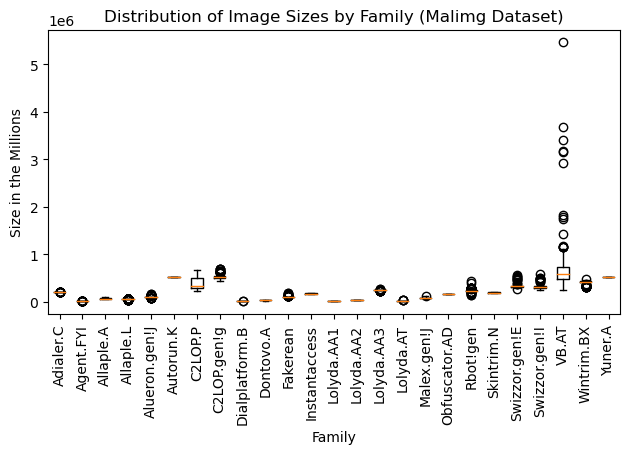

In [5]:
# Image sizes across families
plt.boxplot([db.loc[db.family == family].height * db.loc[db.family == family].width for family in np.unique(db.family)])
plt.title("Distribution of Image Sizes by Family (Malimg Dataset)")
plt.ylabel("Size in the Millions")
plt.xlabel("Family")
plt.xticks(range(1, 26), np.unique(db.family))
plt.tick_params(axis='x', rotation=90)
plt.tight_layout()

plt.savefig("results/malimg_size_dist.png")

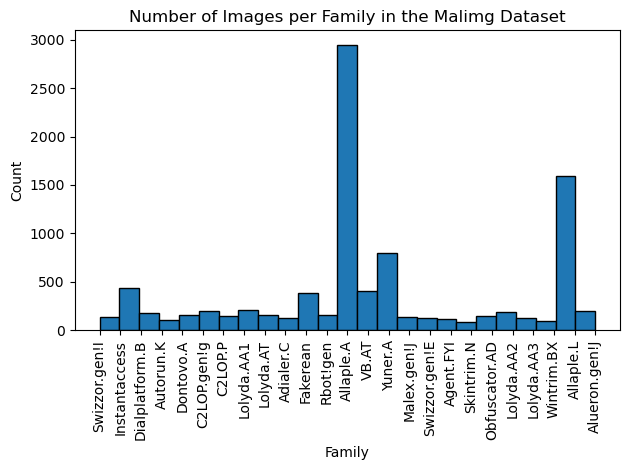

In [6]:
# Number of images per family
plt.hist(db[['family']], bins=25, edgecolor='black')
plt.title("Number of Images per Family in the Malimg Dataset")
plt.xlabel("Family")
plt.ylabel("Count")
plt.tick_params(axis='x', rotation=90)
plt.tight_layout()

plt.savefig("results/malimg_family_dist.png")

## Read and Preprocess the Malimg Dataset

All of the images in the Malimg Dataset are larger than the 224 x 224 input required by VGG16. However I don't perform data augmentation, like zooming, on the images before preprocessing. Zooming in would cause multiple pixels to be represented as one. So while it would preserve features visible to the human eye, it would likely convolute pixels with each other, changing their interpretation. I wanted to preserve the idea that each pixel represented one byte of data, as that is the purpose of the dataset. Having 224 x 224 accurate, original, interpretable pixels is more important than having 224 x 224 pixels where some of the pixels combine information from multiple bytes.

In [7]:
# Break malimg dataset into train and validation using 80/20 split
classes = ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J','Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A',
           'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N',
           'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']
generator = ImageDataGenerator(validation_split=0.2)
malimg_train_data = generator.flow_from_directory(directory="malimg_dataset/",
                                                  color_mode="grayscale", target_size=(224,224), class_mode="categorical",
                                                  classes=classes,
                                                  subset="training")
malimg_val_data = generator.flow_from_directory(directory="malimg_dataset/",
                                                  color_mode="grayscale", target_size=(224,224), class_mode="categorical",
                                                  classes=classes,
                                                  subset="validation")

Found 7486 images belonging to 25 classes.
Found 1860 images belonging to 25 classes.


In [8]:
# Load VGG16 for feature extraction
vgg16_model = VGG16()
# remove the output layers
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)

def feature_extraction(batch, model):
    features = []
    for img in batch:
        img = img.reshape(1, 224, 224, 1)
        img = np.repeat(img, 3, axis=3)
        img.reshape(1, 224, 224, 3)
        imgx = preprocess_input(img)
        features.append(model.predict(imgx, verbose=0))
    return features

In [9]:
# Perform feature extraction on the Malimg training and validation sets and save true labels
i = 0
l = 0
sample_features_train = []
sample_features_val = []
true_labels_train = []
true_labels_val = []
while i < len(malimg_train_data):
    # save true batch labels
    idxs = []
    for labels in malimg_train_data[i][1]:
        for j in range(0, 25):
            if labels[j]==1:
                idxs.append(j)
                continue
    true_labels_train.append(idxs)
    # extract features
    batch = malimg_train_data[i][0]
    sample_features_train.append(feature_extraction(batch, vgg16_model))
    i += 1
    
while l < len(malimg_val_data):
    # save true batch labels
    idxs = []
    for labels in malimg_val_data[l][1]:
        for k in range(0, 25):
            if labels[k]==1:
                idxs.append(k)
                continue
    true_labels_val.append(idxs)
    # extract features
    batch = malimg_val_data[l][0]
    sample_features_val.append(feature_extraction(batch, vgg16_model))
    l += 1

2025-03-31 14:07:57.205748: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


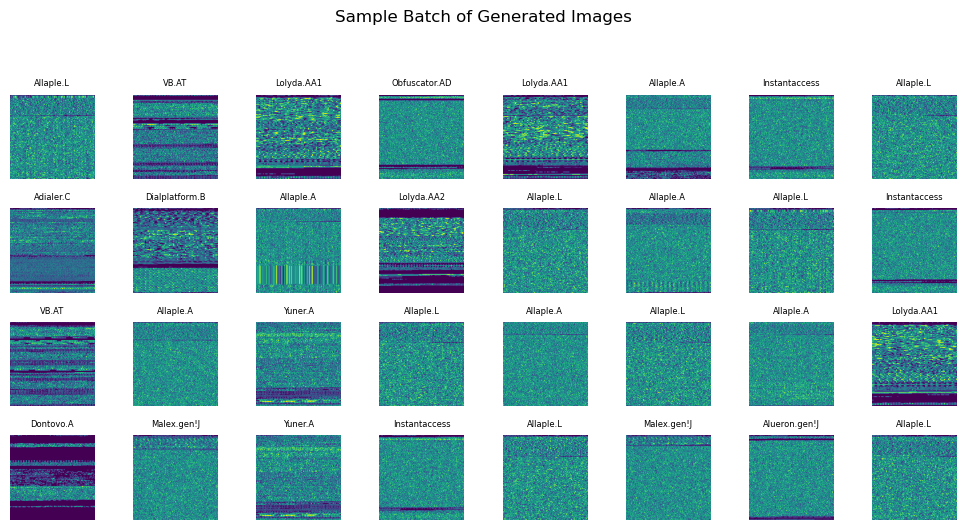

In [10]:
# Visualize Malimg Images in one sample batch of 32
(sample_batch, batch_labels) = malimg_train_data[2]
fig, ax = plt.subplots(4,8, figsize = (10, 5))
ax = ax.ravel()
for i, img in enumerate(sample_batch):
    ax[i].set_axis_off()
    ax[i].imshow(img)
    ax[i].set_title('{}'.format(classes[true_labels_train[2][i]]), fontdict={'fontsize': 6})
plt.suptitle('Sample Batch of Generated Images', y=1.05)
plt.tight_layout()
plt.savefig("results/sample_images.png")

## Perform Principal Component Analysis to Reduce Dimensionality of the Dataset

Decide on the number of principal components by plotting percent variance explained (elbow plot, stop including new components when percent variance explained stops decreasing with each new component). 

In [11]:
# PCA Prep
# Create a dataframe of each array in sample_features_train and sample_features_validation
train_dfs_list = [pd.DataFrame([arr[0].tolist() for arr in sample_features_train[i]]) for i in range(len(sample_features_train))]
val_dfs_list = [pd.DataFrame([arr[0].tolist() for arr in sample_features_val[i]]) for i in range(len(sample_features_val))]

# Add a column to each dataframe with the true malware family
for i in range(len(train_dfs_list)):
    train_dfs_list[i]['label'] = true_labels_train[i]
    
for j in range(len(val_dfs_list)):
    val_dfs_list[j]['label'] = true_labels_val[j]
    
# concatenate all arrays in sample_features_arr into one dataframe
train_df = pd.concat(train_dfs_list, ignore_index=True)
val_df = pd.concat(val_dfs_list, ignore_index=True)

# train_df and val_df should show all of the features for each image in the training and validation sets, with a label appended to the end
# will remove this label for performing PCA
train_df.head()

0         1         2         3         4    5         6    7    8    9  \
0  0.0  2.635806  0.000000  0.000000  0.000000  0.0  0.483080  0.0  0.0  0.0   
1  0.0  2.479470  0.058612  1.410048  1.401227  0.0  2.190249  0.0  0.0  0.0   
2  0.0  2.449132  0.000000  0.000000  0.000000  0.0  1.012509  0.0  0.0  0.0   
3  0.0  3.454001  0.000000  0.296388  0.000000  0.0  0.967830  0.0  0.0  0.0   
4  0.0  2.973916  0.000000  0.000000  0.000000  0.0  2.974494  0.0  0.0  0.0   

   ...      4087      4088      4089      4090      4091      4092  4093  \
0  ...  0.000000  0.000000  2.405963  1.573446  1.513052  2.227993   0.0   
1  ...  1.522012  0.000000  2.038112  1.403380  0.000000  0.000000   0.0   
2  ...  0.352177  0.000000  0.663422  0.469174  1.503327  0.200980   0.0   
3  ...  0.000000  0.042129  2.994895  0.000000  1.915719  1.203928   0.0   
4  ...  0.011371  0.000000  2.357263  0.528542  2.947368  2.690645   0.0   

       4094  4095  label  
0  2.132612   0.0      3  
1  0.000000   0.0     14  
2  0.000000   0.0     17  
3  0.000000   0.0      2  
4  0.000000   0.0      3  

[5 rows x 4097 columns]

In [12]:
# Decide on the number of principal components to include, based on training data
# Start by fitting on all of the principal components
pca = PCA().fit(train_df.drop('label', axis=1))

eigenvalues = pca.explained_variance_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

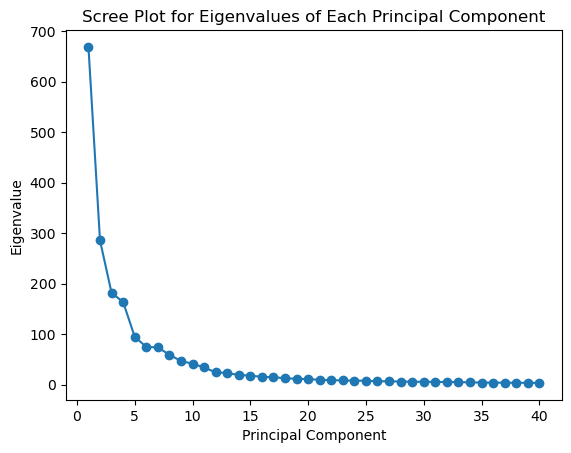

In [13]:
plt.plot(range(1, 41), eigenvalues[:40], marker='o')
plt.title('Scree Plot for Eigenvalues of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.savefig("results/scree.png")

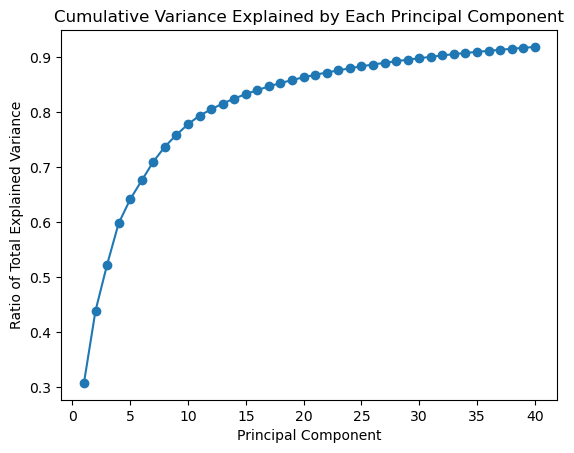

In [14]:
plt.plot(range(1, 41), cumulative_variance[:40], marker='o')
plt.title('Cumulative Variance Explained by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Ratio of Total Explained Variance')
plt.savefig("results/cumvar.png")

In [15]:
cumulative_variance[3]

0.5975094602760732

In [16]:
# perform PCA on training and validation sets with n_components = 4
pca = PCA(n_components=4)
pca_train = pca.fit_transform(train_df.drop('label', axis=1))
pca_val = pca.fit_transform(val_df.drop('label', axis=1))

### ANOVA F-Test for Variance Between/Within Clusters

In [17]:
# Centroids of each class of train data
pca_train_with_labels = pd.concat([pd.DataFrame(pca_train), train_df['label']], axis=1)
centroids = pca_train_with_labels.groupby('label').mean()
centroids

0          1          2          3
label                                            
0      40.280615   1.432423  18.077299 -12.668458
1      -1.238489  29.279770 -10.734396   9.321924
2     -19.916862  -7.754178   3.094308   2.352093
3     -20.489419   2.129062 -10.330792 -14.967675
4       0.443521   8.265740  16.068044   2.430604
5      49.806750 -20.433413 -15.781759  -2.493888
6      13.722948  -0.174282  17.578585   9.018650
7      16.557213 -20.885339  -2.526696  -4.069091
8      -5.722185  35.725831 -24.678381   9.003339
9      16.870908  34.247575   4.478116  -1.243014
10     12.016791  -3.802462  -1.400776  41.263600
11    -11.321733  -2.469050  19.886909   7.639009
12      8.341242  46.898259 -20.298985  10.028690
13     18.624322  27.044602  -0.037032   3.826496
14     -1.101575  26.162296   7.186314  12.325413
15      2.671853  39.908328 -29.760824  11.606420
16    -14.807496  -7.186261   7.802856   2.765544
17     -3.804054  -3.642459  17.525446   0.387268
18     27.042214 -13.366501  -1.508783  -6.277187
19      2.711523  -3.825559  19.961688   6.768819
20     30.012412 -15.671488   2.816388  -1.668980
21     31.186855 -12.253178   5.798450  -0.172302
22     43.339659  28.474327  31.411864 -18.337102
23     -2.865728 -20.012493  -0.676377   3.880189
24     51.855230 -19.623033 -15.301769  -3.287255

In [18]:
# H_null is that there is no difference between the mean points of the groups
overall_mean = pd.DataFrame(pca_train_with_labels.drop('label', axis=1).mean()).T
overall_mean

0             1             2             3
0 -1.913511e-15 -4.404112e-16 -1.063062e-15  3.644782e-16

In [19]:
# Sum of squares between groups
SSB = np.sum([len(pca_train_with_labels[pca_train_with_labels[['label']] == i]) * sum((centroids.loc[i] - overall_mean)**2) for i in range(25)])
SSB

1122900

In [20]:
# Sum of squares within groups
# Calculate the sum of squares within groups
SSW = 0
for i in range(25):
    group_samples = pca_train_with_labels[pca_train_with_labels['label'] == i].drop('label', axis=1)
    SSW += sum(np.sum((group_samples - centroids.loc[i])**2))
SSW

586969.7661747504

In [21]:
# Compute degrees of freedom
df_between = 24
df_within = len(pca_train_with_labels)-25

In [22]:
# Mean Square between and within groups
MSB = SSB / df_between
MSW = SSW / df_within

# Calculate F-Statistic
F_value = MSB/ MSW

# Critical Value of F
f_critical = stats.f.ppf(1-0.05, df_between, df_within)

# Compare F and f_critical
F_value, f_critical

(594.7180887611045, 1.5187585615319035)

## KMeans Clustering

In [23]:
k = 25 # knowing that there are 25 classes in the data (25 malware families)
kmeans = KMeans(n_clusters=k, n_init=10).fit(pca_train)
# save the truth next to the prediction
kmeans_train_results = list(zip(kmeans.predict(pca_train), train_df['label']))

In [24]:
# Match cluster assignments to true family indices
families = []
for j in range(len(kmeans_train_results)):
    for l in range(0,k):
        if list(malimg_train_data.class_indices.values())[l]==kmeans_train_results[j][1]:
            families.append(list(malimg_train_data.class_indices.keys())[l])
        else:
            continue

In [25]:
classes_kmeans_train = pd.DataFrame([(pair[0], pair[1], name) for (pair,name) in zip(kmeans_train_results, families)], 
                         columns = ["Assigned Cluster", "True Family Index", "True Family Name"])
classes_kmeans_train

Assigned Cluster  True Family Index True Family Name
0                    0                  3        Allaple.L
1                   19                 14       Lolyda.AA3
2                   20                 17    Obfuscator.AD
3                   24                  2        Allaple.A
4                    0                  3        Allaple.L
...                ...                ...              ...
7481                12                  2        Allaple.A
7482                 5                 24          Yuner.A
7483                 4                 22            VB.AT
7484                11                 11    Instantaccess
7485                24                  2        Allaple.A

[7486 rows x 3 columns]

Plot a confusion matrix showing how many times each true family appeared in each cluster for the KMeans model fit on training data

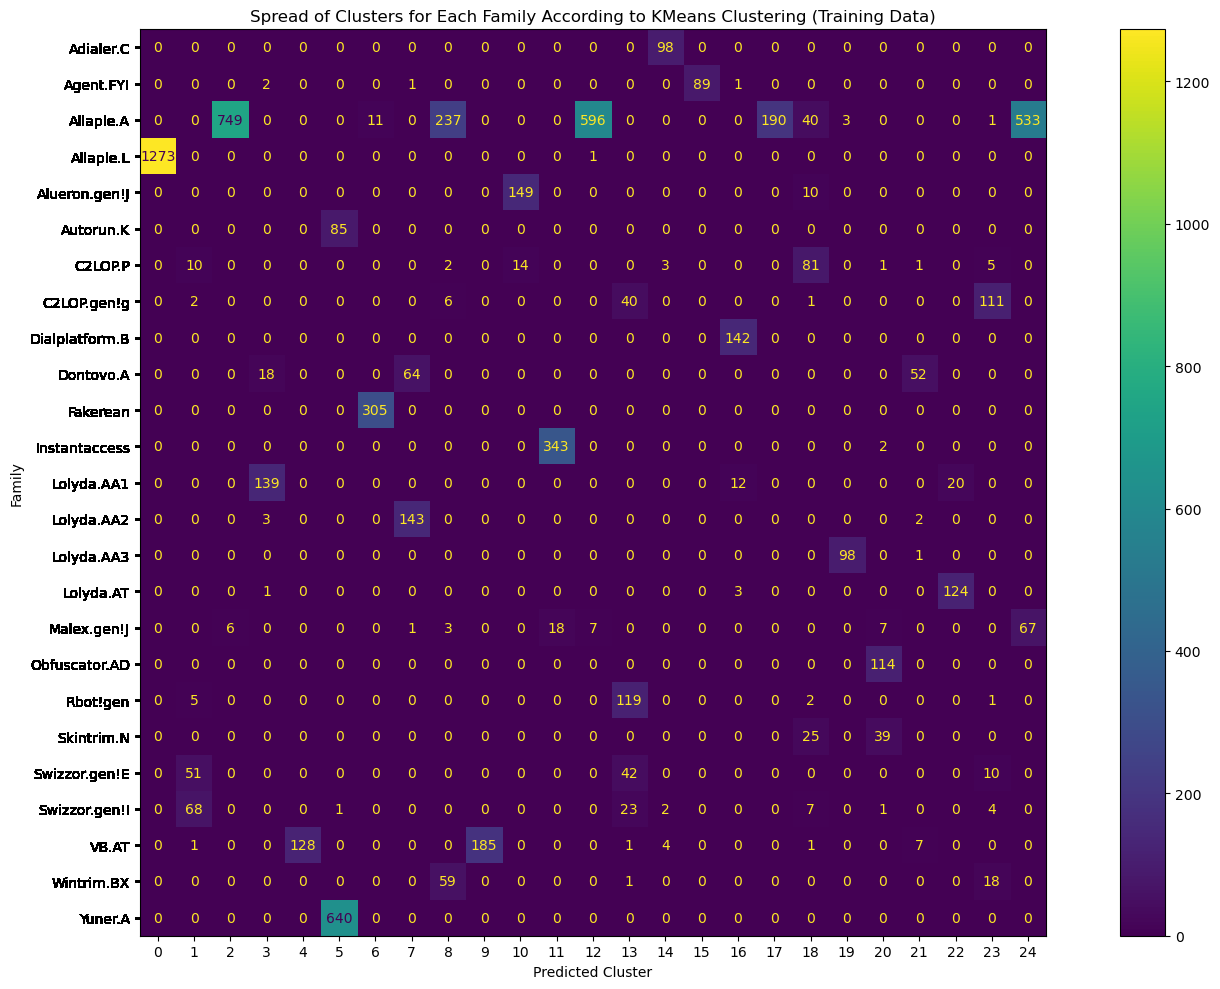

In [26]:
kmeans_train_matrix = ConfusionMatrixDisplay(confusion_matrix(classes_kmeans_train["True Family Index"], classes_kmeans_train["Assigned Cluster"]))

fig, ax = plt.subplots(figsize=(15,10))
kmeans_train_matrix.plot(ax=ax)
ax.set_title("Spread of Clusters for Each Family According to KMeans Clustering (Training Data)")
ax.set_xlabel("Predicted Cluster")
ax.set_ylabel("Family")
ax.set_yticks(classes_kmeans_train["True Family Index"], classes_kmeans_train["True Family Name"])
fig.tight_layout()
fig.savefig("results/kmeans_train_matrix.png")

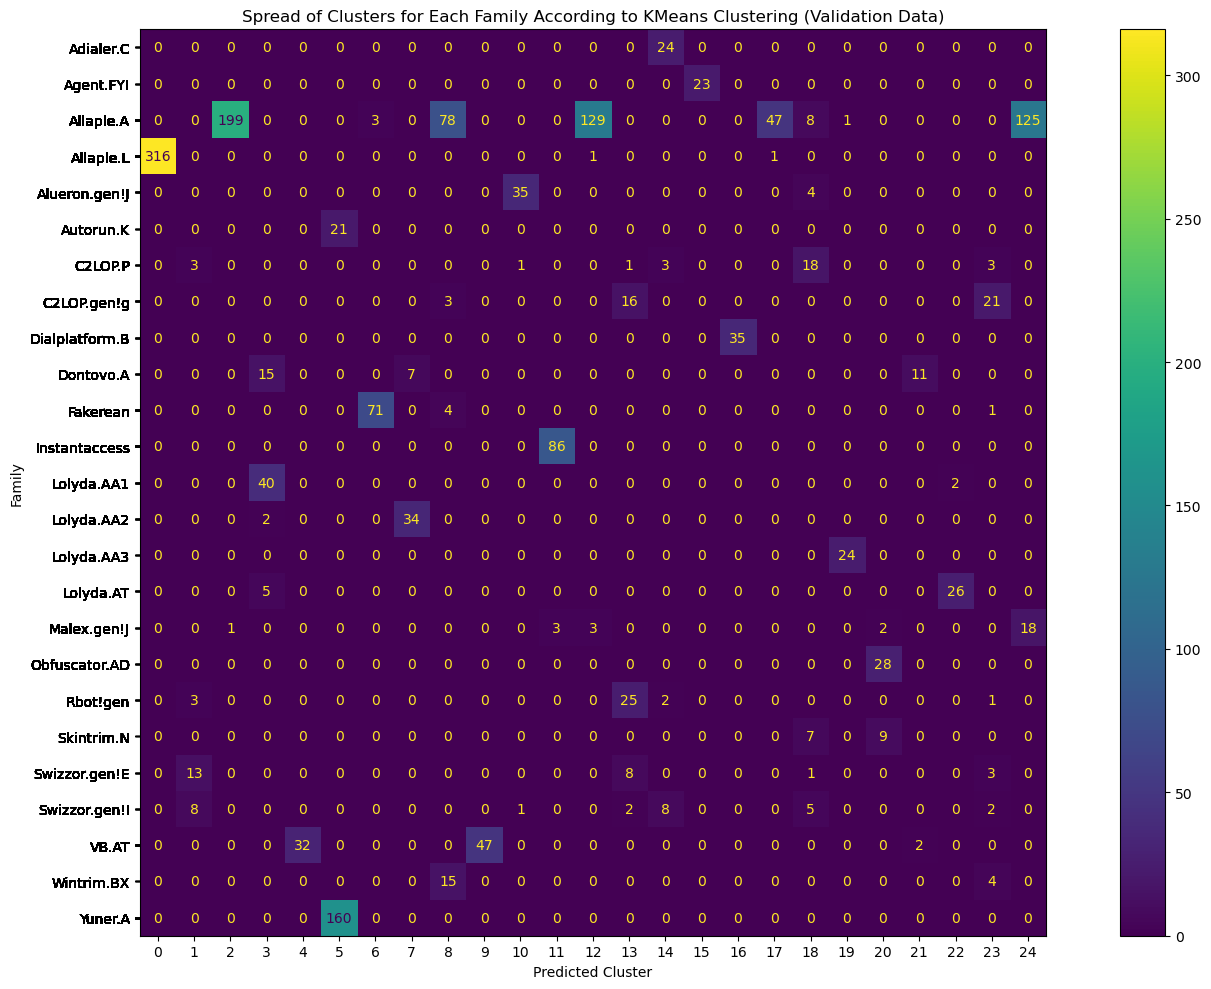

In [27]:
# Predict on the validation data and print confusion matrix
kmeans_val_results = list(zip(kmeans.predict(pca_val), val_df['label']))

val_families = []
for j in range(len(kmeans_val_results)):
    for l in range(0,k):
        if list(malimg_val_data.class_indices.values())[l]==kmeans_val_results[j][1]:
            val_families.append(list(malimg_val_data.class_indices.keys())[l])
        else:
            continue

classes_kmeans_val = pd.DataFrame([(pair[0], pair[1], name) for (pair, name) in zip(kmeans_val_results, val_families)], 
                                    columns = ["Assigned Cluster", "True Family Index", "True Family Name"])

kmeans_val_matrix = ConfusionMatrixDisplay(confusion_matrix(classes_kmeans_val["True Family Index"], classes_kmeans_val["Assigned Cluster"]))

fig, ax = plt.subplots(figsize=(15,10))
kmeans_val_matrix.plot(ax=ax) 
ax.set_title("Spread of Clusters for Each Family According to KMeans Clustering (Validation Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Cluster")
ax.set_yticks(classes_kmeans_val["True Family Index"], classes_kmeans_val["True Family Name"])
fig.tight_layout()
fig.savefig("results/kmeans_val_matrix.png")

## Agglomerative Clustering

In [28]:
# Calculate the average pairwise distance between classes
pair_idxs = list(combinations(range(0, 24), 2))
distances = [0 for i in range(len(pair_idxs))]

for i in range(len(pair_idxs)):
    df = pca_train_with_labels.iloc[list(pair_idxs[i])]
    distances[i] = np.sqrt(sum([(df[[0]].diff().dropna()[0])**2, (df[[1]].diff().dropna()[1])**2, (df[[2]].diff().dropna()[2])**2]))

avg_distance = np.mean(distances)
avg_distance

33.4984507989498

In [29]:
# Perform Agglomerative Clustering using 25 classes
agg_cluster_model = AgglomerativeClustering(n_clusters = 25, metric = 'euclidean')
agg_cluster_preds = agg_cluster_model.fit_predict(pca_train)

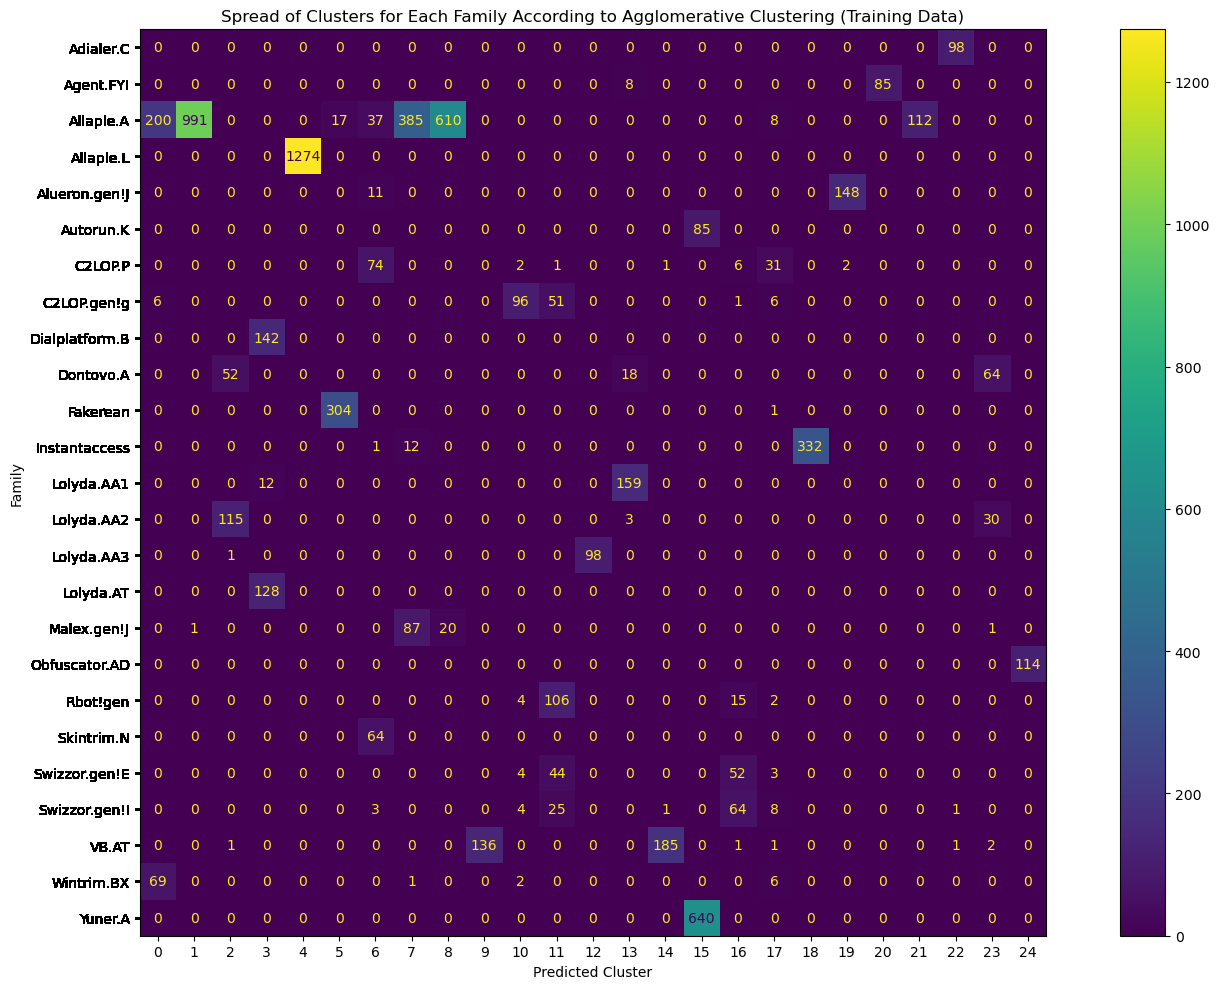

In [30]:
# Compile a df of true classes and assigned clusters, plot the confusion matrix
agg_train_results = list(zip(agg_cluster_preds, train_df['label']))

agg_train_families = []
for j in range(len(agg_train_results)):
    for l in range(0,k):
        if list(malimg_train_data.class_indices.values())[l]==agg_train_results[j][1]:
            agg_train_families.append(list(malimg_train_data.class_indices.keys())[l])
        else:
            continue

classes_agg_train = pd.DataFrame([(pair[0], pair[1], name) for (pair, name) in zip(agg_train_results, agg_train_families)], 
                                    columns = ["Assigned Cluster", "True Family Index", "True Family Name"])

agg_train_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(classes_agg_train["True Family Index"], classes_agg_train["Assigned Cluster"]))

fig, ax = plt.subplots(figsize=(15,10))
agg_train_matrix.plot(ax=ax) 
ax.set_title("Spread of Clusters for Each Family According to Agglomerative Clustering (Training Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Cluster")
ax.set_yticks(classes_agg_train["True Family Index"], classes_agg_train["True Family Name"])
fig.tight_layout()
fig.savefig("results/agg_train_matrix.png")

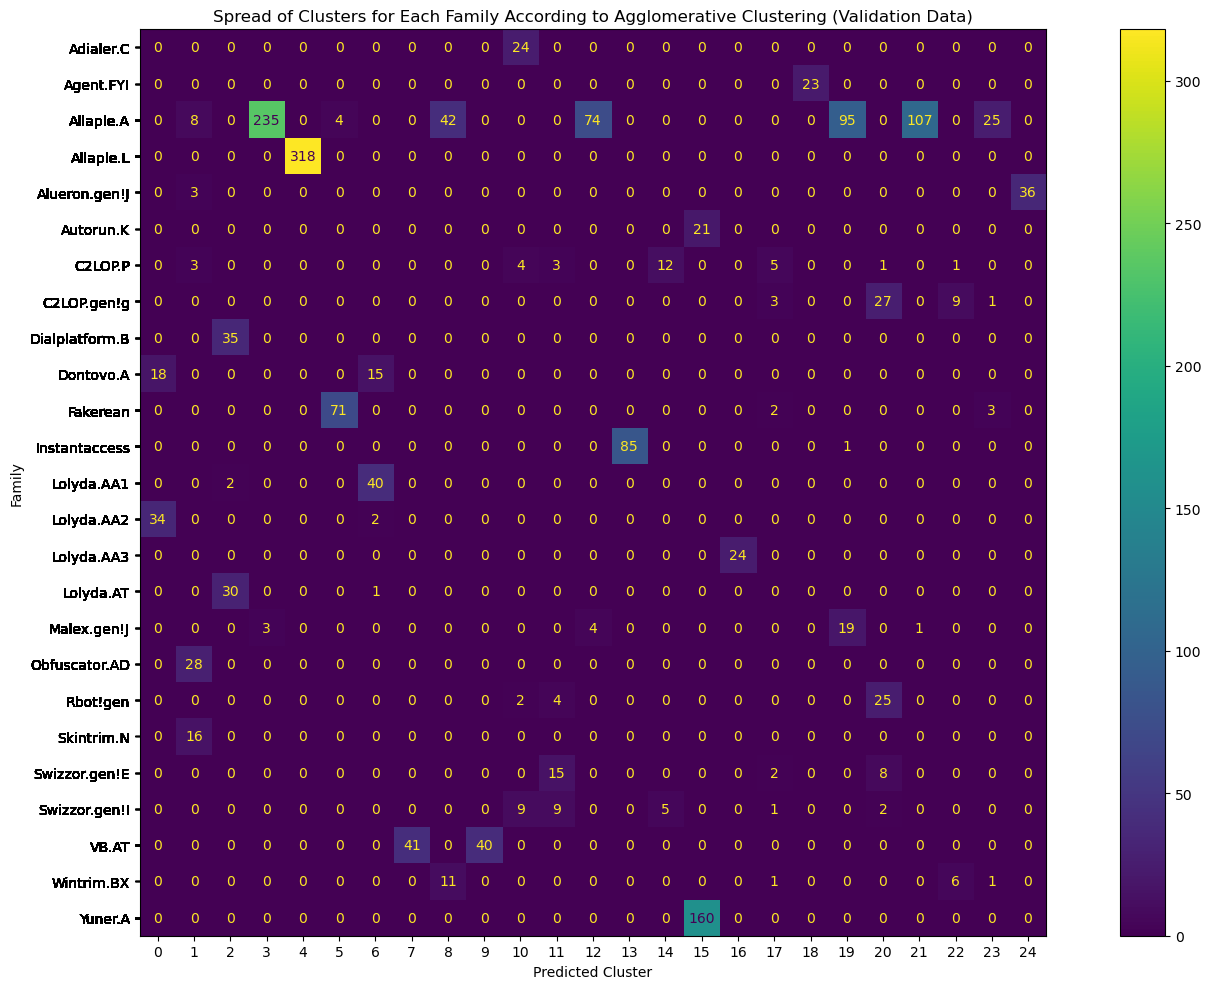

In [31]:
# Predict on the validation set and repeat
agg_val_preds = agg_cluster_model.fit_predict(pca_val)

agg_val_results = list(zip(agg_val_preds, val_df['label']))

agg_val_families = []
for j in range(len(agg_val_results)):
    for l in range(0,k):
        if list(malimg_val_data.class_indices.values())[l]==agg_val_results[j][1]:
            agg_val_families.append(list(malimg_val_data.class_indices.keys())[l])
        else:
            continue

classes_agg_val = pd.DataFrame([(pair[0], pair[1], name) for (pair, name) in zip(agg_val_results, agg_val_families)], 
                                    columns = ["Assigned Cluster", "True Family Index", "True Family Name"])

agg_val_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(classes_agg_val["True Family Index"], classes_agg_val["Assigned Cluster"]))

fig, ax = plt.subplots(figsize=(15,10))
agg_val_matrix.plot(ax=ax) 
ax.set_title("Spread of Clusters for Each Family According to Agglomerative Clustering (Validation Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Cluster")
ax.set_yticks(classes_agg_val["True Family Index"], classes_agg_val["True Family Name"])
fig.tight_layout()
fig.savefig("results/agg_val_matrix.png")

## Precision, Recall, and F1 Score for the Clustering Models

Precision: For each cluster, how many different families were represented?

$\frac{Max\_Samples\_in\_Same\_Family\_and\_Cluster\_i}{Samples\_in\_Cluster\_i}$

Recall: For each family, how many were put into the same cluster?

$\frac{Max\_Samples\_Clustered\_Together\_from\_Family\_i}{Samples\_in\_Family\_i}$

F1 Score:

$\frac{2(Precision)(Recall)}{Precision + Recall}$

In [32]:
kmeans_metrics = pd.DataFrame({'Recall': [np.mean([max(row) / sum(row) for row in kmeans_train_matrix.confusion_matrix]), 
                                             np.mean([max(row) / sum(row) for row in kmeans_val_matrix.confusion_matrix])], 
                               'Precision': [np.mean([max(col) / sum(col) for col in kmeans_train_matrix.confusion_matrix.T]), 
                                          np.mean([max(col) / sum(col) if (~(col == np.zeros(len(col))).all()) else 0 for col in kmeans_val_matrix.confusion_matrix.T])]}).rename(index = {0: 'Training', 1: 'Validation'})
agg_metrics = pd.DataFrame({'Recall': [np.mean([max(row) / sum(row) for row in agg_train_matrix.confusion_matrix]), 
                                          np.mean([max(row) / sum(row) for row in agg_val_matrix.confusion_matrix])], 
                               'Precision': [np.mean([max(col) / sum(col) for col in agg_train_matrix.confusion_matrix.T]), 
                                          np.mean([max(col) / sum(col) for col in agg_val_matrix.confusion_matrix.T])]}).rename(index = {0: 'Training', 1: 'Validation'})

In [33]:
kmeans_metrics['F1 Score'] = (2 * kmeans_metrics['Precision'] * kmeans_metrics['Recall']) / (kmeans_metrics['Precision'] + kmeans_metrics['Recall'])
kmeans_metrics

Recall  Precision  F1 Score
Training    0.817047   0.852062  0.834187
Validation  0.789258   0.836420  0.812155

In [34]:
agg_metrics['F1 Score'] = (2 * agg_metrics['Precision'] * agg_metrics['Recall']) / (agg_metrics['Precision'] + agg_metrics['Recall'])
agg_metrics

Recall  Precision  F1 Score
Training    0.832896   0.824295  0.828573
Validation  0.811368   0.788455  0.799748

# Classification Methods

## KNN Classifier

In [35]:
# Rename train and val data (for use in all models)
X_train = pca_train
y_train = np.ravel(train_df[["label"]])
X_val = pca_val
y_val = np.ravel(val_df[["label"]])
all_malimg_X = pd.concat([pd.DataFrame(pca_train), pd.DataFrame(pca_val)])
all_malimg_y = np.ravel(pd.concat([train_df[["label"]], val_df[["label"]]]))

### Cross Validation to Choose a k

In [36]:
train_scores = []
val_scores = []
cv_scores = []
for k in range(1, 31):
    knn_model = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    cv_scores.append(cross_validate(knn_model, all_malimg_X, all_malimg_y)['test_score'])
    train_scores.append(knn_model.score(X_train, y_train))
    val_scores.append(knn_model.score(X_val, y_val))

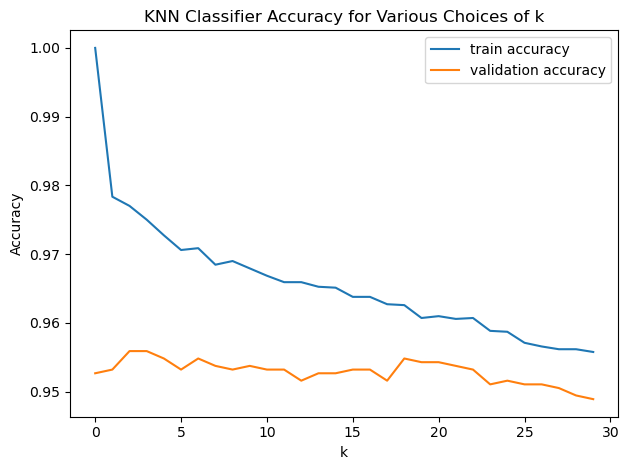

In [37]:
plt.plot(train_scores, label="train accuracy")
plt.plot(val_scores, label="validation accuracy")
plt.legend()
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN Classifier Accuracy for Various Choices of k")
plt.tight_layout()
plt.savefig("results/choice_of_k1.png")

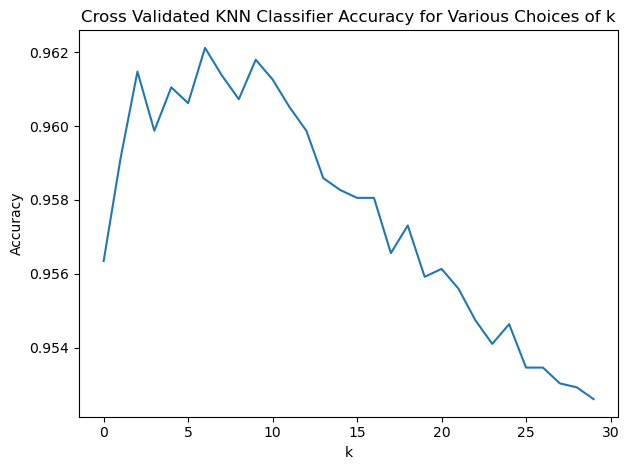

In [38]:
# plot cross-validated scores over choice of k
plt.plot([np.mean(arr) for arr in cv_scores])
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Cross Validated KNN Classifier Accuracy for Various Choices of k")
plt.tight_layout()
plt.savefig("results/cv_choice_of_k.png")

In [39]:
# train and save the KNN Classifier with k=7 neighbors
knn_model = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

In [40]:
knn_train_result = knn_model.score(X_train, y_train)
knn_train_result

0.9708789740849586

In [41]:
knn_val_result = knn_model.score(X_val, y_val)
knn_val_result

0.9548387096774194

### Define a Function for Open-Set Prediction (to be used on all classification models)

In [42]:
# open set prediction
def open_set_pred(model, train_data, threshold):
    open_set_preds = []
    probs = model.predict_proba(train_data)
    preds = model.predict(train_data)
    max_probs = np.max(probs, axis=1)
    
    for i in range(len(train_data)):
        if max_probs[i] < threshold:
            open_set_preds.append("unknown")
        else:
            open_set_preds.append(preds[i])
    return open_set_preds

In [43]:
# KNN Training Predictions
knn_train_preds = knn_model.predict(X_train)

# KNN Validation Predictions
knn_val_preds = knn_model.predict(X_val)

# KNN Open-Set Predictions (training)
os_knn_preds_train = open_set_pred(knn_model, X_train, 0.80)
# percent of observations classified as "unknown"
knn_pct_unknown_train = sum([1 if os_knn_preds_train[i] == "unknown" else 0 for i in range(len(os_knn_preds_train))]) / len(os_knn_preds_train)

# KNN Validation Open-Set Predictions
os_knn_preds_val = open_set_pred(knn_model, X_val, 0.80)
# percent of observations classified as "unknown"
knn_pct_unknown_val = sum([1 if os_knn_preds_val[i] == "unknown" else 0 for i in range(len(os_knn_preds_val))]) / len(os_knn_preds_val)
knn_pct_unknown_train, knn_pct_unknown_val

(0.05717339032861341, 0.05860215053763441)

## Visualize KNN Results

In [44]:
class_index_reference = classes_kmeans_train[['True Family Index', 'True Family Name']].drop_duplicates(ignore_index=True)
class_index_reference

True Family Index True Family Name
0                   3        Allaple.L
1                  14       Lolyda.AA3
2                  17    Obfuscator.AD
3                   2        Allaple.A
4                  16      Malex.gen!J
5                  21    Swizzor.gen!I
6                  13       Lolyda.AA2
7                   1        Agent.FYI
8                  22            VB.AT
9                  24          Yuner.A
10                 10         Fakerean
11                  4    Alueron.gen!J
12                 11    Instantaccess
13                 19       Skintrim.N
14                  8   Dialplatform.B
15                 12       Lolyda.AA1
16                  6          C2LOP.P
17                  0        Adialer.C
18                  5        Autorun.K
19                 18         Rbot!gen
20                  9        Dontovo.A
21                 15        Lolyda.AT
22                 20    Swizzor.gen!E
23                  7      C2LOP.gen!g
24                 23       Wintrim.BX

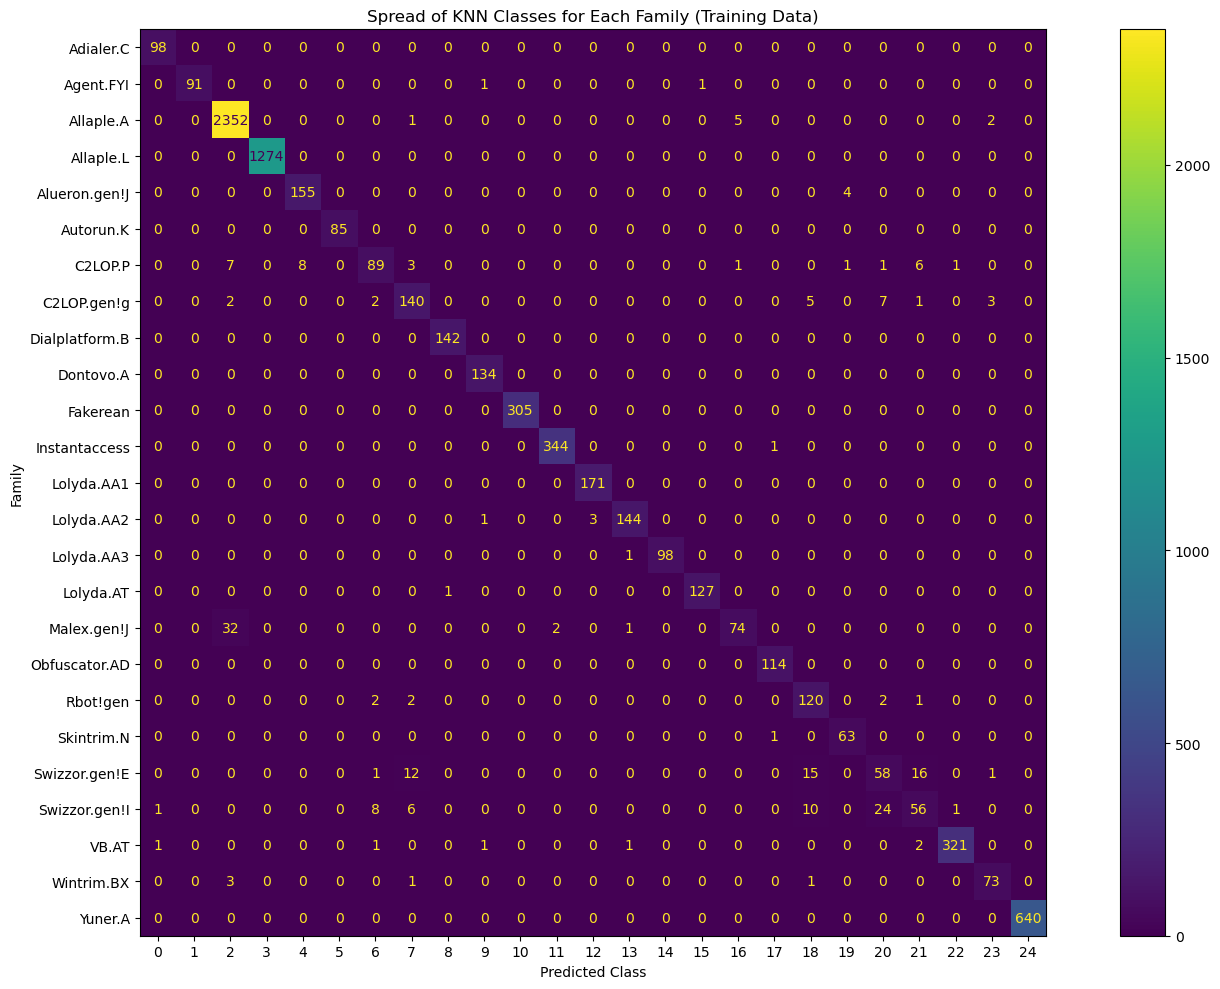

In [45]:
knn_train_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_train, knn_train_preds))

fig, ax = plt.subplots(figsize=(15,10))
knn_train_matrix.plot(ax=ax) 
ax.set_title("Spread of KNN Classes for Each Family (Training Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Class")
ax.set_yticks(class_index_reference["True Family Index"], class_index_reference["True Family Name"])
fig.tight_layout()
fig.savefig("results/knn_train_cm.png")

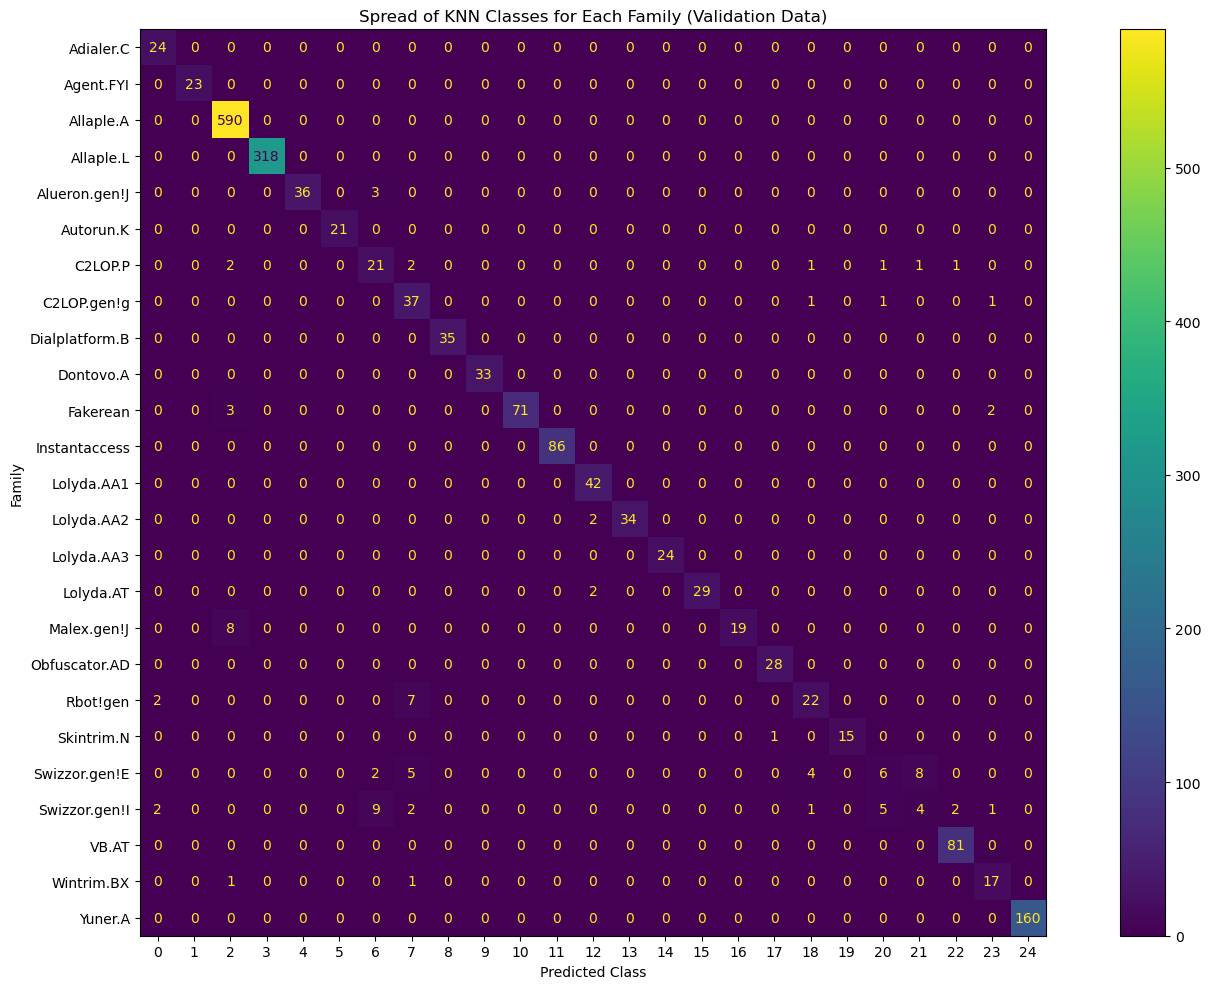

In [46]:
# repeat for validation
knn_val_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_val, knn_val_preds))

fig, ax = plt.subplots(figsize=(15,10))
knn_val_matrix.plot(ax=ax) 
ax.set_title("Spread of KNN Classes for Each Family (Validation Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Class")
ax.set_yticks(class_index_reference["True Family Index"], class_index_reference["True Family Name"])
fig.tight_layout()
fig.savefig("results/knn_val_cm.png")

## Precision, Recall, and F1 Score for the KNN Classifier

In [47]:
knn_metrics = pd.DataFrame({'Precision': [precision_score(knn_train_preds, y_train, average="macro"), 
                                          precision_score(knn_val_preds, y_val, average="macro")], 
                            'Recall': [recall_score(knn_train_preds, y_train, average="macro"), 
                                       recall_score(knn_val_preds, y_val, average="macro")],
                            'F1 Score': [f1_score(knn_train_preds, y_train, average="macro"),
                                         f1_score(knn_val_preds, y_val, average="macro")]}).rename(index = {0: 'Training', 1: 'Validation'})
knn_metrics

Precision    Recall  F1 Score
Training     0.926196  0.936205  0.929508
Validation   0.881033  0.891975  0.881433

## Random Forest Model

In [48]:
# Compute weights to balance classes
training_weights = class_weight.compute_class_weight('balanced', classes = np.unique(malimg_train_data.classes), y = malimg_train_data.classes)
val_weights = class_weight.compute_class_weight('balanced', classes = np.unique(malimg_val_data.classes), y = malimg_val_data.classes)

In [49]:
training_weights

array([3.0555102 , 3.21978495, 0.12688136, 0.23503925, 1.88327044,
       3.52282353, 2.55931624, 1.8715    , 2.10873239, 2.23462687,
       0.98177049, 0.86794203, 1.75111111, 2.02324324, 3.02464646,
       2.339375  , 2.74715596, 2.62666667, 2.35779528, 4.67875   ,
       2.90718447, 2.82490566, 0.91571865, 3.83897436, 0.467875  ])

### Determine Random Forest Hyperparameters
Decide on the optimal number of trees in the random forest and the maximum depth of the trees.

In [50]:
rf_train_scores = pd.DataFrame({'n_trees': [], 'depth': [], 'score': []})
rf_val_scores = pd.DataFrame({'n_trees': [], 'depth': [], 'score': []})
rf_cv_scores = pd.DataFrame({'n_trees': [], 'depth': [], 'score': []})

for n_trees in range(3, 20):
    for depth in range(10, 30):
        rf_model = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', max_depth=depth, class_weight='balanced').fit(X_train, y_train)
        rf_train_scores = pd.concat([rf_train_scores, pd.DataFrame({'n_trees': [n_trees], 'depth': [depth], 'score': [rf_model.score(X_train, y_train)]})])
        rf_val_scores = pd.concat([rf_val_scores, pd.DataFrame({'n_trees': [n_trees], 'depth': [depth], 'score': [rf_model.score(X_val, y_val)]})])
        rf_cv_scores = pd.concat([rf_cv_scores, pd.DataFrame({'n_trees': [n_trees], 'depth': [depth], 'score': [cross_validate(rf_model, all_malimg_X, all_malimg_y)['test_score']]})])

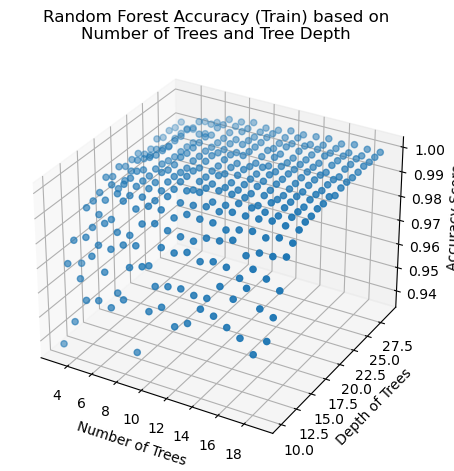

In [51]:
# Plot accuracy scores relative to n_trees and depth for training data, validation data, and cross validated
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(rf_train_scores[['n_trees']], rf_train_scores[['depth']], rf_train_scores[['score']])
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Depth of Trees")
ax.set_zlabel("Accuracy Score")
plt.title("Random Forest Accuracy (Train) based on\nNumber of Trees and Tree Depth")
plt.tight_layout()
plt.savefig("results/rf_train_scores.png")

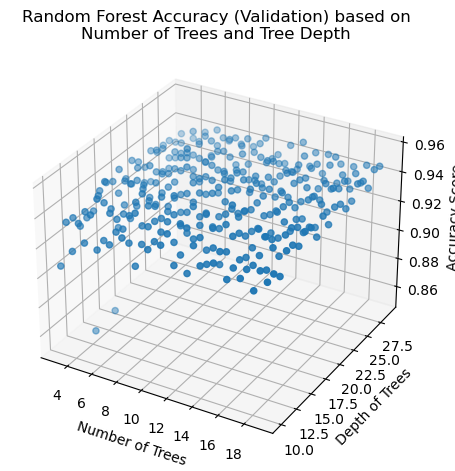

In [52]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(rf_val_scores[['n_trees']], rf_val_scores[['depth']], rf_val_scores[['score']])
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Depth of Trees")
ax.set_zlabel("Accuracy Score")
plt.title("Random Forest Accuracy (Validation) based on\nNumber of Trees and Tree Depth")
plt.tight_layout()
plt.savefig("results/rf_val_scores.png")

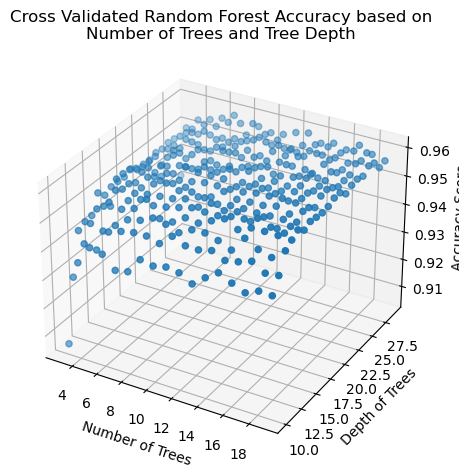

In [53]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(rf_cv_scores['n_trees'], rf_cv_scores['depth'], [np.mean(arr) for arr in rf_cv_scores['score']])
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Depth of Trees")
ax.set_zlabel("Accuracy Score")
plt.title("Cross Validated Random Forest Accuracy based on\nNumber of Trees and Tree Depth")
plt.tight_layout()
plt.savefig("results/rf_cv_scores.png")

It does not seem that accuracy changes as the number of trees in the forest changes, so I proceed with 150 trees. Now I visualize how accuracy changes as the depth of the trees change.

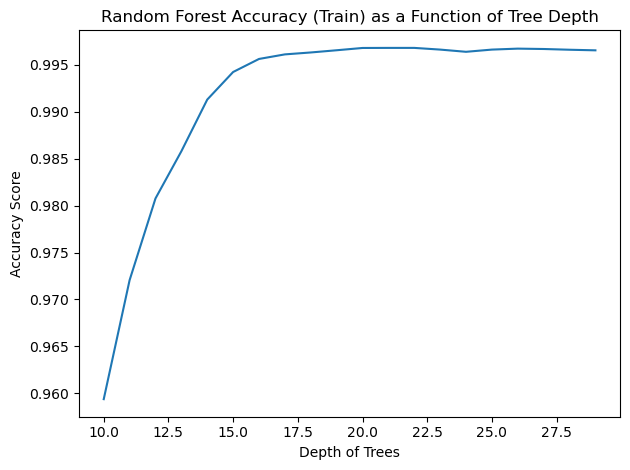

In [54]:
plt.plot(np.unique(rf_train_scores[['depth']]), rf_train_scores.groupby('depth').apply(lambda x: np.mean(x['score'])))
plt.title("Random Forest Accuracy (Train) as a Function of Tree Depth")
plt.xlabel("Depth of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/rf_depth_train.png")

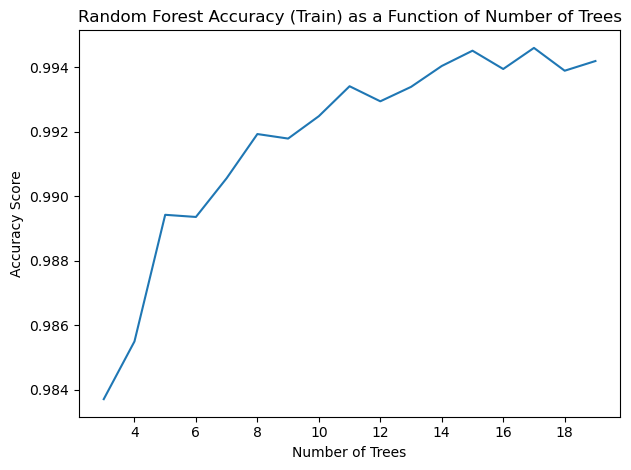

In [55]:
plt.plot(np.unique(rf_train_scores[['n_trees']]), rf_train_scores.groupby('n_trees').apply(lambda x: np.mean(x['score'])))
plt.title("Random Forest Accuracy (Train) as a Function of Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/rf_trees_train.png")

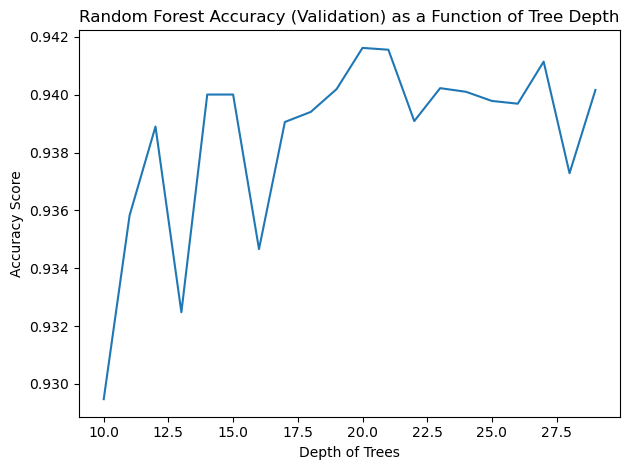

In [56]:
plt.plot(np.unique(rf_val_scores[['depth']]), rf_val_scores.groupby('depth').apply(lambda x: np.mean(x['score'])))
plt.title("Random Forest Accuracy (Validation) as a Function of Tree Depth")
plt.xlabel("Depth of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/rf_depth_val.png")

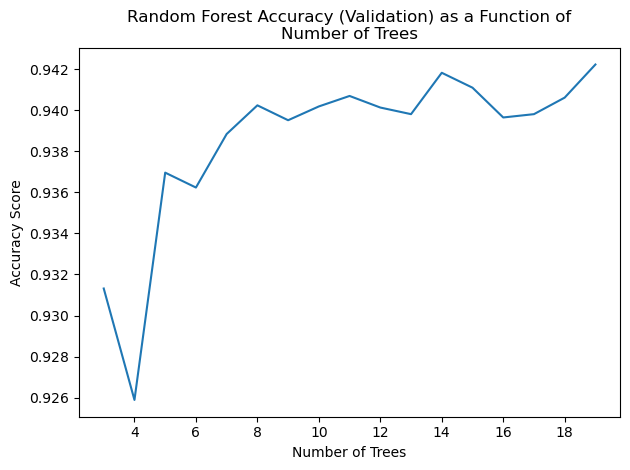

In [57]:
plt.plot(np.unique(rf_val_scores[['n_trees']]), rf_val_scores.groupby('n_trees').apply(lambda x: np.mean(x['score'])))
plt.title("Random Forest Accuracy (Validation) as a Function of\nNumber of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/rf_trees_val.png")

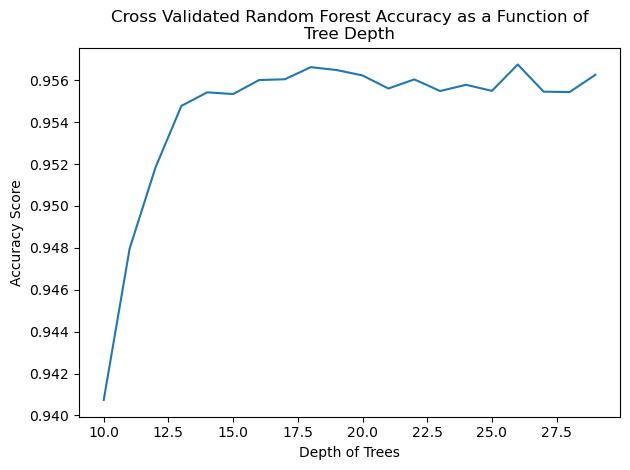

In [58]:
plt.plot(np.unique(rf_cv_scores[['depth']]), rf_cv_scores.groupby('depth').apply(lambda x: np.mean([np.mean(arr) for arr in x['score']])))
plt.title("Cross Validated Random Forest Accuracy as a Function of\nTree Depth")
plt.xlabel("Depth of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/rf_depth_cv.png")

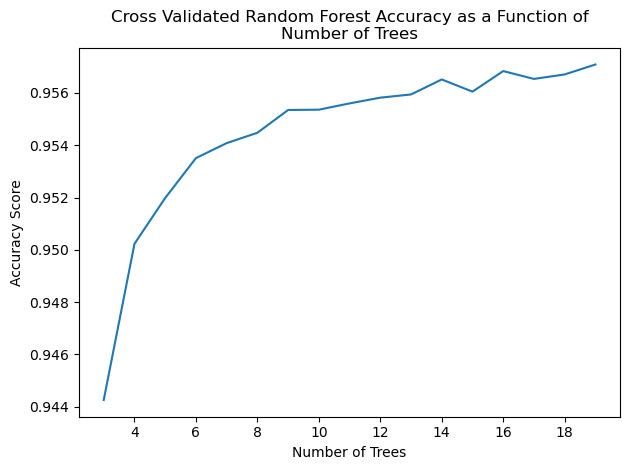

In [59]:
plt.plot(np.unique(rf_cv_scores[['n_trees']]), rf_cv_scores.groupby('n_trees').apply(lambda x: np.mean([np.mean(arr) for arr in x['score']])))
plt.title("Cross Validated Random Forest Accuracy as a Function of\nNumber of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/rf_trees_cv.png")

In [60]:
# Train the random forest model with the chosen parameters
rf_model = RandomForestClassifier(n_estimators=15, max_features='sqrt', max_depth=15, class_weight = 'balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=15)

In [61]:
# Random Forest Training Accuracy
rf_train_result = rf_model.score(X_train, y_train)
rf_train_result

0.9965268501202245

In [62]:
rf_val_result = rf_model.score(X_val, y_val)
rf_val_result

0.9467741935483871

In [63]:
# Predictions
rf_train_preds = rf_model.predict(X_train)

# Validation Predictions
rf_val_preds = rf_model.predict(X_val)

# RF Open-Set Predictions (training)
os_rf_preds_train = open_set_pred(rf_model, X_train, 0.80)
# percent of observations classified as "unknown"
rf_pct_unknown_train = sum([1 if os_rf_preds_train[i] == "unknown" else 0 for i in range(len(os_rf_preds_train))]) / len(os_rf_preds_train)

# RF Validation Open-Set Predictions
os_rf_preds_val = open_set_pred(rf_model, X_val, 0.80)
# percent of observations classified as "unknown"
rf_pct_unknown_val = sum([1 if os_rf_preds_val[i] == "unknown" else 0 for i in range(len(os_rf_preds_val))]) / len(os_rf_preds_val)
rf_pct_unknown_train, rf_pct_unknown_val

(0.05450173657493989, 0.1086021505376344)

## Visualize Results (RF)

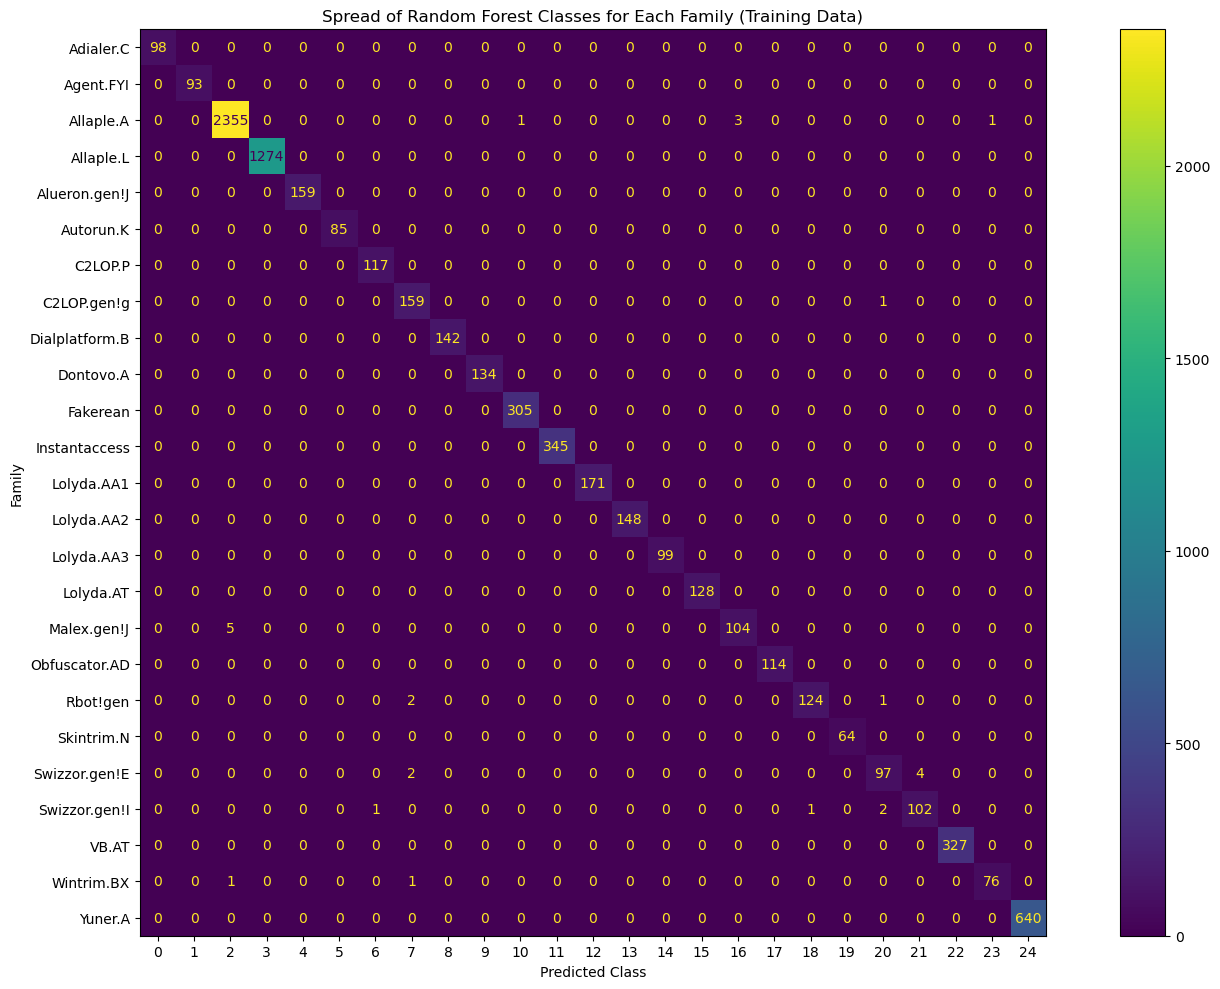

In [64]:
rf_train_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_train, rf_train_preds))

fig, ax = plt.subplots(figsize=(15,10))
rf_train_matrix.plot(ax=ax) 
ax.set_title("Spread of Random Forest Classes for Each Family (Training Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Class")
ax.set_yticks(class_index_reference["True Family Index"], class_index_reference["True Family Name"])
fig.tight_layout()
fig.savefig("results/rf_train_cm.png")

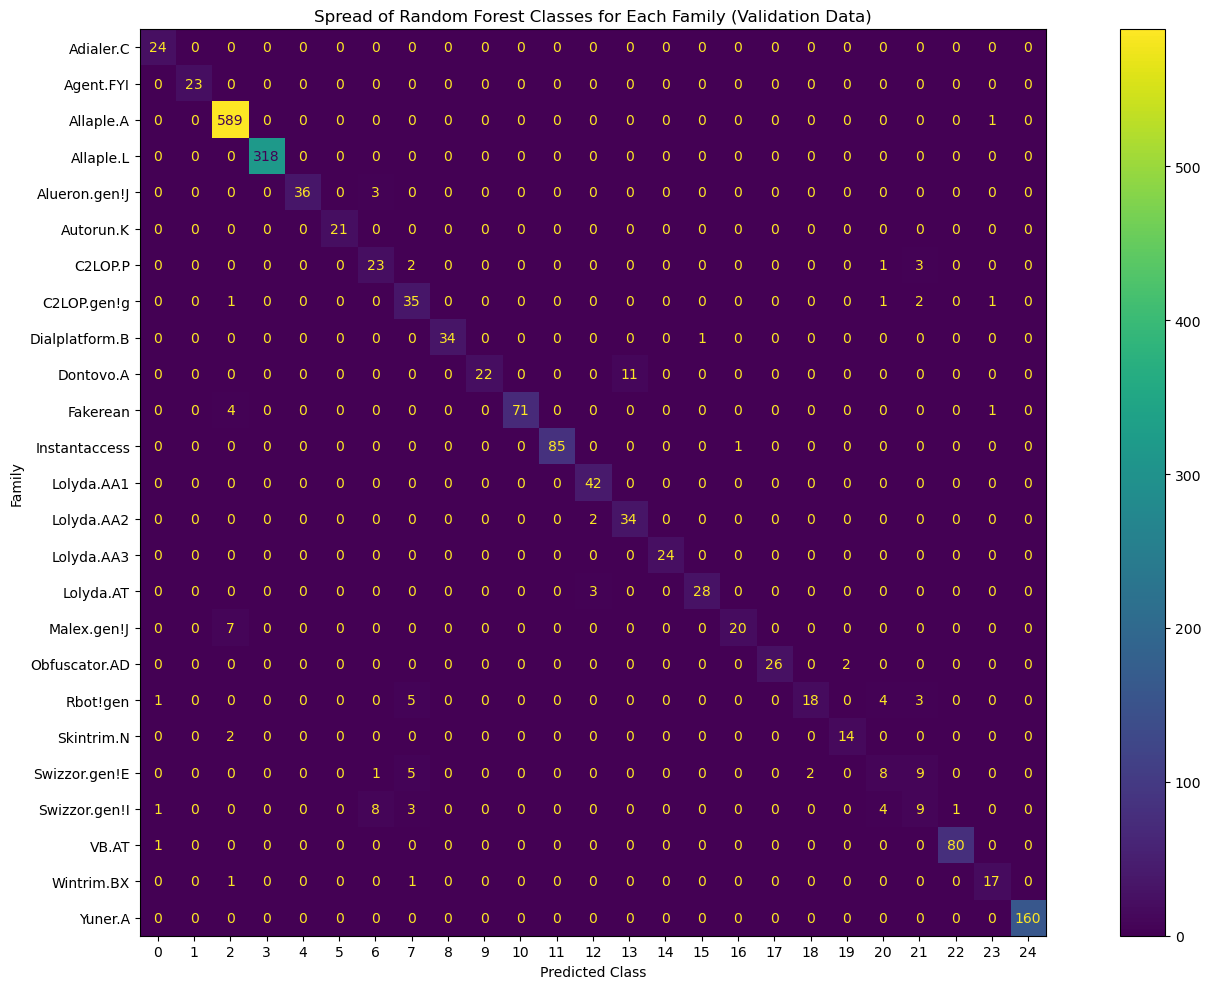

In [65]:
# validation
rf_val_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_val, rf_val_preds))

fig, ax = plt.subplots(figsize=(15,10))
rf_val_matrix.plot(ax=ax) 
ax.set_title("Spread of Random Forest Classes for Each Family (Validation Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Class")
ax.set_yticks(class_index_reference["True Family Index"], class_index_reference["True Family Name"])
fig.tight_layout()
fig.savefig("results/rf_val_cm.png")

## Precision, Recall, and F1 Score for the Random Forest Classifier

In [66]:
rf_metrics = pd.DataFrame({'Precision': [precision_score(rf_train_preds, y_train, average="macro"), 
                                          precision_score(rf_val_preds, y_val, average="macro")], 
                            'Recall': [recall_score(rf_train_preds, y_train, average="macro"), 
                                       recall_score(rf_val_preds, y_val, average="macro")],
                            'F1 Score': [f1_score(rf_train_preds, y_train, average="macro"),
                                         f1_score(rf_val_preds, y_val, average="macro")]}).rename(index = {0: 'Training', 1: 'Validation'})
rf_metrics

Precision    Recall  F1 Score
Training     0.992020  0.993155  0.992570
Validation   0.866853  0.887112  0.871717

## Support Vector Machine

Tune a regularizaton parameter C, values between 1, 10, 100, 500, and 1000

In [67]:
svm_train_scores = []
svm_val_scores = []
svm_cv_scores = []
for c in np.logspace(-2, 2, 5):
    svm_model = svm.SVC(kernel='linear', class_weight = 'balanced', probability = True, C = c).fit(X_train, y_train)
    svm_cv_scores.append(cross_validate(svm_model, all_malimg_X, all_malimg_y)['test_score'])
    svm_train_scores.append(svm_model.score(X_train, y_train))
    svm_val_scores.append(svm_model.score(X_val, y_val))

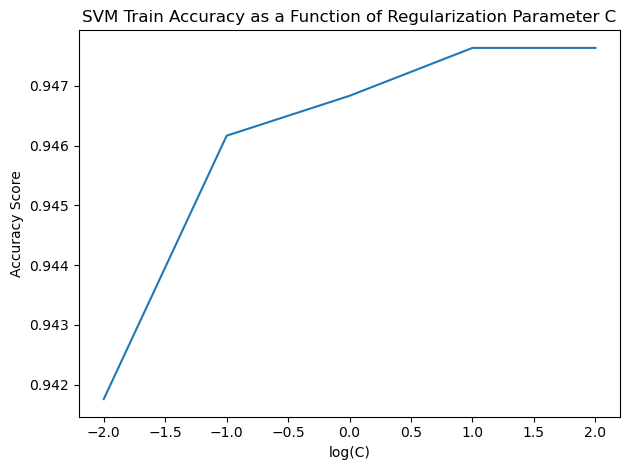

In [68]:
# Graph scores relative to C value to determine optimal parameter
plt.plot(np.log10(np.logspace(-2, 2, 5)), svm_train_scores)
plt.title("SVM Train Accuracy as a Function of Regularization Parameter C")
plt.xlabel("log(C)")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/svm_train.png")

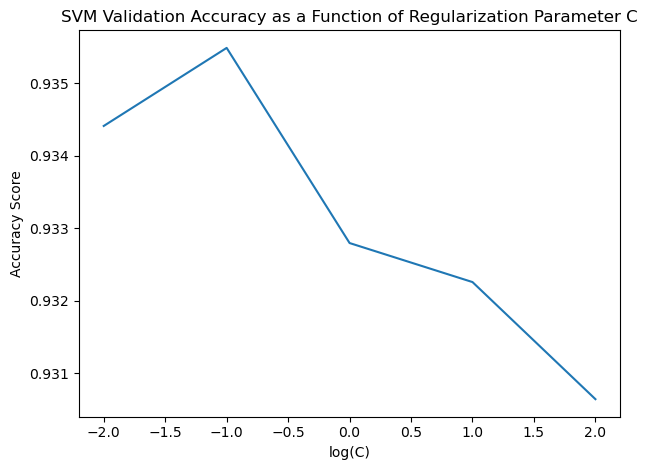

In [69]:
plt.plot(np.log10(np.logspace(-2, 2, 5)), svm_val_scores)
plt.title("SVM Validation Accuracy as a Function of Regularization Parameter C")
plt.xlabel("log(C)")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/svm_val.png")

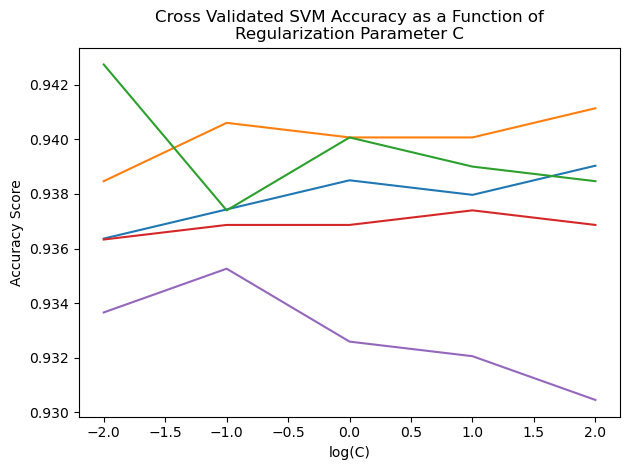

In [70]:
plt.plot(np.log10(np.logspace(-2, 2, 5)), svm_cv_scores)
plt.title("Cross Validated SVM Accuracy as a Function of\nRegularization Parameter C")
plt.xlabel("log(C)")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("results/svm_cv.png")

In [71]:
# Instantiate SVM Classifier with a linear kernel
svm_classifier = svm.SVC(kernel='linear', class_weight = 'balanced', probability = True, C = 1/10)

# train on X_train, using balancing, not regularization as of now (see model diagnostics and if it should be regularized)
svm_classifier = svm_classifier.fit(X_train, y_train)
svm_train_score = svm_classifier.score(X_train, y_train)
svm_val_score = svm_classifier.score(X_val, y_val)
svm_train_score, svm_val_score

(0.9461661768634785, 0.9354838709677419)

In [72]:
# SVM Prediction and Open Set Prediction
svm_train_preds = svm_classifier.predict(X_train)
svm_val_preds = svm_classifier.predict(X_val)

os_svm_preds_train = open_set_pred(svm_classifier, X_train, 0.80)
pct_unknown_svm_train = sum([1 if os_svm_preds_train[i] == "unknown" else 0 for i in range(len(os_svm_preds_train))]) / len(os_svm_preds_train)

os_svm_preds_val = open_set_pred(svm_classifier, X_val, 0.80)
pct_unknown_svm_val = sum([1 if os_svm_preds_val[i] == "unknown" else 0 for i in range(len(os_svm_preds_val))]) / len(os_svm_preds_val)
pct_unknown_svm_train, pct_unknown_svm_val

(0.10352658295484905, 0.12795698924731183)

## Visualize SVM Results

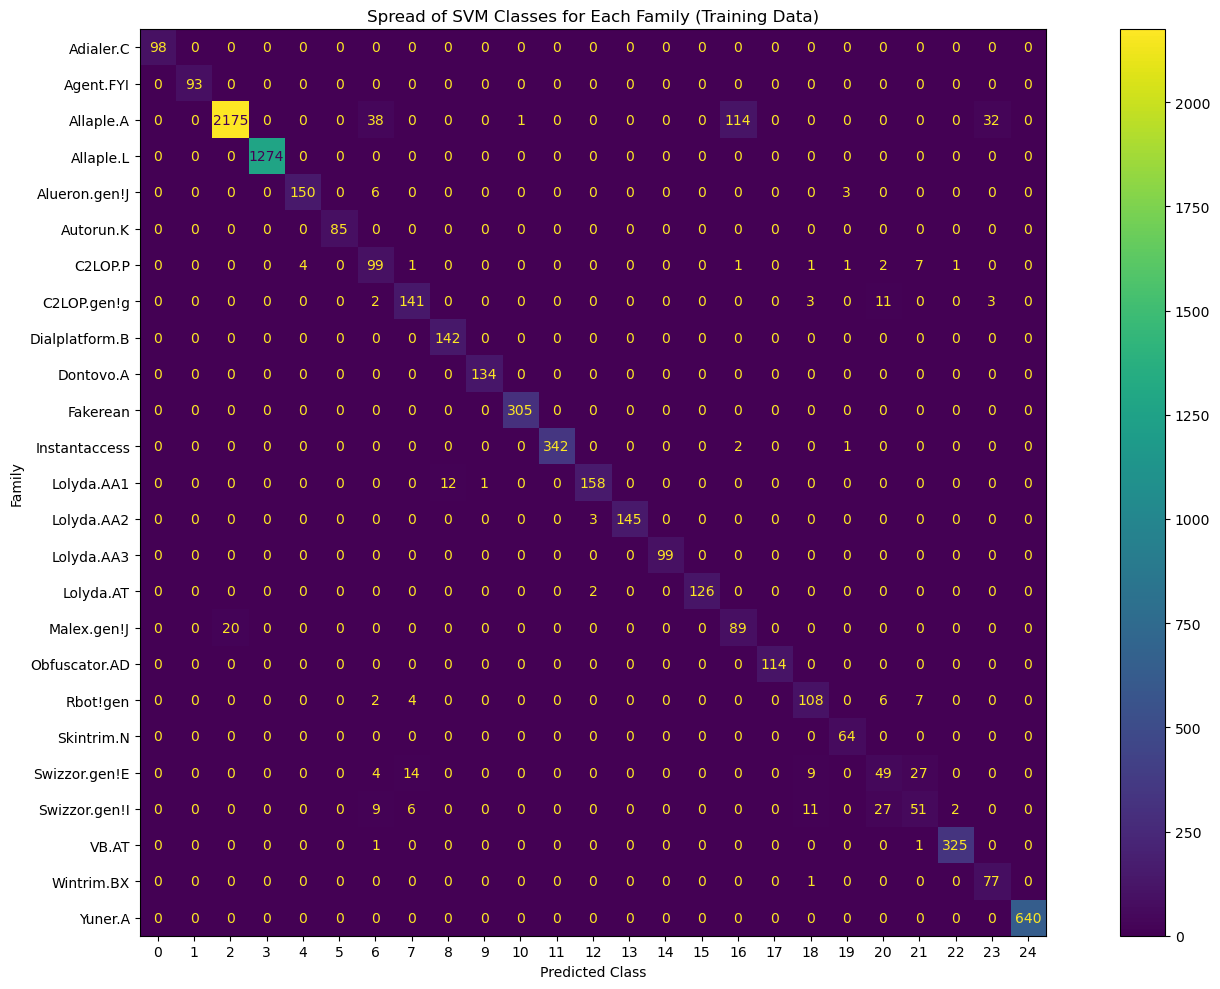

In [73]:
svm_train_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_train, svm_train_preds))

fig, ax = plt.subplots(figsize=(15,10))
svm_train_matrix.plot(ax=ax) 
ax.set_title("Spread of SVM Classes for Each Family (Training Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Class")
ax.set_yticks(class_index_reference["True Family Index"], class_index_reference["True Family Name"])
fig.tight_layout()
fig.savefig("results/svm_train_cm.png")

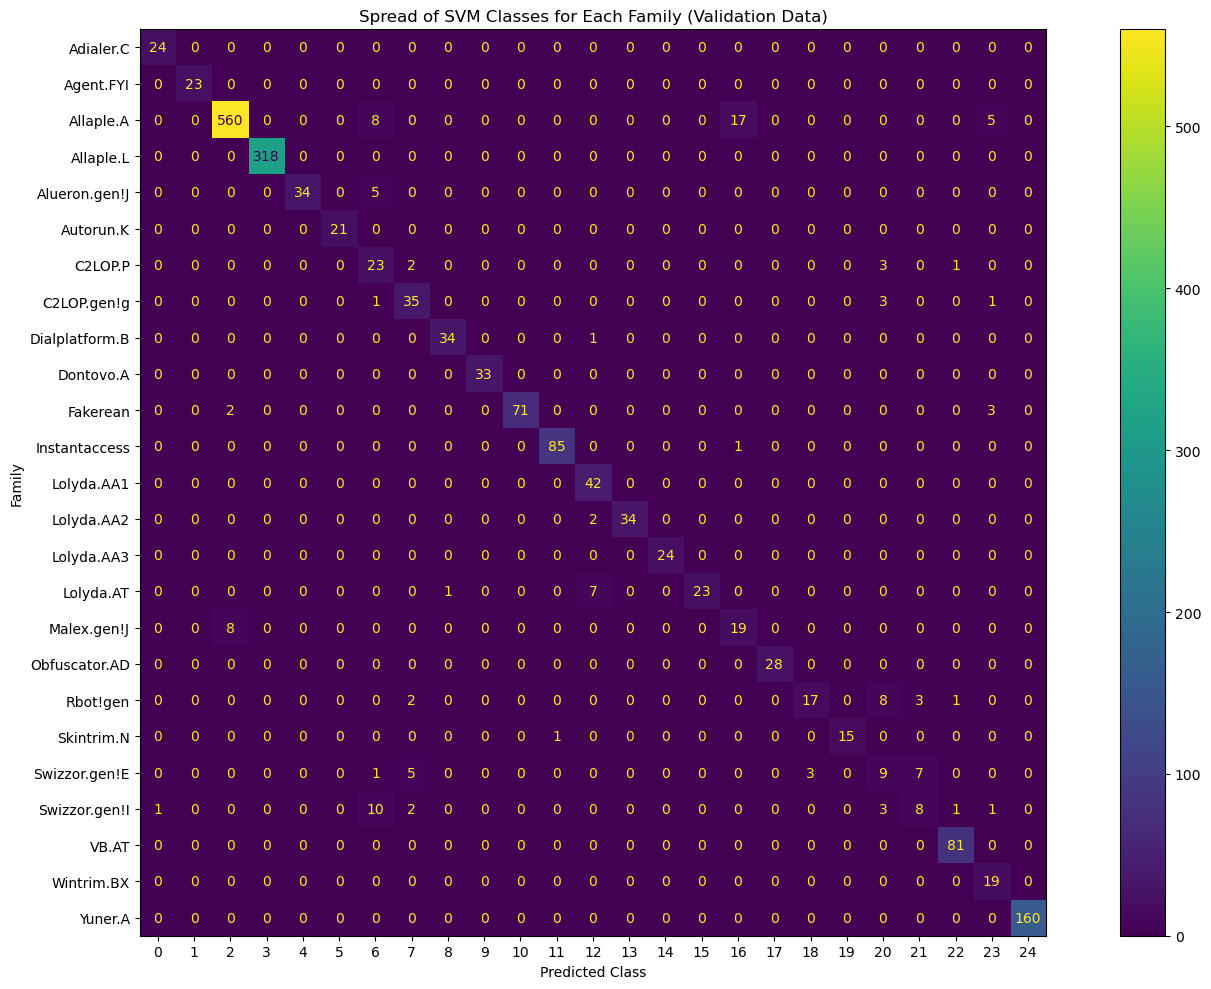

In [74]:
svm_val_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_val, svm_val_preds))

fig, ax = plt.subplots(figsize=(15,10))
svm_val_matrix.plot(ax=ax) 
ax.set_title("Spread of SVM Classes for Each Family (Validation Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Class")
ax.set_yticks(class_index_reference["True Family Index"], class_index_reference["True Family Name"])
fig.tight_layout()
fig.savefig("results/svm_val_cm.png")

## SVM Precision, Recall, and F1 Score

In [75]:
svm_metrics = pd.DataFrame({'Precision': [precision_score(svm_train_preds, y_train, average="macro"), 
                                          precision_score(svm_val_preds, y_val, average="macro")], 
                            'Recall': [recall_score(svm_train_preds, y_train, average="macro"), 
                                       recall_score(svm_val_preds, y_val, average="macro")],
                            'F1 Score': [f1_score(svm_train_preds, y_train, average="macro"),
                                         f1_score(svm_val_preds, y_val, average="macro")]}).rename(index = {0: 'Training', 1: 'Validation'})
svm_metrics

Precision    Recall  F1 Score
Training     0.923065  0.888963  0.901485
Validation   0.877069  0.868942  0.865955

## XGBoost Model

Use the same parameters as the random forest.

In [76]:
train_df['weight'] = [training_weights[i] for i in train_df['label']]

In [77]:
xgb_model = xgb.XGBClassifier(tree_method="hist", max_depth=15, n_estimators=15)
xgb_model = xgb_model.fit(X_train, y_train, sample_weight = train_df['weight'])

In [78]:
# Prediction and Open Set Prediction
xgb_train_preds = xgb_model.predict(X_train)
xgb_val_preds = xgb_model.predict(X_val)

os_xgb_preds_train = open_set_pred(xgb_model, X_train, 0.80)
xgb_pct_unknown_train = sum([1 if os_xgb_preds_train[i] == "unknown" else 0 for i in range(len(os_xgb_preds_train))]) / len(os_xgb_preds_train)

os_xgb_preds_val = open_set_pred(xgb_model, X_val, 0.80)
xgb_pct_unknown_val = sum([1 if os_xgb_preds_val[i] == "unknown" else 0 for i in range(len(os_xgb_preds_val))]) / len(os_xgb_preds_val)
xgb_pct_unknown_train, xgb_pct_unknown_val

(0.02351055303232701, 0.19623655913978494)

In [79]:
# Scoring the Model
xgb_train_score = metrics.accuracy_score(xgb_train_preds, y_train)
xgb_val_score = metrics.accuracy_score(xgb_val_preds, y_val)
xgb_train_score, xgb_val_score

(0.9933208656158162, 0.832258064516129)

## Visualize XGB Model

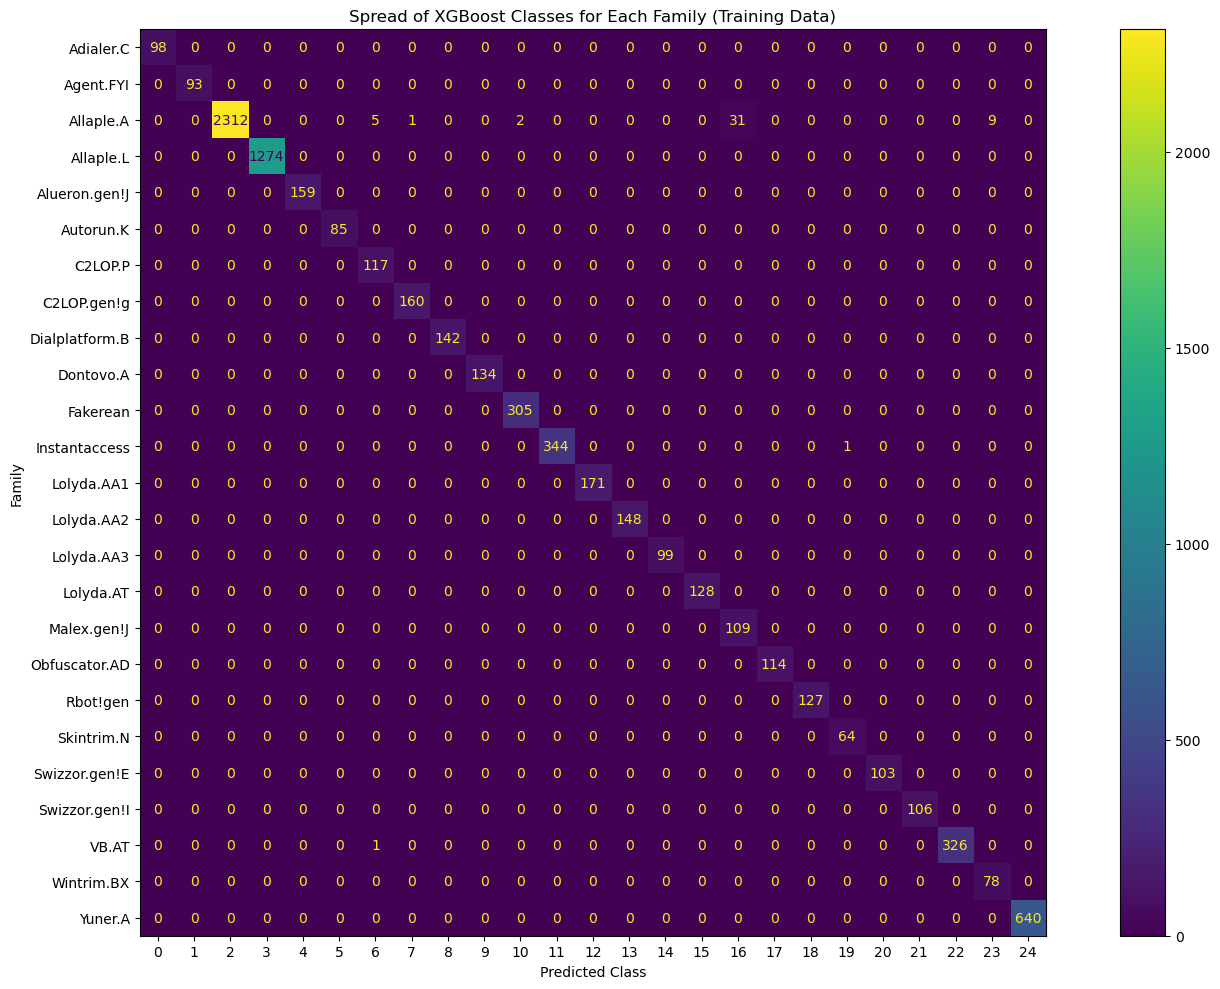

In [80]:
xgb_train_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_train, xgb_train_preds))

fig, ax = plt.subplots(figsize=(15,10))
xgb_train_matrix.plot(ax=ax) 
ax.set_title("Spread of XGBoost Classes for Each Family (Training Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Class")
ax.set_yticks(class_index_reference["True Family Index"], class_index_reference["True Family Name"])
fig.tight_layout()
fig.savefig("results/xgb_train_cm.png")

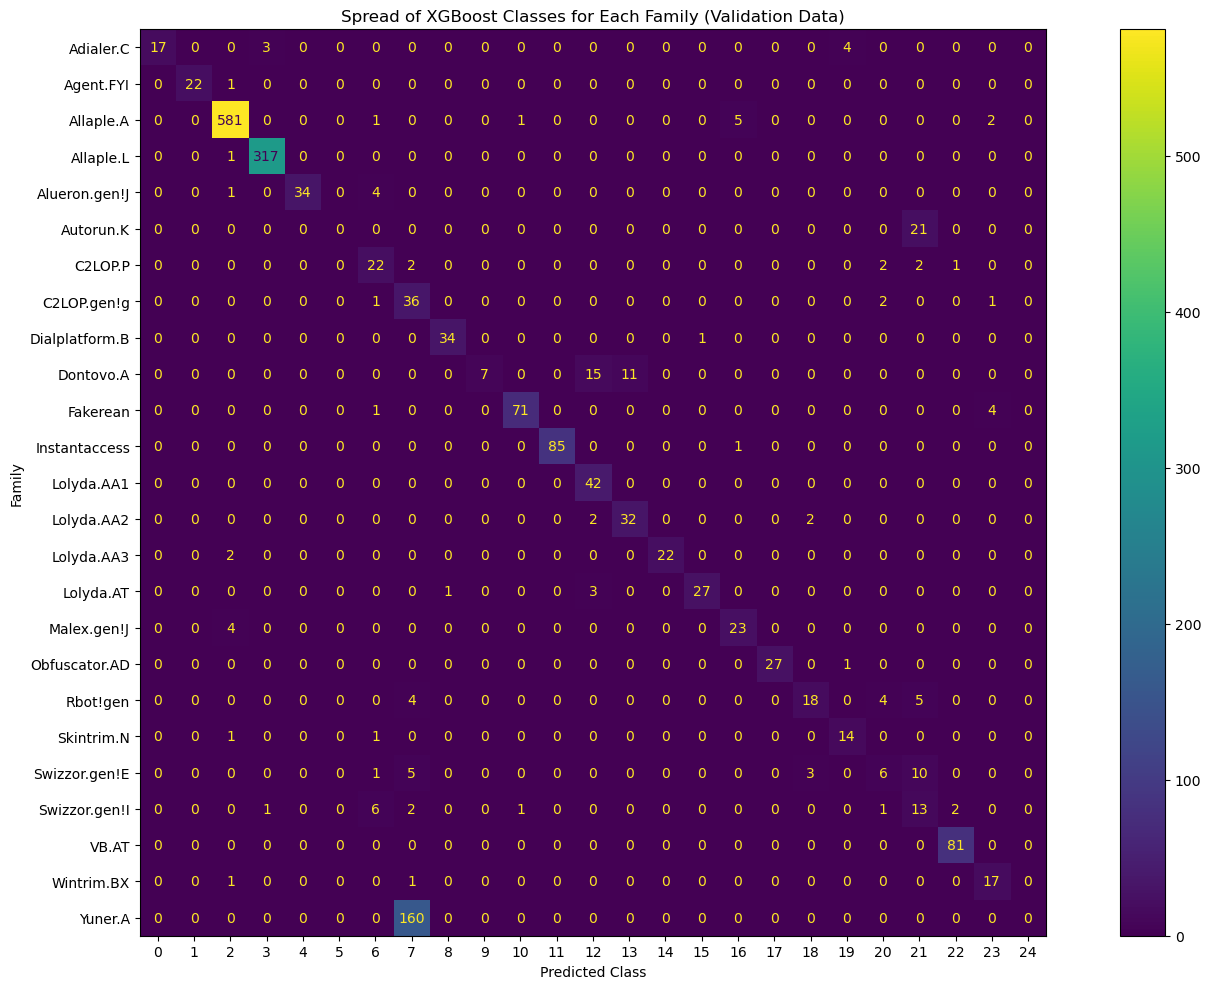

In [81]:
xgb_val_matrix = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_val, xgb_val_preds))

fig, ax = plt.subplots(figsize=(15,10))
xgb_val_matrix.plot(ax=ax) 
ax.set_title("Spread of XGBoost Classes for Each Family (Validation Data)")
ax.set_ylabel("Family")
ax.set_xlabel("Predicted Class")
ax.set_yticks(class_index_reference["True Family Index"], class_index_reference["True Family Name"])
fig.tight_layout()
fig.savefig("results/xgb_val_cm.png")

## Precision, Recall, and F1 Score for the XGB Classifier

In [82]:
xgb_metrics = pd.DataFrame({'Precision': [precision_score(xgb_train_preds, y_train, average="macro"), 
                                          precision_score(xgb_val_preds, y_val, average="macro")], 
                            'Recall': [recall_score(xgb_train_preds, y_train, average="macro"), 
                                       recall_score(xgb_val_preds, y_val, average="macro")],
                            'F1 Score': [f1_score(xgb_train_preds, y_train, average="macro"),
                                         f1_score(xgb_val_preds, y_val, average="macro")]}).rename(index = {0: 'Training', 1: 'Validation'})
xgb_metrics

/Users/catherinestanton/micromamba/envs/cs109b/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision    Recall  F1 Score
Training     0.998948  0.983929  0.990743
Validation   0.754642  0.748199  0.724270

In [83]:
# calculate XGB Metrics leaving out Yuner.A
X_train_excl = train_df[train_df['label'] != 24].drop(["label", "weight"], axis=1)
y_train_excl = y_train[y_train != 24]
X_val_excl = val_df[val_df['label'] != 24].drop(["label"], axis=1)
y_val_excl = y_val[y_val != 24]

xgb_excl = xgb.XGBClassifier(tree_method = "hist", max_depth=15, n_estimators=15).fit(X_train_excl, y_train_excl)
xgb_excl_preds = xgb_excl.predict(X_train_excl)
xgb_excl_val_preds = xgb_excl.predict(X_val_excl)

xgb_train_score_excl = metrics.accuracy_score(xgb_excl_preds, y_train_excl)
xgb_val_score_excl = metrics.accuracy_score(xgb_excl_val_preds, y_val_excl)
xgb_train_score_excl, xgb_val_score_excl

(1.0, 0.9705882352941176)

In [84]:
xgb_metrics_excl = pd.DataFrame({'Precision': [precision_score(xgb_excl_preds, y_train_excl, average="macro"), 
                                          precision_score(xgb_excl_val_preds, y_val_excl, average="macro")], 
                            'Recall': [recall_score(xgb_excl_preds, y_train_excl, average="macro"), 
                                       recall_score(xgb_excl_val_preds, y_val_excl, average="macro")],
                            'F1 Score': [f1_score(xgb_excl_preds, y_train_excl, average="macro"),
                                         f1_score(xgb_excl_val_preds, y_val_excl, average="macro")]}).rename(index = {0: 'Training', 1: 'Validation'})
xgb_metrics_excl

Precision    Recall  F1 Score
Training     1.000000  1.000000  1.000000
Validation   0.930398  0.934366  0.931068

# Aggregate Model Predictions

In [85]:
all_train_preds = pd.DataFrame({"KNN Preds": knn_train_preds,
                                "Random Forest Preds": rf_train_preds,
                                "SVM Preds": svm_train_preds,
                                "XGB Preds": xgb_train_preds})
all_val_preds = pd.DataFrame({"KNN Preds": knn_val_preds,
                              "Random Forest Preds": rf_val_preds,
                              "SVM Preds": svm_val_preds,
                              "XGB Preds": xgb_val_preds})

all_train_preds['Mode Pred'] = stats.mode(all_train_preds, axis=1)[0]
all_val_preds['Mode Pred'] = stats.mode(all_val_preds, axis=1)[0]
all_train_preds

/var/folders/rg/snrjx98x13g1mvj217brwj9m0000gn/T/ipykernel_39188/921378398.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  all_train_preds['Mode Pred'] = stats.mode(all_train_preds, axis=1)[0]
/var/folders/rg/snrjx98x13g1mvj217brwj9m0000gn/T/ipykernel_39188/921378398.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accep

KNN Preds  Random Forest Preds  SVM Preds  XGB Preds  Mode Pred
0             3                    3          3          3          3
1            14                   14         14         14         14
2            17                   17         17         17         17
3             2                    2          2          2          2
4             3                    3          3          3          3
...         ...                  ...        ...        ...        ...
7481          2                    2          2          2          2
7482         24                   24         24         24         24
7483         22                   22         22         22         22
7484         11                   11         11         11         11
7485          2                    2          2          2          2

[7486 rows x 5 columns]

In [86]:
all_val_preds

KNN Preds  Random Forest Preds  SVM Preds  XGB Preds  Mode Pred
0             2                    2          2          2          2
1            11                   11         11         11         11
2            22                   22         22         22         22
3            12                   12         12         12         12
4            24                   24         24          7         24
...         ...                  ...        ...        ...        ...
1855          2                    2         16          2          2
1856         24                   24         24          7         24
1857         11                   11         11         11         11
1858         17                   17         17         17         17
1859          2                    2          2          2          2

[1860 rows x 5 columns]

In [87]:
# calculate the proportion of observations for which all 4 models yielded the same prediction
ctr = 0
all_points = pd.concat([all_train_preds, all_val_preds])
for i in range(len(all_points)):
    if ((all_points['KNN Preds'].iloc[i] == all_points['Random Forest Preds'].iloc[i]) & 
        (all_points['Random Forest Preds'].iloc[i] == all_points['SVM Preds'].iloc[i]) & 
        (all_points['SVM Preds'].iloc[i] == all_points['XGB Preds'].iloc[i])):
        ctr += 1

# proportion of rows in which the identified families are all the same
ctr / len(all_points)

0.9105499679007062

In [88]:
# proportion of observations for which 3 models yield the same thing
ctr_2 = 0
for i in range(len(all_points)):
    if (((all_points['KNN Preds'].iloc[i] == all_points['Random Forest Preds'].iloc[i]) & (all_points['Random Forest Preds'].iloc[i] == all_points['SVM Preds'].iloc[i])) |
        ((all_points['KNN Preds'].iloc[i] == all_points['Random Forest Preds'].iloc[i]) & (all_points['Random Forest Preds'].iloc[i] == all_points['XGB Preds'].iloc[i])) |
        ((all_points['KNN Preds'].iloc[i] == all_points['SVM Preds'].iloc[i]) & (all_points['SVM Preds'].iloc[i] == all_points['XGB Preds'].iloc[i])) |
        ((all_points['Random Forest Preds'].iloc[i] == all_points['SVM Preds'].iloc[i]) & (all_points['SVM Preds'].iloc[i] == all_points['XGB Preds'].iloc[i]))):
        ctr_2 += 1
        
ctr_2 / len(all_points)

0.9781724802054355

## Compute Accuracy Scores for the Aggregate Predictions

In [89]:
agg_train_accuracy = metrics.accuracy_score(all_train_preds['Mode Pred'], y_train)
agg_val_accuracy = metrics.accuracy_score(all_val_preds['Mode Pred'], y_val)
agg_train_accuracy, agg_val_accuracy

(0.9866417312316323, 0.9543010752688172)

In [90]:
agg_metrics =  pd.DataFrame({'Precision': [precision_score(all_train_preds['Mode Pred'], y_train, average="macro"), 
                                           precision_score(all_val_preds['Mode Pred'], y_val, average="macro")], 
                             'Recall': [recall_score(all_train_preds['Mode Pred'], y_train, average="macro"), 
                                        recall_score(all_val_preds['Mode Pred'], y_val, average="macro")],
                             'F1 Score': [f1_score(all_train_preds['Mode Pred'], y_train, average="macro"),
                                          f1_score(all_val_preds['Mode Pred'], y_val, average="macro")]}).rename(index = {0: 'Training', 1: 'Validation'})
agg_metrics

Precision    Recall  F1 Score
Training     0.967411  0.973538  0.969440
Validation   0.882237  0.896742  0.885463

## Aggregate Open Set Model Predictions

In [91]:
all_os_train_preds = pd.DataFrame({"KNN Preds": os_knn_preds_train,
                                   "Random Forest Preds": os_rf_preds_train,
                                   "SVM Preds": os_svm_preds_train,
                                   "XGB Preds": os_xgb_preds_train})
all_os_val_preds = pd.DataFrame({"KNN Preds": os_knn_preds_val,
                                 "Random Forest Preds": os_rf_preds_val,
                                 "SVM Preds": os_svm_preds_val,
                                 "XGB Preds": os_xgb_preds_val})

all_os_train_preds['Mode Pred'] = stats.mode(all_os_train_preds, axis=1)[0]
all_os_val_preds['Mode Pred'] = stats.mode(all_os_val_preds, axis=1)[0]
all_os_train_preds

/var/folders/rg/snrjx98x13g1mvj217brwj9m0000gn/T/ipykernel_39188/2161512620.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  all_os_train_preds['Mode Pred'] = stats.mode(all_os_train_preds, axis=1)[0]
/var/folders/rg/snrjx98x13g1mvj217brwj9m0000gn/T/ipykernel_39188/2161512620.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  all_os_train_preds['Mode Pred'] = stats.mode(all_os_train_preds, axis=1)[0]
/var/folders/rg/snrjx98x

KNN Preds Random Forest Preds SVM Preds XGB Preds Mode Pred
0            3                   3         3         3         3
1           14                  14        14        14        14
2           17                  17        17        17        17
3            2                   2         2   unknown         2
4            3                   3         3         3         3
...        ...                 ...       ...       ...       ...
7481         2                   2         2         2         2
7482        24                  24        24        24        24
7483        22                  22        22        22        22
7484        11                  11        11        11        11
7485         2                   2         2         2         2

[7486 rows x 5 columns]

In [92]:
all_os_val_preds

KNN Preds Random Forest Preds SVM Preds XGB Preds Mode Pred
0            2                   2         2         2         2
1           11                  11        11        11        11
2           22                  22   unknown        22        22
3           12                  12        12        12        12
4           24                  24        24   unknown        24
...        ...                 ...       ...       ...       ...
1855         2                   2        16         2         2
1856        24                  24        24   unknown        24
1857        11                  11        11        11        11
1858        17                  17        17        17        17
1859         2                   2         2         2         2

[1860 rows x 5 columns]

In [93]:
# Percent Unknown in OS Preds
pct_unknown_train = len(all_os_train_preds[all_os_train_preds['Mode Pred'] == "unknown"]) / 7486
pct_unknown_val = len(all_os_val_preds[all_os_val_preds['Mode Pred'] == "unknown"]) / 1860
pct_unknown_train, pct_unknown_val

(0.05463531926262356, 0.07419354838709677)

# Load and Explore the APT Dataset

In [94]:
# Read in the data labeled by APT Group
test_generator = ImageDataGenerator()

apt_data = test_generator.flow_from_directory(directory="Advanced_Persistent_Threat_Classified_Dataset/APTs",
                                              color_mode="grayscale", target_size=(224,224), class_mode="categorical",
                                              classes=['APT_1', 'APT_10', 'APT_19', 'APT_21', 'APT_28', 'APT_29', 'APT_30', 'coinhive', 
                                                       'Dark_Hotel', 'emotet', 'Energetic_Bear', 'Equation_Group', 'fareit', 'flystudio',
                                                       'gafgyt', 'gandcrab', 'Gorgon_Group', 'icedid', 'lamer', 'mepaow', 'mirai', 'ramnit',
                                                       'razy', 'Winnti'])

Found 8861 images belonging to 24 classes.


In [95]:
# os.remove("Advanced_Persistent_Threat_Classified_Dataset/APTs/.DS_Store")

In [96]:
# Summary of Image Sizes
def get_image_summary_rev(directory):
    ctr = 0
    max_size = 0
    min_size = 0
    # set up a database to store image size and family name
    db = pd.DataFrame(columns=['width', 'height', 'family'])
    for folder in os.listdir(directory):
        if os.path.exists(f"{directory}/{folder}/.DS_Store"):
            os.remove(f"{directory}/{folder}/.DS_Store")  
        for group in os.listdir(f"{directory}/{folder}"):
            if os.path.exists(f"{directory}/{folder}/{group}/.DS_Store"):
                os.remove(f"{directory}/{folder}/{group}/.DS_Store")            
            directory_full = f"{directory}/{folder}/{group}"
            for filename in os.listdir(directory_full):
                ctr += 1
                if filename.lower().endswith(('.png')):
                    try:
                        with Image.open(os.path.join(directory_full, filename)) as img:
                            width, height = img.size
                            db.loc[ctr] = [width, height, folder]
                            max_size = max(max_size, width * height)
                            min_size_plc = width * height
                            min_size = min(min_size_plc, width * height)
                    except Exception as e:
                        print(f"Error processing {filename}: {e}")
    return max_size, min_size, ctr, db

directory_path = "Advanced_Persistent_Threat_Classified_Dataset/APTs"
max_size_rev, min_size_rev, num_rev, db_rev = get_image_summary_rev(directory_path)
print(f"Maximum image size: {max_size_rev} \nNumber of Images: {num_rev} \nLargest Image Info: {db_rev.loc[db_rev.width * db_rev.height == max_size_rev].family}")
print(f"Minimum image size: {min_size_rev} \nSmallest Image Info: {db.loc[db.width * db.height == min_size_rev].family}")

Maximum image size: 5773312 
Number of Images: 8860 
Largest Image Info: 6315    Gorgon_Group
Name: family, dtype: object
Minimum image size: 11025 
Smallest Image Info: Series([], Name: family, dtype: object)


In [97]:
db_rev_groups = db_rev[~db_rev['family'].isin(['coinhive', 'emotet', 'fareit', 'flystudio', 'gafgyt', 'gandcrab', 'icedid', 'lamer', 'mepaow', 'mirai', 'ramnit', 'razy'])]
db_rev_groups

width  height        family
260     512     871        Winnti
261     512     871        Winnti
262     512     871        Winnti
263     512     773        Winnti
264     512     773        Winnti
...     ...     ...           ...
6445    384     299  Gorgon_Group
6446    256     389  Gorgon_Group
6447    384     281  Gorgon_Group
6448    768     791  Gorgon_Group
6449    768     765  Gorgon_Group

[1942 rows x 3 columns]

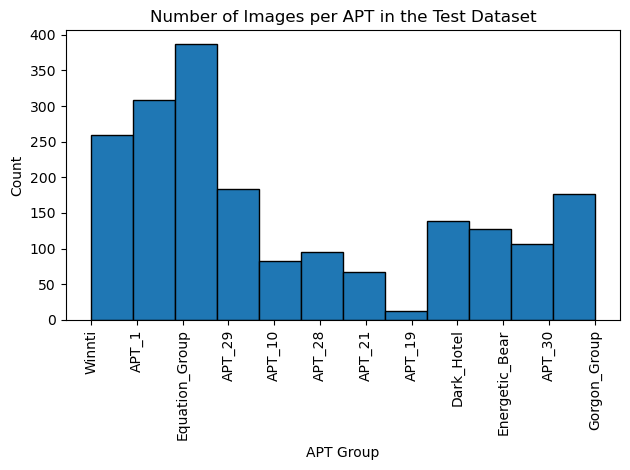

In [98]:
# Number of samples per APT group
plt.hist(db_rev_groups[["family"]], bins=12, edgecolor='black')
plt.title("Number of Images per APT in the Test Dataset")
plt.xlabel("APT Group")
plt.ylabel("Count")
plt.tick_params(axis='x', rotation=90)
plt.tight_layout()

plt.savefig("results/apt_group_dist.png")

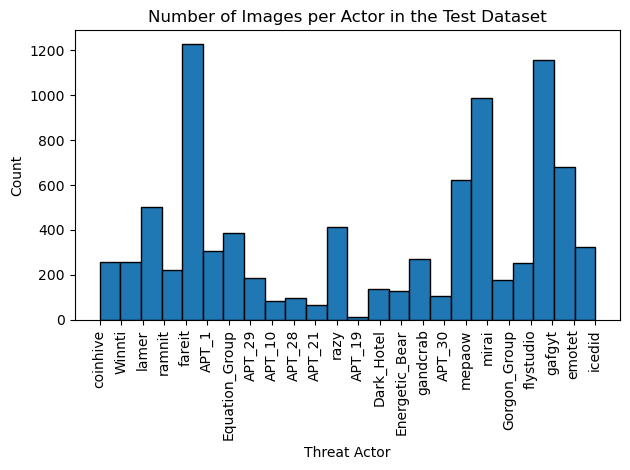

In [99]:
# Number of samples per group
plt.hist(db_rev[["family"]], bins=24, edgecolor='black')
plt.title("Number of Images per Actor in the Test Dataset")
plt.xlabel("Threat Actor")
plt.ylabel("Count")
plt.tick_params(axis='x', rotation=90)
plt.tight_layout()

plt.savefig("results/apt_group_strain_dist.png")

In [100]:
# feature extraction of APT data using VGG16
i = 0
apt_sample_features = []
apt_labels = []
while i < len(apt_data):
    # save true batch labels
    idxs = []
    for labels in apt_data[i][1]:
        for j in range(0, 24):
            if labels[j]==1:
                idxs.append(j)
                continue
    apt_labels.append(idxs)
    # extract features
    batch = apt_data[i][0]
    apt_sample_features.append(feature_extraction(batch, vgg16_model))
    i += 1

## Dimensionality Reduction of the Sample Features

In [101]:
# PCA Prep
apt_dfs_list = [pd.DataFrame([arr[0].tolist() for arr in apt_sample_features[i]]) for i in range(len(apt_sample_features))]

# Add a column to each dataframe with the true malware family
for i in range(len(apt_dfs_list)):
    apt_dfs_list[i]['group'] = apt_labels[i]
    
# concatenate all arrays in sample_features_arr into one dataframe
apt_df = pd.concat(apt_dfs_list, ignore_index=True)

# apt_df should show all of the features for each image in the test set, with a group label (numeric) appended to the end
# will remove this label for performing PCA
apt_df.head()

0         1         2         3    4         5         6    7    8  \
0  0.000000  2.125786  0.471793  3.406258  0.0  0.000000  4.274114  0.0  0.0   
1  0.000000  2.315740  0.000000  0.000000  0.0  0.019667  0.663070  0.0  0.0   
2  0.000000  1.147956  0.000000  0.000000  0.0  0.000000  2.144953  0.0  0.0   
3  0.000000  4.740972  0.000000  0.919236  0.0  0.000000  0.000000  0.0  0.0   
4  0.073456  4.148830  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0   

     9  ...      4087  4088      4089  4090      4091      4092      4093  \
0  0.0  ...  0.243725   0.0  0.000000   0.0  0.000000  1.563452  0.009870   
1  0.0  ...  6.653596   0.0  0.415243   0.0  0.446041  0.919529  0.007736   
2  0.0  ...  0.376725   0.0  3.500506   0.0  0.000000  0.000000  0.000000   
3  0.0  ...  0.000000   0.0  0.326255   0.0  6.130049  0.000000  0.000000   
4  0.0  ...  5.004805   0.0  0.000000   0.0  2.489232  1.009101  0.000000   

   4094  4095  group  
0   0.0   0.0     14  
1   0.0   0.0     19  
2   0.0   0.0     11  
3   0.0   0.0      5  
4   0.0   0.0     12  

[5 rows x 4097 columns]

In [102]:
apt_pca = PCA(n_components = 4)
# fit new PCA to new DF for apt_data
apt_pca = apt_pca.fit_transform(apt_df.drop('group', axis=1))

Start storing predictions (only, not features) in a dataframe.

In [103]:
apt_preds = pd.DataFrame({"KNN Preds": knn_model.predict(apt_pca),
                          "RF Preds": rf_model.predict(apt_pca),
                          "SVM Preds": svm_classifier.predict(apt_pca),
                          "XGB Preds": xgb_model.predict(apt_pca),
                          "KNN OS Preds": open_set_pred(knn_model, apt_pca, 0.75),
                          "RF OS Preds": open_set_pred(rf_model, apt_pca, 0.75),
                          "SVM OS Preds": open_set_pred(svm_classifier, apt_pca, 0.75),
                          "XGB OS Preds": open_set_pred(xgb_model, apt_pca, 0.75)})

Similar to class_index_reference, create a dataframe for connecting numeric indices to APT group names

In [104]:
group_index_reference = pd.DataFrame({'group': range(0, 24), 'APT Name': ['APT_1', 'APT_10', 'APT_19', 'APT_21', 'APT_28', 'APT_29', 'APT_30', 'coinhive', 'Dark_Hotel', 
                                                                          'emotet', 'Energetic_Bear', 'Equation_Group', 'fareit', 'flystudio', 'gafgyt', 'gandcrab', 
                                                                          'Gorgon_Group', 'icedid', 'lamer', 'mepaow', 'mirai', 'ramnit', 'razy', 'Winnti']})

## Start Aggregating Preds (Mode)

In [105]:
apt_preds['Agg Preds'] = stats.mode(apt_preds[["KNN Preds", "RF Preds", "SVM Preds", "XGB Preds"]], axis=1, keepdims=True)[0]
apt_preds['Agg OS Preds'] = stats.mode(apt_preds[["KNN OS Preds", "RF OS Preds", "SVM OS Preds", "XGB OS Preds"]], axis=1, keepdims=True)[0]
apt_preds

/var/folders/rg/snrjx98x13g1mvj217brwj9m0000gn/T/ipykernel_39188/2180365340.py:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  apt_preds['Agg OS Preds'] = stats.mode(apt_preds[["KNN OS Preds", "RF OS Preds", "SVM OS Preds", "XGB OS Preds"]], axis=1, keepdims=True)[0]


KNN Preds  RF Preds  SVM Preds  XGB Preds KNN OS Preds RF OS Preds  \
0             7         7         23          7            7     unknown   
1             1         1         15         10            1     unknown   
2            22        22         22         22           22          22   
3             6        18          6         21      unknown     unknown   
4             1         2          2          2            1     unknown   
...         ...       ...        ...        ...          ...         ...   
8856          3         2          3         16      unknown     unknown   
8857          7        21          7          7      unknown     unknown   
8858          2        11         11         11            2     unknown   
8859          3         2          3          2            3     unknown   
8860          1         1          1         10            1     unknown   

     SVM OS Preds XGB OS Preds  Agg Preds Agg OS Preds  
0         unknown            7          7            7  
1         unknown      unknown          1      unknown  
2              22           22         22           22  
3         unknown      unknown          6      unknown  
4         unknown      unknown          2      unknown  
...           ...          ...        ...          ...  
8856      unknown      unknown          3      unknown  
8857            7            7          7      unknown  
8858      unknown      unknown         11      unknown  
8859            3      unknown          2            3  
8860      unknown      unknown          1      unknown  

[8861 rows x 10 columns]

In [106]:
# Calculate the percent unknown
len(apt_preds[apt_preds['Agg OS Preds'] == "unknown"]) / 8861

0.6045593048188692

In [107]:
# Add a column for APT Group
apt_preds['group'] = apt_df['group']

In [108]:
apt_preds = pd.merge(apt_preds, group_index_reference, on='group', how='left')
apt_preds = pd.merge(apt_preds, class_index_reference, left_on='Agg Preds', right_on='True Family Index', how='left')
apt_preds

KNN Preds  RF Preds  SVM Preds  XGB Preds KNN OS Preds RF OS Preds  \
0             7         7         23          7            7     unknown   
1             1         1         15         10            1     unknown   
2            22        22         22         22           22          22   
3             6        18          6         21      unknown     unknown   
4             1         2          2          2            1     unknown   
...         ...       ...        ...        ...          ...         ...   
8856          3         2          3         16      unknown     unknown   
8857          7        21          7          7      unknown     unknown   
8858          2        11         11         11            2     unknown   
8859          3         2          3          2            3     unknown   
8860          1         1          1         10            1     unknown   

     SVM OS Preds XGB OS Preds  Agg Preds Agg OS Preds  group        APT Name  \
0         unknown            7          7            7     14          gafgyt   
1         unknown      unknown          1      unknown     19          mepaow   
2              22           22         22           22     11  Equation_Group   
3         unknown      unknown          6      unknown      5          APT_29   
4         unknown      unknown          2      unknown     12          fareit   
...           ...          ...        ...          ...    ...             ...   
8856      unknown      unknown          3      unknown     12          fareit   
8857            7            7          7      unknown     22            razy   
8858      unknown      unknown         11      unknown     12          fareit   
8859            3      unknown          2            3     14          gafgyt   
8860      unknown      unknown          1      unknown     20           mirai   

      True Family Index True Family Name  
0                     7      C2LOP.gen!g  
1                     1        Agent.FYI  
2                    22            VB.AT  
3                     6          C2LOP.P  
4                     2        Allaple.A  
...                 ...              ...  
8856                  3        Allaple.L  
8857                  7      C2LOP.gen!g  
8858                 11    Instantaccess  
8859                  2        Allaple.A  
8860                  1        Agent.FYI  

[8861 rows x 14 columns]

## Plot the distributions of Malware Families Used by APT Group

In [109]:
all_families = ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 
                'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 
                'VB.AT', 'Wintrim.BX', 'Yuner.A', 'unknown']

family_counts_agg = apt_preds[["APT Name", "True Family Name"]].groupby(["APT Name"]).value_counts().reset_index().rename(columns={0: "count"})
# get DF ready for plotting based on REGULAR predictions
for group in np.unique(apt_preds[["APT Name"]]):
    subset = apt_preds[apt_preds['APT Name']==group]
    for family in all_families:
        if (family in np.unique(subset[['True Family Name']])) == False:
            family_counts_agg = pd.concat([family_counts_agg, pd.DataFrame({"APT Name": [group], "True Family Name": [family], "count": [0]})], ignore_index=True)
            
family_counts_agg = family_counts_agg.sort_values(["APT Name", "True Family Name"])

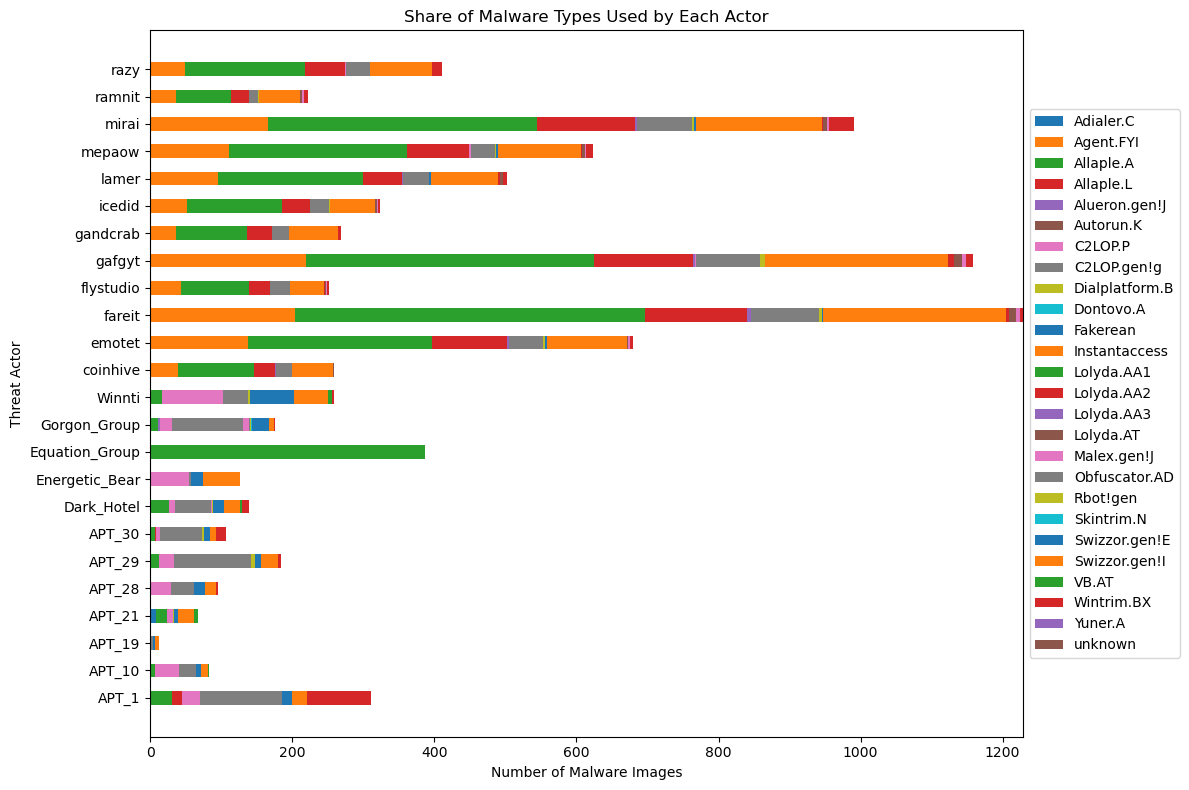

In [110]:
# Aggregate family distribution for interpretation
left = [0] * 24
height = 0.5

plt.figure(figsize=(12, 8))
for family in all_families:
    plt.barh(np.unique(family_counts_agg[['APT Name']]), width=family_counts_agg.loc[family_counts_agg["True Family Name"]==family]["count"], height=height, left=left)
    left = [x + y for x, y in zip(family_counts_agg.loc[family_counts_agg["True Family Name"]==family]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Threat Actor")
plt.legend(all_families, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used by Each Actor")
plt.tight_layout()
plt.savefig("results/agg_family_dists.png")

In [111]:
# Repeat the above based on Open Set Prediction
apt_preds['True Open Set Family Name'] = [all_families[i] if i!="unknown" else "unknown" for i in apt_preds["Agg OS Preds"]]

os_family_counts_agg = apt_preds[["APT Name", "True Open Set Family Name"]].groupby(["APT Name"]).value_counts().reset_index().rename(columns={0: "count"})
# get DF ready for plotting based on REGULAR predictions
for group in np.unique(apt_preds[["APT Name"]]):
    subset = apt_preds[apt_preds['APT Name']==group]
    for family in all_families:
        if (family in np.unique(subset[['True Open Set Family Name']])) == False:
            os_family_counts_agg = pd.concat([os_family_counts_agg, pd.DataFrame({"APT Name": [group], "True Open Set Family Name": [family], "count": [0]})], ignore_index=True)
            
os_family_counts_agg = os_family_counts_agg.sort_values(["APT Name", "True Open Set Family Name"])

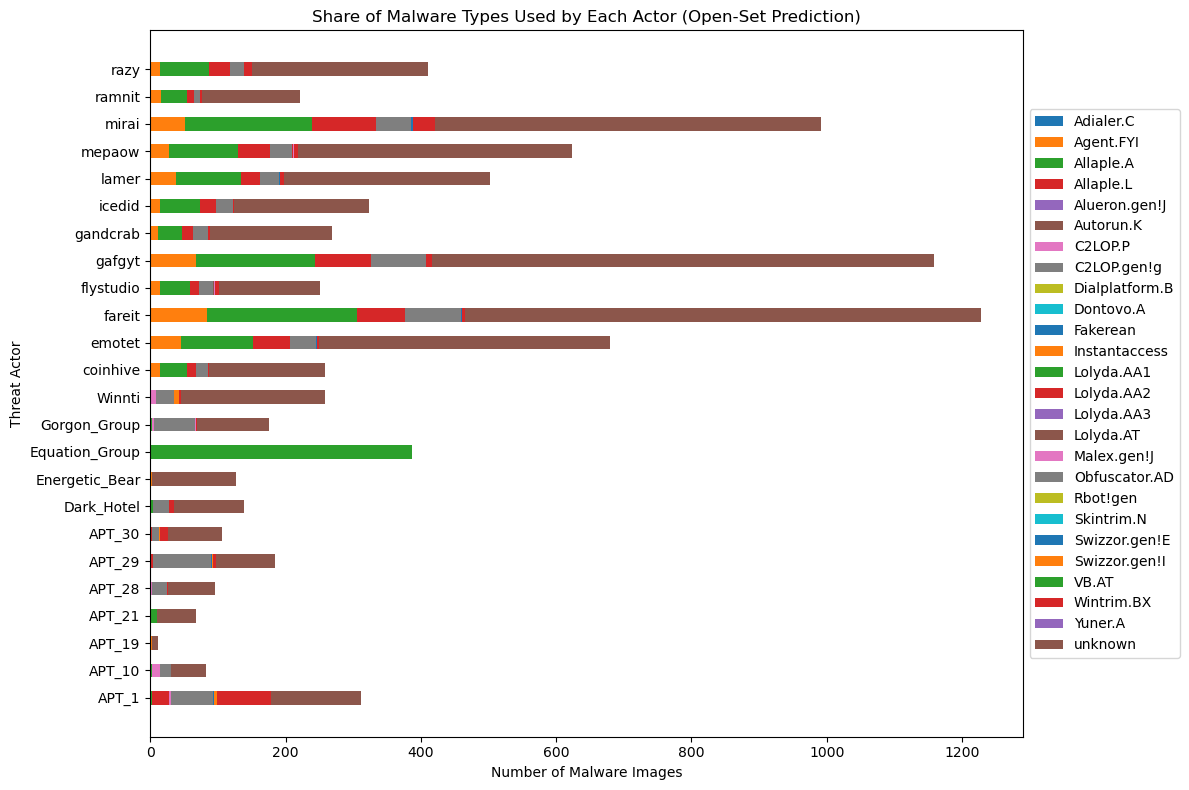

In [112]:
left = [0] * 24
height = 0.5

plt.figure(figsize=(12, 8))
for family in all_families:
    plt.barh(np.unique(os_family_counts_agg[['APT Name']]), width=os_family_counts_agg.loc[os_family_counts_agg["True Open Set Family Name"]==family]["count"], height=height, left=left)
    left = [x + y for x, y in zip(os_family_counts_agg.loc[os_family_counts_agg["True Open Set Family Name"]==family]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Threat Actor")
plt.legend(all_families, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used by Each Actor (Open-Set Prediction)")
plt.tight_layout()
plt.savefig("results/agg_family_dists_open_set.png")

### Examine Proportions for Prediction and Open-Set Prediction

In [113]:
agg_proportions = pd.DataFrame({"APT Name": [], "Agg Family": [], "proportion": []})
for group in np.unique(family_counts_agg[['APT Name']]):
    sub = family_counts_agg[family_counts_agg['APT Name'] == group].reset_index()
    for i in range(len(sub)):
        agg_proportions = pd.concat([agg_proportions, pd.DataFrame({"APT Name": [group], "Agg Family": [family_counts_agg['True Family Name'].iloc[i]], 
                                                                    "proportion": [sub['count'].iloc[i] / sum(sub['count'])]})])

In [114]:
# print proportions for each APT Group
for family in np.unique(agg_proportions['APT Name']):
    df = agg_proportions[agg_proportions['proportion'] != 0].sort_values(by=["APT Name", "proportion"], ascending=False)
    print(df[df["APT Name"] == family])
    print("-----------------------------------------")

  APT Name     Agg Family  proportion
0    APT_1    C2LOP.gen!g    0.369775
0    APT_1     Wintrim.BX    0.289389
0    APT_1      Allaple.A    0.099678
0    APT_1        C2LOP.P    0.083601
0    APT_1  Swizzor.gen!I    0.067524
0    APT_1  Swizzor.gen!E    0.045016
0    APT_1      Allaple.L    0.041801
0    APT_1    Malex.gen!J    0.003215
-----------------------------------------
  APT Name     Agg Family  proportion
0   APT_10        C2LOP.P    0.414634
0   APT_10    C2LOP.gen!g    0.292683
0   APT_10  Swizzor.gen!I    0.109756
0   APT_10  Swizzor.gen!E    0.097561
0   APT_10      Allaple.A    0.073171
0   APT_10          VB.AT    0.012195
-----------------------------------------
  APT Name     Agg Family  proportion
0   APT_19  Swizzor.gen!I    0.500000
0   APT_19    C2LOP.gen!g    0.250000
0   APT_19  Swizzor.gen!E    0.166667
0   APT_19        C2LOP.P    0.083333
-----------------------------------------
  APT Name     Agg Family  proportion
0   APT_21  Swizzor.gen!I    0.328358


In [115]:
os_agg_proportions = pd.DataFrame({"APT Name": [], "OS Agg Family": [], "proportion": []})
for group in np.unique(os_family_counts_agg[['APT Name']]):
    sub = os_family_counts_agg[os_family_counts_agg['APT Name'] == group].reset_index()
    for i in range(len(sub)):
        os_agg_proportions = pd.concat([os_agg_proportions, pd.DataFrame({"APT Name": [group], "OS Agg Family": [os_family_counts_agg['True Open Set Family Name'].iloc[i]], 
                                                                 "proportion": [sub['count'].iloc[i] / sum(sub['count'])]})])

In [116]:
# print Open-Set proportions for each APT Group
for family in np.unique(agg_proportions['APT Name']):
    df = os_agg_proportions[os_agg_proportions['proportion'] != 0].sort_values(by=["APT Name", "proportion"], ascending=False)
    print(df[df["APT Name"] == family])
    print("-----------------------------------------")

  APT Name  OS Agg Family  proportion
0    APT_1        unknown    0.427653
0    APT_1     Wintrim.BX    0.257235
0    APT_1    C2LOP.gen!g    0.202572
0    APT_1      Allaple.L    0.080386
0    APT_1  Swizzor.gen!I    0.012862
0    APT_1      Allaple.A    0.009646
0    APT_1        C2LOP.P    0.006431
0    APT_1  Swizzor.gen!E    0.003215
-----------------------------------------
  APT Name OS Agg Family  proportion
0   APT_10       unknown    0.634146
0   APT_10   C2LOP.gen!g    0.195122
0   APT_10       C2LOP.P    0.134146
0   APT_10     Allaple.A    0.036585
-----------------------------------------
  APT Name  OS Agg Family  proportion
0   APT_19        unknown    0.833333
0   APT_19    C2LOP.gen!g    0.083333
0   APT_19  Swizzor.gen!I    0.083333
-----------------------------------------
  APT Name  OS Agg Family  proportion
0   APT_21        unknown    0.850746
0   APT_21      Allaple.A    0.074627
0   APT_21          VB.AT    0.059701
0   APT_21  Swizzor.gen!I    0.014925
-----

## Graph the Distribution of Classes Predicted for Each Model
### (For Appendices)

### KNN Classes Predicted

In [117]:
family_counts_knn = pd.merge(apt_preds[['APT Name', 'KNN Preds']], class_index_reference, how='left', left_on='KNN Preds', right_on='True Family Index')
family_counts_knn = family_counts_knn[['APT Name', "True Family Name"]].groupby(["APT Name"]).value_counts().reset_index().rename(columns={0: "count"})
family_counts_knn

APT Name True Family Name  count
0      APT_1       Wintrim.BX    106
1      APT_1      C2LOP.gen!g     94
2      APT_1        Allaple.L     29
3      APT_1    Swizzor.gen!I     25
4      APT_1    Swizzor.gen!E     23
..       ...              ...    ...
189     razy       Wintrim.BX     17
190     razy       Lolyda.AA2      5
191     razy          C2LOP.P      2
192     razy         Fakerean      1
193     razy    Swizzor.gen!E      1

[194 rows x 3 columns]

In [118]:
all_families = ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 
                'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 
                'VB.AT', 'Wintrim.BX', 'Yuner.A']

for group in np.unique(family_counts_knn[['APT Name']]):
    subset = family_counts_knn[family_counts_knn['APT Name']==group]
    for family in all_families:
        if (family in np.unique(subset[['True Family Name']])) == False:
            family_counts_knn = pd.concat([family_counts_knn, pd.DataFrame({"APT Name": [group], "True Family Name": [family], "count": [0]})], ignore_index=True)
            
family_counts_knn = family_counts_knn.sort_values(["APT Name", "True Family Name"])
family_counts_knn

APT Name True Family Name  count
194    APT_1        Adialer.C      0
195    APT_1        Agent.FYI      0
6      APT_1        Allaple.A     14
2      APT_1        Allaple.L     29
196    APT_1    Alueron.gen!J      0
..       ...              ...    ...
193     razy    Swizzor.gen!E      1
597     razy    Swizzor.gen!I      0
598     razy            VB.AT      0
189     razy       Wintrim.BX     17
599     razy          Yuner.A      0

[600 rows x 3 columns]

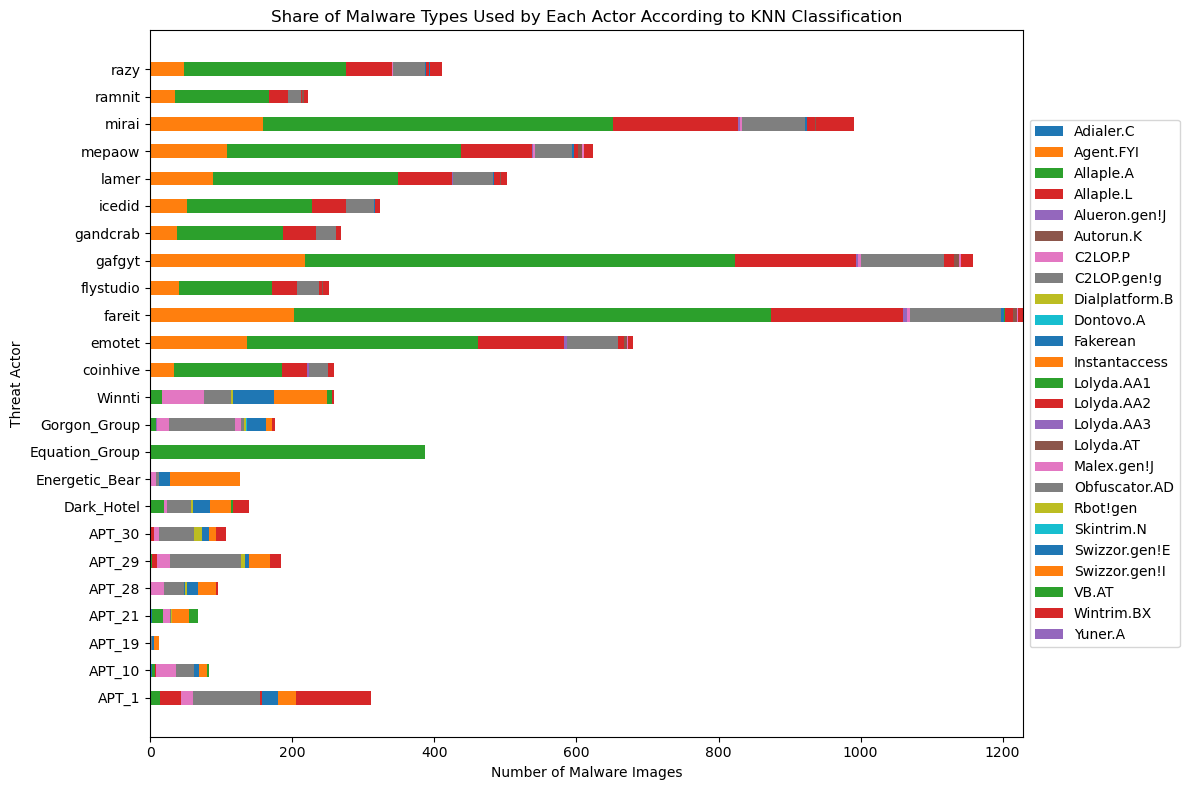

In [119]:
left = [0] * 24
height = 0.5

plt.figure(figsize=(12, 8))
for family in all_families:
    plt.barh(np.unique(family_counts_knn[['APT Name']]), width=family_counts_knn.loc[family_counts_knn["True Family Name"]==family]["count"], height=height, left=left)
    left = [x + y for x, y in zip(family_counts_knn.loc[family_counts_knn["True Family Name"]==family]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Threat Actor")
plt.legend(all_families, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used by Each Actor According to KNN Classification")
plt.tight_layout()
plt.savefig('results/knn_class_dists.png')

### Proportions Predicted by KNN

In [120]:
knn_props = pd.DataFrame({"APT Name": [], "KNN Family": [], "proportion": []})
for group in np.unique(family_counts_knn[['APT Name']]):
    sub = family_counts_knn[family_counts_knn['APT Name'] == group].reset_index()
    for i in range(len(sub)):
        knn_props = pd.concat([knn_props, pd.DataFrame({"APT Name": [group], "KNN Family": [family_counts_knn['True Family Name'].iloc[i]], 
                                                        "proportion": [sub['count'].iloc[i] / sum(sub['count'])]})])

In [121]:
# make a data frame of proportions for each APT_name
for family in np.unique(knn_props['APT Name']):
    df = knn_props[knn_props['proportion'] != 0].sort_values(by=["APT Name", "proportion"], ascending=False)
    print(df[df["APT Name"] == family])
    print("-----------------------------------------")

  APT Name     KNN Family  proportion
0    APT_1     Wintrim.BX    0.340836
0    APT_1    C2LOP.gen!g    0.302251
0    APT_1      Allaple.L    0.093248
0    APT_1  Swizzor.gen!I    0.080386
0    APT_1  Swizzor.gen!E    0.073955
0    APT_1        C2LOP.P    0.054662
0    APT_1      Allaple.A    0.045016
0    APT_1     Lolyda.AA2    0.006431
0    APT_1  Instantaccess    0.003215
-----------------------------------------
  APT Name     KNN Family  proportion
0   APT_10        C2LOP.P    0.341463
0   APT_10    C2LOP.gen!g    0.304878
0   APT_10  Swizzor.gen!I    0.134146
0   APT_10  Swizzor.gen!E    0.097561
0   APT_10      Adialer.C    0.036585
0   APT_10      Allaple.A    0.036585
0   APT_10      Allaple.L    0.024390
0   APT_10          VB.AT    0.024390
-----------------------------------------
  APT Name     KNN Family  proportion
0   APT_19  Swizzor.gen!I    0.583333
0   APT_19    C2LOP.gen!g    0.166667
0   APT_19  Swizzor.gen!E    0.166667
0   APT_19        C2LOP.P    0.083333
----

### Random Forest Classes Predicted

In [122]:
family_counts_rf = pd.merge(apt_preds[['APT Name', 'RF Preds']], class_index_reference, how='left', left_on='RF Preds', right_on='True Family Index')
family_counts_rf = family_counts_rf[['APT Name', "True Family Name"]].groupby(["APT Name"]).value_counts().reset_index().rename(columns={0: "count"})
family_counts_rf

APT Name True Family Name  count
0      APT_1      C2LOP.gen!g    101
1      APT_1       Wintrim.BX     85
2      APT_1        Allaple.A     39
3      APT_1    Swizzor.gen!I     32
4      APT_1          C2LOP.P     28
..       ...              ...    ...
235     razy       Lolyda.AA2      4
236     razy         Fakerean      3
237     razy          C2LOP.P      1
238     razy   Dialplatform.B      1
239     razy        Dontovo.A      1

[240 rows x 3 columns]

In [123]:
for group in np.unique(family_counts_rf[['APT Name']]):
    subset = family_counts_rf[family_counts_rf['APT Name']==group]
    for family in all_families:
        if (family in np.unique(subset[['True Family Name']])) == False:
            family_counts_rf = pd.concat([family_counts_rf, pd.DataFrame({"APT Name": [group], "True Family Name": [family], "count": [0]})], ignore_index=True)
            
family_counts_rf = family_counts_rf.sort_values(["APT Name", "True Family Name"])
family_counts_rf

APT Name True Family Name  count
240    APT_1        Adialer.C      0
241    APT_1        Agent.FYI      0
2      APT_1        Allaple.A     39
5      APT_1        Allaple.L     12
242    APT_1    Alueron.gen!J      0
..       ...              ...    ...
233     razy    Swizzor.gen!E      4
232     razy    Swizzor.gen!I      4
598     razy            VB.AT      0
231     razy       Wintrim.BX      6
599     razy          Yuner.A      0

[600 rows x 3 columns]

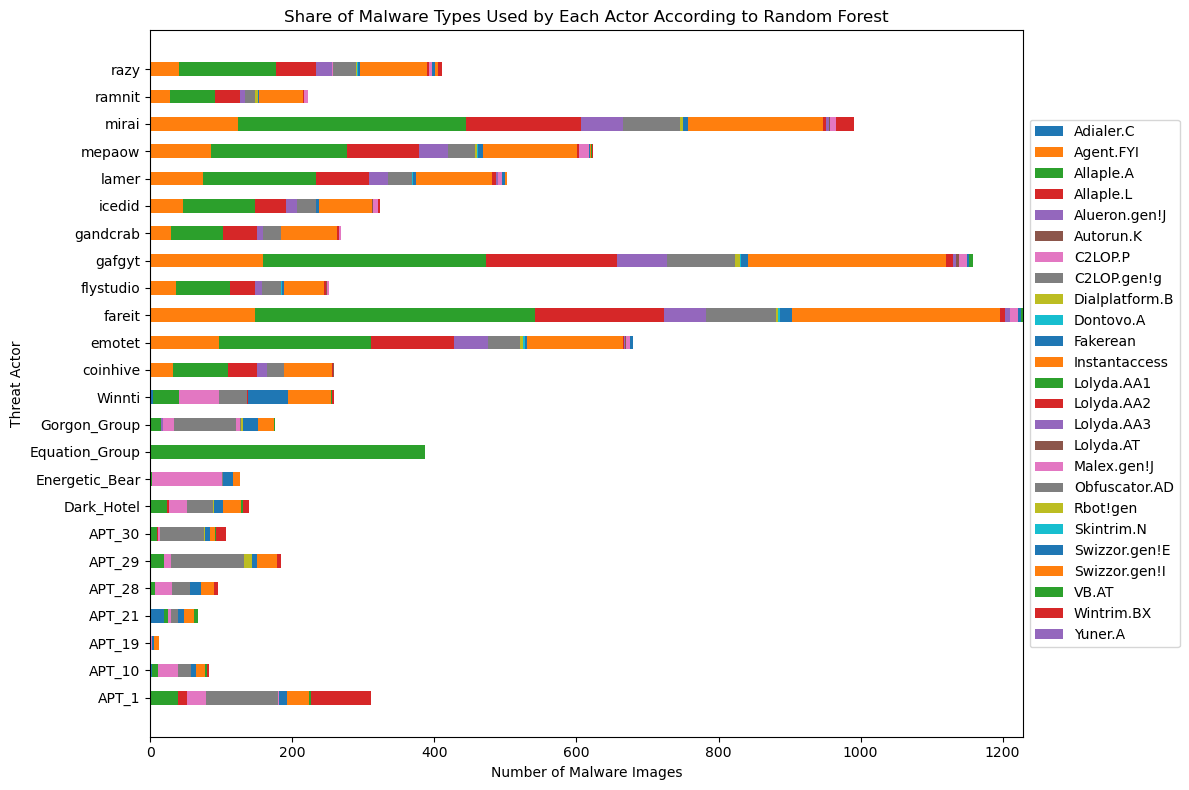

In [124]:
left = [0] * 24
height = 0.5

plt.figure(figsize=(12, 8))
for family in all_families:
    plt.barh(np.unique(family_counts_rf[['APT Name']]), width=family_counts_rf.loc[family_counts_rf["True Family Name"]==family]["count"], height=height, left=left)
    left = [x + y for x, y in zip(family_counts_rf.loc[family_counts_rf["True Family Name"]==family]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Threat Actor")
plt.legend(all_families, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used by Each Actor According to Random Forest")
plt.tight_layout()
plt.savefig('results/rf_class_dists.png')

### Proportions Predicted by Random Forest

In [125]:
rf_props = pd.DataFrame({"APT Name": [], "RF Family": [], "proportion": []})
for group in np.unique(family_counts_rf[['APT Name']]):
    sub = family_counts_rf[family_counts_rf['APT Name'] == group].reset_index()
    for i in range(len(sub)):
        rf_props = pd.concat([rf_props, pd.DataFrame({"APT Name": [group], "RF Family": [family_counts_rf['True Family Name'].iloc[i]], 
                                                      "proportion": [sub['count'].iloc[i] / sum(sub['count'])]})])

In [126]:
# make a data frame of proportions for each APT_name
for family in np.unique(rf_props['APT Name']):
    df = rf_props[rf_props['proportion'] != 0].sort_values(by=["APT Name", "proportion"], ascending=False)
    print(df[df["APT Name"] == family])
    print("-----------------------------------------")

  APT Name      RF Family  proportion
0    APT_1    C2LOP.gen!g    0.324759
0    APT_1     Wintrim.BX    0.273312
0    APT_1      Allaple.A    0.125402
0    APT_1  Swizzor.gen!I    0.102894
0    APT_1        C2LOP.P    0.090032
0    APT_1      Allaple.L    0.038585
0    APT_1  Swizzor.gen!E    0.035370
0    APT_1          VB.AT    0.006431
0    APT_1    Malex.gen!J    0.003215
-----------------------------------------
  APT Name      RF Family  proportion
0   APT_10        C2LOP.P    0.341463
0   APT_10    C2LOP.gen!g    0.231707
0   APT_10  Swizzor.gen!I    0.158537
0   APT_10      Allaple.A    0.097561
0   APT_10  Swizzor.gen!E    0.073171
0   APT_10      Adialer.C    0.036585
0   APT_10          VB.AT    0.036585
0   APT_10     Wintrim.BX    0.024390
-----------------------------------------
  APT Name      RF Family  proportion
0   APT_19  Swizzor.gen!I    0.583333
0   APT_19        C2LOP.P    0.166667
0   APT_19  Swizzor.gen!E    0.166667
0   APT_19    C2LOP.gen!g    0.083333
----

### SVM Classes Predicted

In [127]:
family_counts_svm = pd.merge(apt_preds[['APT Name', 'SVM Preds']], class_index_reference, how='left', left_on='SVM Preds', right_on='True Family Index')
family_counts_svm = family_counts_svm[['APT Name', "True Family Name"]].groupby(["APT Name"]).value_counts().reset_index().rename(columns={0: "count"})
family_counts_svm

APT Name True Family Name  count
0      APT_1       Wintrim.BX    114
1      APT_1      C2LOP.gen!g    102
2      APT_1        Allaple.L     29
3      APT_1    Swizzor.gen!I     21
4      APT_1    Swizzor.gen!E     20
..       ...              ...    ...
193     razy      Malex.gen!J     32
194     razy        Lolyda.AT      9
195     razy      C2LOP.gen!g      7
196     razy         Rbot!gen      4
197     razy          C2LOP.P      1

[198 rows x 3 columns]

In [128]:
for group in np.unique(family_counts_svm[['APT Name']]):
    subset = family_counts_svm[family_counts_svm['APT Name']==group]
    for family in all_families:
        if (family in np.unique(subset[['True Family Name']])) == False:
            family_counts_svm = pd.concat([family_counts_svm, pd.DataFrame({"APT Name": [group], "True Family Name": [family], "count": [0]})], ignore_index=True)
            
family_counts_svm = family_counts_svm.sort_values(["APT Name", "True Family Name"])
family_counts_svm

APT Name True Family Name  count
198    APT_1        Adialer.C      0
199    APT_1        Agent.FYI      0
7      APT_1        Allaple.A      2
2      APT_1        Allaple.L     29
200    APT_1    Alueron.gen!J      0
..       ...              ...    ...
596     razy    Swizzor.gen!E      0
597     razy    Swizzor.gen!I      0
598     razy            VB.AT      0
192     razy       Wintrim.BX     43
599     razy          Yuner.A      0

[600 rows x 3 columns]

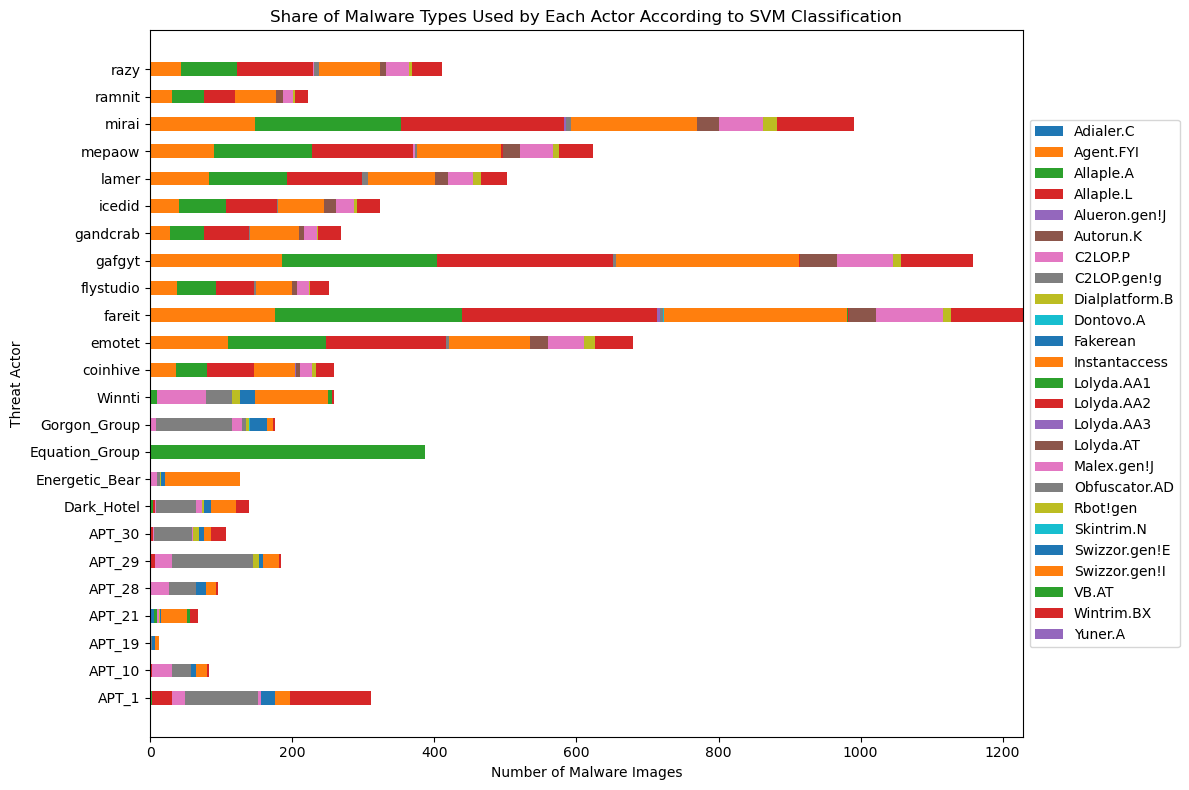

In [129]:
left = [0] * 24
height = 0.5

plt.figure(figsize=(12, 8))
for family in all_families:
    plt.barh(np.unique(family_counts_svm[['APT Name']]), width=family_counts_svm.loc[family_counts_svm["True Family Name"]==family]["count"], height=height, left=left)
    left = [x + y for x, y in zip(family_counts_svm.loc[family_counts_svm["True Family Name"]==family]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Threat Actor")
plt.legend(all_families, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used by Each Actor According to SVM Classification")
plt.tight_layout()
plt.savefig('results/svm_class_dists.png')

### Proportions Predicted by SVM

In [130]:
svm_props = pd.DataFrame({"APT Name": [], "SVM Family": [], "proportion": []})
for group in np.unique(family_counts_svm[['APT Name']]):
    sub = family_counts_svm[family_counts_svm['APT Name'] == group].reset_index()
    for i in range(len(sub)):
        svm_props = pd.concat([svm_props, pd.DataFrame({"APT Name": [group], "SVM Family": [family_counts_svm['True Family Name'].iloc[i]], 
                                                        "proportion": [sub['count'].iloc[i] / sum(sub['count'])]})])

In [131]:
# make a data frame of proportions for each APT_name
for family in np.unique(svm_props['APT Name']):
    df = svm_props[svm_props['proportion'] != 0].sort_values(by=["APT Name", "proportion"], ascending=False)
    print(df[df["APT Name"] == family])
    print("-----------------------------------------")

  APT Name     SVM Family  proportion
0    APT_1     Wintrim.BX    0.366559
0    APT_1    C2LOP.gen!g    0.327974
0    APT_1      Allaple.L    0.093248
0    APT_1  Swizzor.gen!I    0.067524
0    APT_1  Swizzor.gen!E    0.064309
0    APT_1        C2LOP.P    0.057878
0    APT_1    Malex.gen!J    0.016077
0    APT_1      Allaple.A    0.006431
-----------------------------------------
  APT Name     SVM Family  proportion
0   APT_10        C2LOP.P    0.353659
0   APT_10    C2LOP.gen!g    0.317073
0   APT_10  Swizzor.gen!I    0.182927
0   APT_10  Swizzor.gen!E    0.085366
0   APT_10      Allaple.L    0.024390
0   APT_10     Wintrim.BX    0.024390
0   APT_10       Fakerean    0.012195
-----------------------------------------
  APT Name     SVM Family  proportion
0   APT_19  Swizzor.gen!I        0.50
0   APT_19    C2LOP.gen!g        0.25
0   APT_19  Swizzor.gen!E        0.25
-----------------------------------------
  APT Name     SVM Family  proportion
0   APT_21  Swizzor.gen!I    0.552239


### XGBoost Classes Predicted

In [132]:
family_counts_xgb = pd.merge(apt_preds[['APT Name', 'XGB Preds']], class_index_reference, how='left', left_on='XGB Preds', right_on='True Family Index')
family_counts_xgb = family_counts_xgb[['APT Name', "True Family Name"]].groupby(["APT Name"]).value_counts().reset_index().rename(columns={0: "count"})
family_counts_xgb

APT Name True Family Name  count
0      APT_1      C2LOP.gen!g    137
1      APT_1       Wintrim.BX     70
2      APT_1          C2LOP.P     30
3      APT_1        Allaple.A     30
4      APT_1    Swizzor.gen!I     21
..       ...              ...    ...
279     razy       Lolyda.AA1      8
280     razy   Dialplatform.B      6
281     razy          C2LOP.P      3
282     razy        Lolyda.AT      1
283     razy        Adialer.C      1

[284 rows x 3 columns]

In [133]:
for group in np.unique(family_counts_xgb[['APT Name']]):
    subset = family_counts_xgb[family_counts_xgb['APT Name']==group]
    for family in all_families:
        if (family in np.unique(subset[['True Family Name']])) == False:
            family_counts_xgb = pd.concat([family_counts_xgb, pd.DataFrame({"APT Name": [group], "True Family Name": [family], "count": [0]})], ignore_index=True)
            
family_counts_xgb = family_counts_xgb.sort_values(["APT Name", "True Family Name"])
family_counts_xgb

APT Name True Family Name  count
284    APT_1        Adialer.C      0
285    APT_1        Agent.FYI      0
3      APT_1        Allaple.A     30
6      APT_1        Allaple.L      8
286    APT_1    Alueron.gen!J      0
..       ...              ...    ...
598     razy    Swizzor.gen!E      0
276     razy    Swizzor.gen!I     14
274     razy            VB.AT     15
277     razy       Wintrim.BX     10
599     razy          Yuner.A      0

[600 rows x 3 columns]

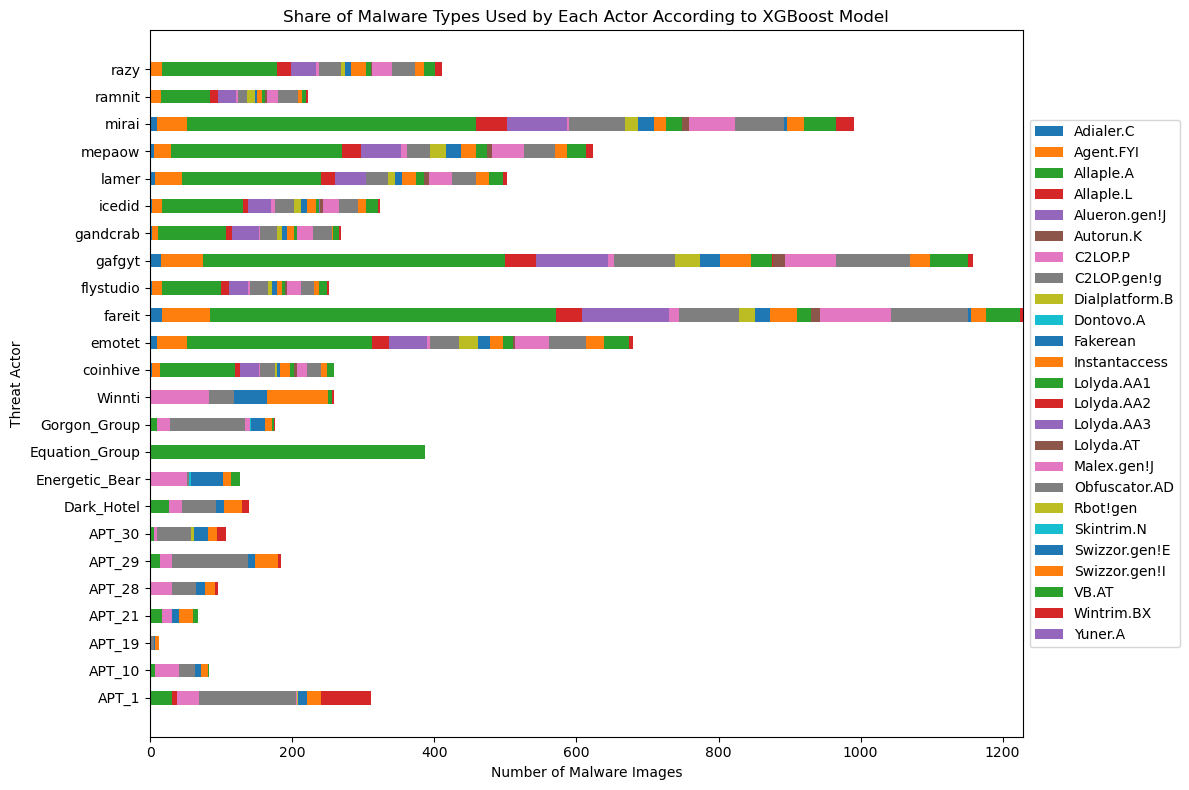

In [134]:
left = [0] * 24
height = 0.5

plt.figure(figsize=(12, 8))
for family in all_families:
    plt.barh(np.unique(family_counts_xgb[['APT Name']]), width=family_counts_xgb.loc[family_counts_xgb["True Family Name"]==family]["count"], height=height, left=left)
    left = [x + y for x, y in zip(family_counts_xgb.loc[family_counts_xgb["True Family Name"]==family]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Threat Actor")
plt.legend(all_families, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used by Each Actor According to XGBoost Model")
plt.tight_layout()
plt.savefig('results/xgb_class_dists.png')

### Proportions Predicted by XGBoost

In [135]:
xgb_props = pd.DataFrame({"APT Name": [], "XGB Family": [], "proportion": []})
for group in np.unique(family_counts_xgb[['APT Name']]):
    sub = family_counts_xgb[family_counts_xgb['APT Name'] == group].reset_index()
    for i in range(len(sub)):
        xgb_props = pd.concat([xgb_props, pd.DataFrame({"APT Name": [group], "XGB Family": [family_counts_xgb['True Family Name'].iloc[i]], 
                                                        "proportion": [sub['count'].iloc[i] / sum(sub['count'])]})])

In [136]:
for family in np.unique(xgb_props['APT Name']):
    df = xgb_props[xgb_props['proportion'] != 0].sort_values(by=["APT Name", "proportion"], ascending=False)
    print(df[df["APT Name"] == family])
    print("-----------------------------------------")

  APT Name     XGB Family  proportion
0    APT_1    C2LOP.gen!g    0.440514
0    APT_1     Wintrim.BX    0.225080
0    APT_1      Allaple.A    0.096463
0    APT_1        C2LOP.P    0.096463
0    APT_1  Swizzor.gen!I    0.067524
0    APT_1  Swizzor.gen!E    0.038585
0    APT_1      Allaple.L    0.025723
0    APT_1    Malex.gen!J    0.006431
0    APT_1       Rbot!gen    0.003215
-----------------------------------------
  APT Name     XGB Family  proportion
0   APT_10        C2LOP.P    0.426829
0   APT_10    C2LOP.gen!g    0.268293
0   APT_10  Swizzor.gen!E    0.109756
0   APT_10  Swizzor.gen!I    0.109756
0   APT_10      Allaple.A    0.073171
0   APT_10          VB.AT    0.012195
-----------------------------------------
  APT Name     XGB Family  proportion
0   APT_19  Swizzor.gen!I    0.500000
0   APT_19    C2LOP.gen!g    0.333333
0   APT_19        C2LOP.P    0.083333
0   APT_19  Swizzor.gen!E    0.083333
-----------------------------------------
  APT Name     XGB Family  proportion


## Cohen's Kappa Statistics

In [137]:
kappas = pd.DataFrame({"Models": ["KNN/RF", "KNN/SVM", "KNN/XGB",
                                  "RF/SVM", "RF/XGB",
                                  "SVM/XGB"],
                       "K": [metrics.cohen_kappa_score(apt_preds["KNN Preds"], apt_preds["RF Preds"]),
                             metrics.cohen_kappa_score(apt_preds["KNN Preds"], apt_preds["SVM Preds"]),
                             metrics.cohen_kappa_score(apt_preds["KNN Preds"], apt_preds["XGB Preds"]),
                             metrics.cohen_kappa_score(apt_preds["RF Preds"], apt_preds["SVM Preds"]),
                             metrics.cohen_kappa_score(apt_preds["RF Preds"], apt_preds["XGB Preds"]),
                             metrics.cohen_kappa_score(apt_preds["SVM Preds"], apt_preds["XGB Preds"])]})
kappas

Models         K
0   KNN/RF  0.383913
1  KNN/SVM  0.487733
2  KNN/XGB  0.352969
3   RF/SVM  0.530680
4   RF/XGB  0.395725
5  SVM/XGB  0.308457

## Empirical Proportion of Time Models Predicted the Same

In [138]:
# calculate the proportion of observations for which all 4 models yielded the same prediction
ctr = 0
for i in range(len(apt_preds)):
    if ((apt_preds['KNN Preds'].iloc[i] == apt_preds['RF Preds'].iloc[i]) & 
        (apt_preds['RF Preds'].iloc[i] == apt_preds['SVM Preds'].iloc[i]) & 
        (apt_preds['SVM Preds'].iloc[i] == apt_preds['XGB Preds'].iloc[i])):
        ctr += 1

# proportion of rows in which the identified families are all the same
ctr / len(apt_preds)

0.26893127186547794

In [139]:
# proportion of observations for which 3 models yield the same thing
ctr_2 = 0
for i in range(len(apt_preds)):
    if (((apt_preds['KNN Preds'].iloc[i] == apt_preds['RF Preds'].iloc[i]) & (apt_preds['RF Preds'].iloc[i] == apt_preds['SVM Preds'].iloc[i])) |
        ((apt_preds['KNN Preds'].iloc[i] == apt_preds['RF Preds'].iloc[i]) & (apt_preds['RF Preds'].iloc[i] == apt_preds['XGB Preds'].iloc[i])) |
        ((apt_preds['KNN Preds'].iloc[i] == apt_preds['SVM Preds'].iloc[i]) & (apt_preds['SVM Preds'].iloc[i] == apt_preds['XGB Preds'].iloc[i])) |
        ((apt_preds['RF Preds'].iloc[i] == apt_preds['SVM Preds'].iloc[i]) & (apt_preds['SVM Preds'].iloc[i] == apt_preds['XGB Preds'].iloc[i]))):
        ctr_2 += 1
        
ctr_2 / len(apt_preds)

0.5283828010382575

# Trying Clustering on the APT Data

## KMeans Clustering

For n_clusters = 10 The average silhouette_score is : 0.5016888465360184
For n_clusters = 11 The average silhouette_score is : 0.5057198697190677
For n_clusters = 12 The average silhouette_score is : 0.504325142544615
For n_clusters = 13 The average silhouette_score is : 0.5060303184752608
For n_clusters = 14 The average silhouette_score is : 0.49911140081457106
For n_clusters = 15 The average silhouette_score is : 0.49169132213896205
For n_clusters = 16 The average silhouette_score is : 0.4912344622130418
For n_clusters = 17 The average silhouette_score is : 0.46050937348665444
For n_clusters = 18 The average silhouette_score is : 0.45709392899852463
For n_clusters = 19 The average silhouette_score is : 0.4635853633764815


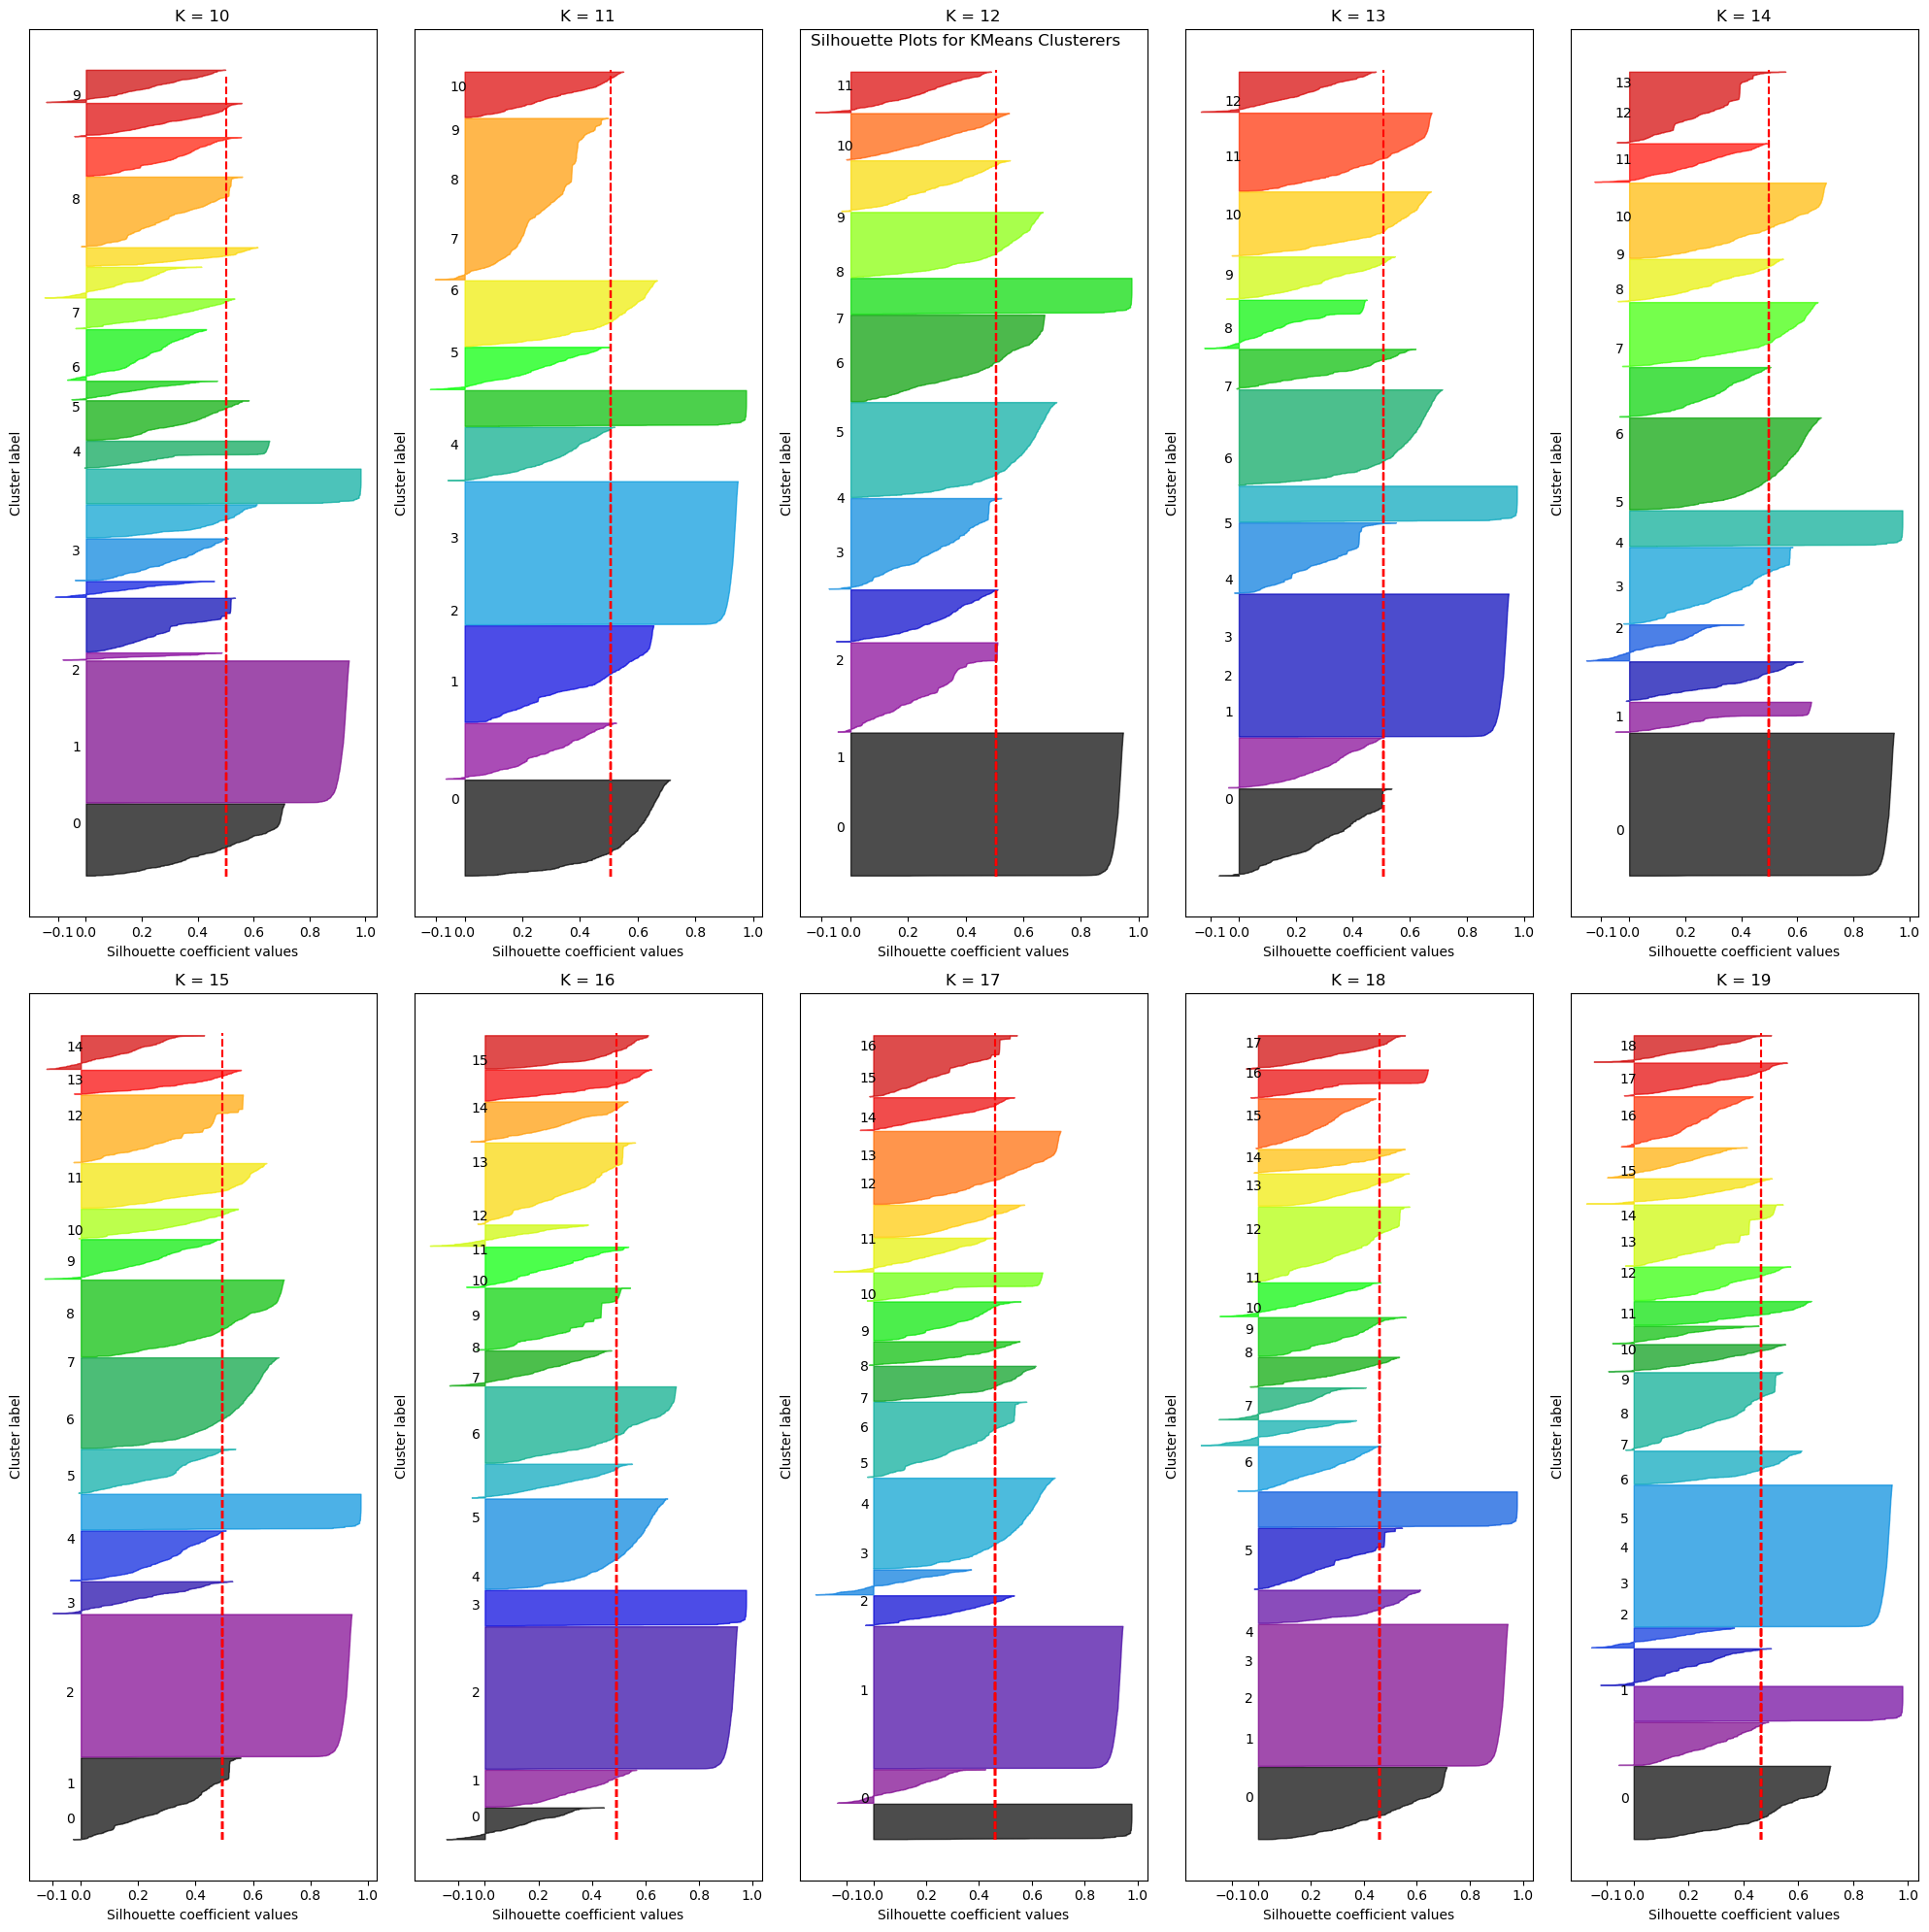

In [140]:
fig, axs = plt.subplots(2, 5, figsize = (20,20))
axs = axs.ravel()
for n_clusters in range(10, 20):
    clusterer = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = clusterer.fit_predict(apt_pca)
    
    silhouette_avg = silhouette_score(apt_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # silhouette plot
    sample_silhouette_values = silhouette_samples(apt_pca, cluster_labels)

    y_lower=10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        axs[n_clusters-19].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        axs[n_clusters-20].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        axs[n_clusters-20].set_xlabel("Silhouette coefficient values")
        axs[n_clusters-20].set_ylabel("Cluster label")
        axs[n_clusters-20].set_title("K = {}".format(n_clusters))

        # The vertical line for average silhouette score of all the values
        axs[n_clusters-20].vlines(x=silhouette_avg, ymin = 0, ymax = y_lower, color="red", linestyle="--")

        axs[n_clusters-20].set_yticks([])  # Clear the yaxis labels / ticks
        axs[n_clusters-20].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
fig.tight_layout()
fig.suptitle("Silhouette Plots for KMeans Clusterers")
fig.savefig("results/silhouettes_kmeans.png")

## Agglomerative Clustering

For n_clusters = 13 The average silhouette_score is : 0.4739711363828885
For n_clusters = 13 The average silhouette_score is : 0.4739711363828885
For n_clusters = 13 The average silhouette_score is : 0.4739711363828885
For n_clusters = 12 The average silhouette_score is : 0.478519074582418
For n_clusters = 12 The average silhouette_score is : 0.478519074582418
For n_clusters = 11 The average silhouette_score is : 0.4644212733401283


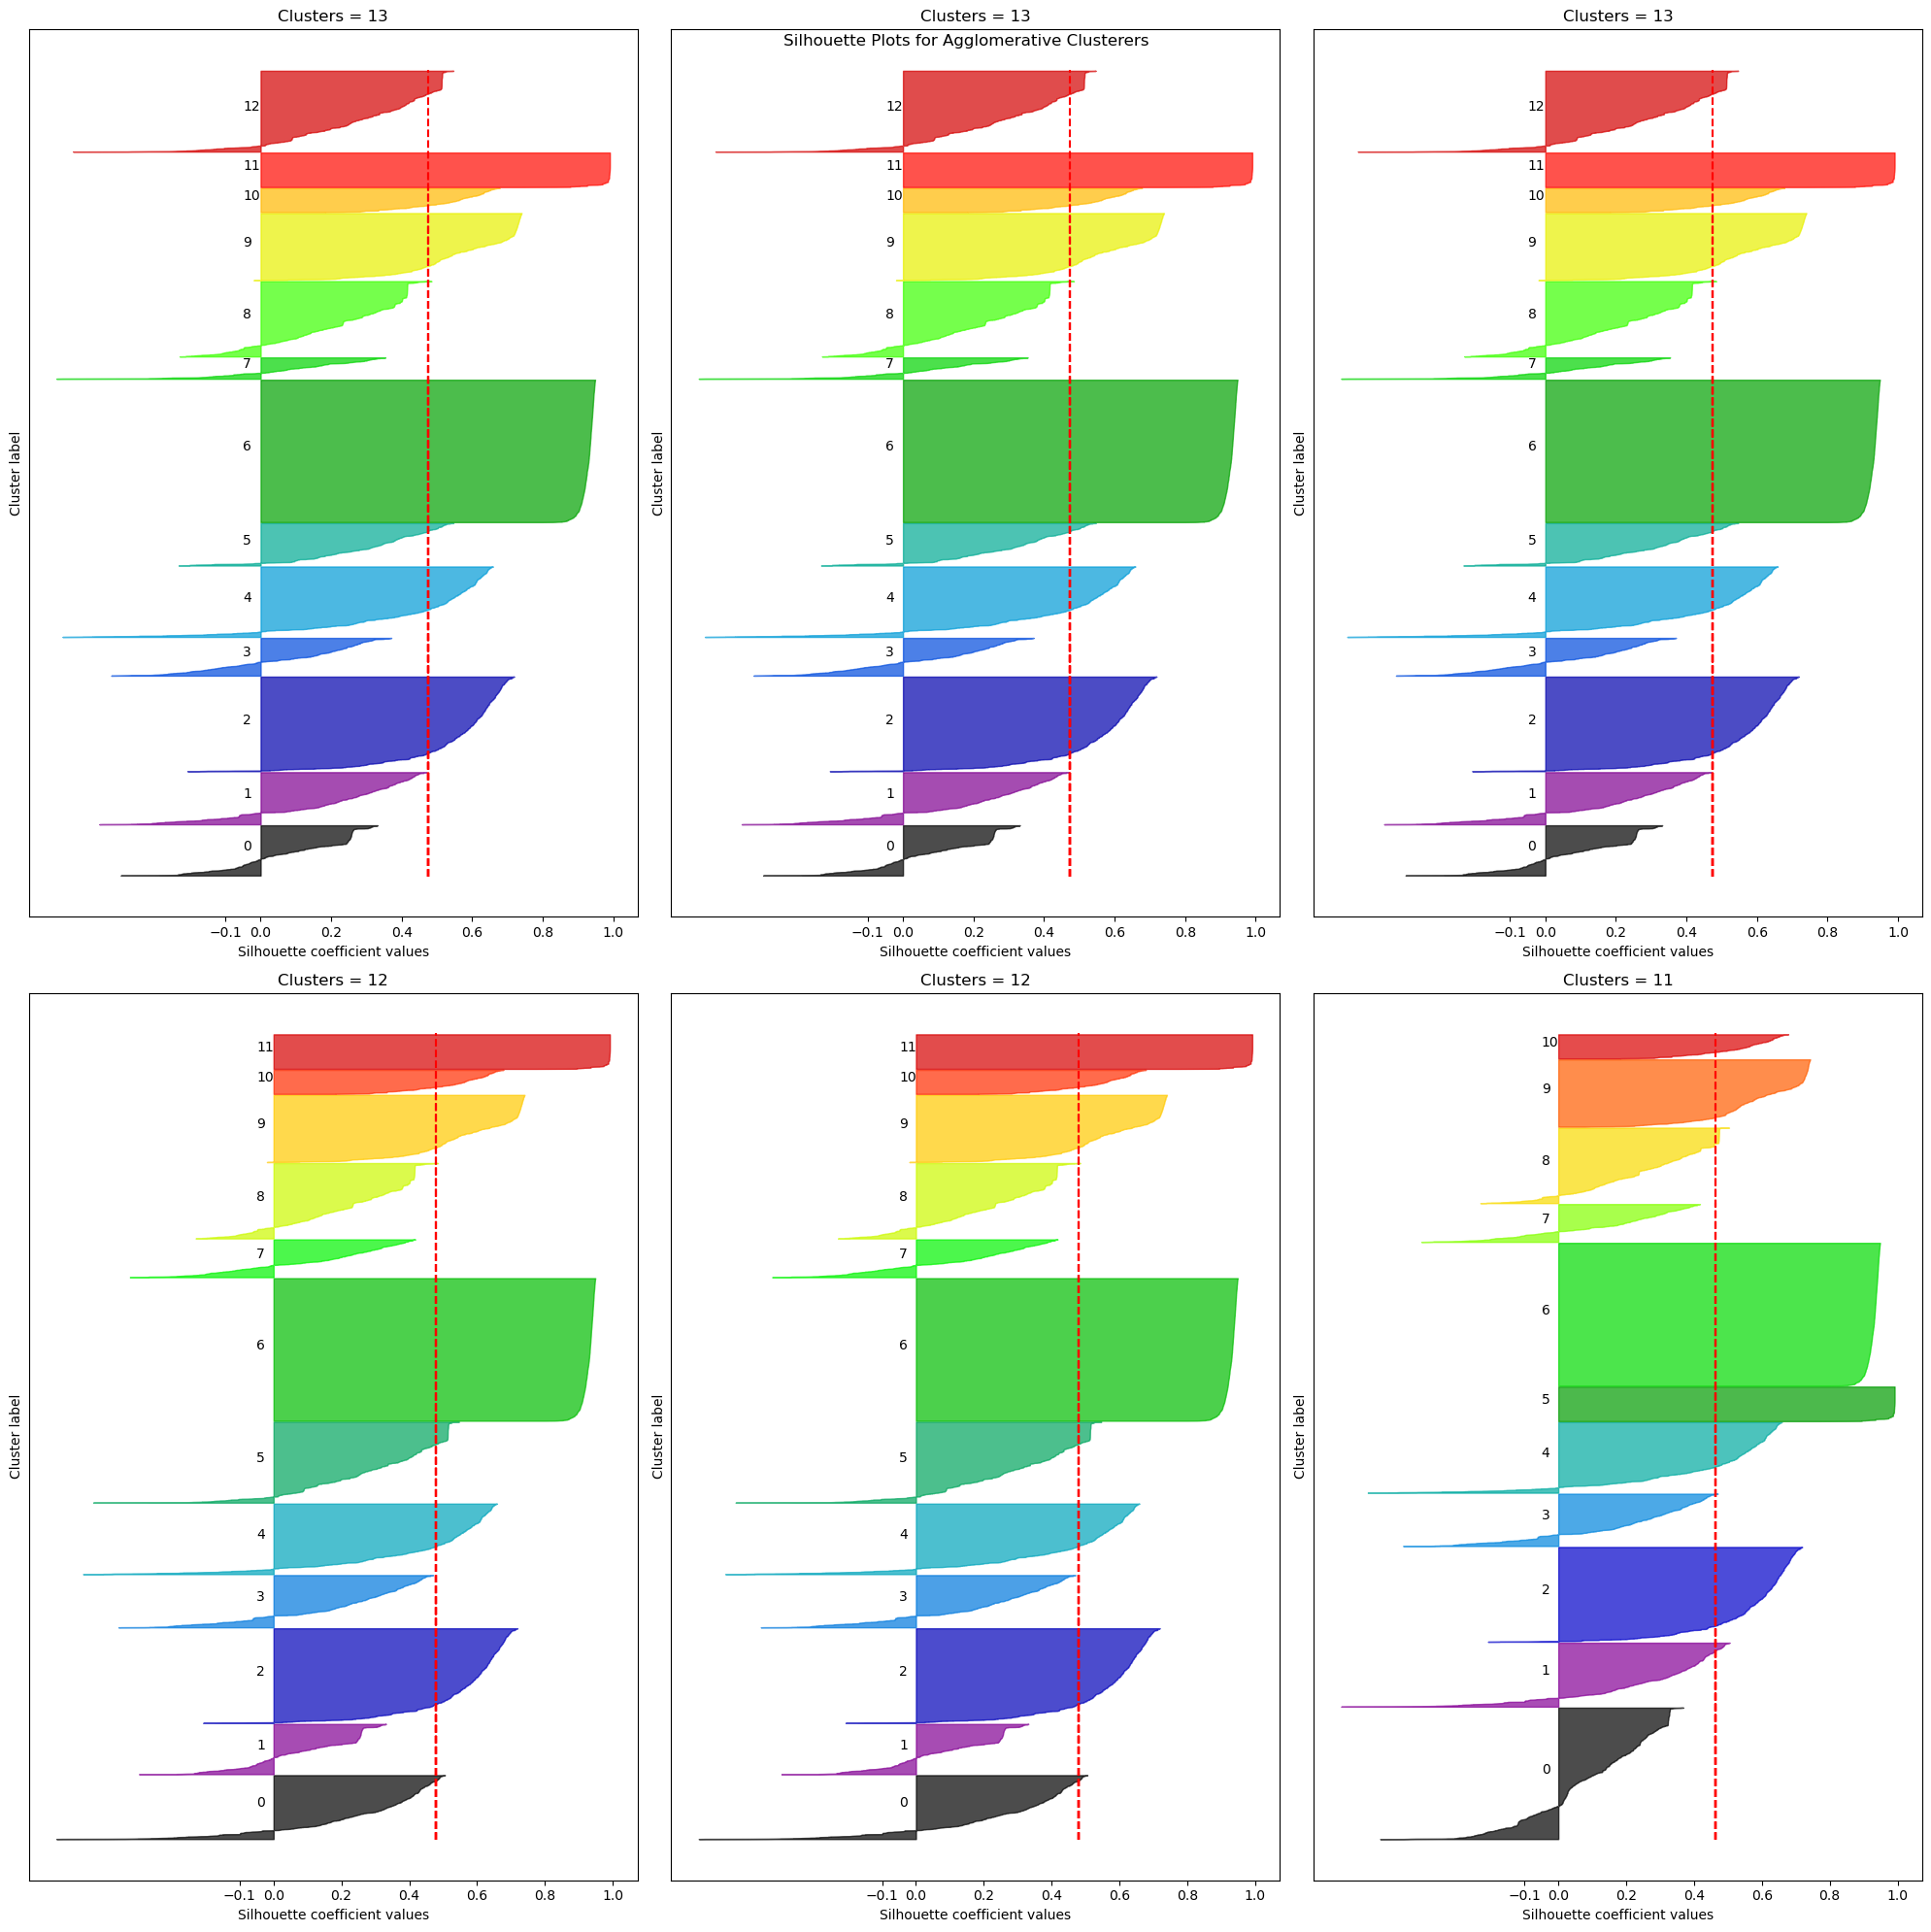

In [141]:
fig, axs = plt.subplots(2, 3, figsize = (20,20))
axs = axs.ravel()
for dist in range(290, 350, 10):
    idx = int((dist - 290) / 10)
    clusterer = AgglomerativeClustering(n_clusters = None, distance_threshold=dist, metric = 'euclidean')
    cluster_labels = clusterer.fit_predict(apt_pca)
    
    silhouette_avg = silhouette_score(apt_pca, cluster_labels)
    print(
        "For n_clusters =",
        clusterer.n_clusters_,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # silhouette plot
    sample_silhouette_values = silhouette_samples(apt_pca, cluster_labels)

    y_lower=10
    for i in range(clusterer.n_clusters_):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusterer.n_clusters_)
        axs[idx].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        axs[idx].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        axs[idx].set_xlabel("Silhouette coefficient values")
        axs[idx].set_ylabel("Cluster label")
        axs[idx].set_title("Clusters = {}".format(clusterer.n_clusters_))

        # The vertical line for average silhouette score of all the values
        axs[idx].vlines(x=silhouette_avg, ymin = 0, ymax = y_lower, color="red", linestyle="--")

        axs[idx].set_yticks([])  # Clear the yaxis labels / ticks
        axs[idx].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
fig.tight_layout()
fig.suptitle("Silhouette Plots for Agglomerative Clusterers")
fig.savefig("results/silhouettes_agg.png")

In [142]:
kmeans_test_model = KMeans(n_clusters=11, n_init=10)

In [143]:
kmeans_test_preds = kmeans_test_model.fit_predict(apt_pca)
kmeans_test_preds

array([1, 0, 3, ..., 2, 9, 0], dtype=int32)

In [144]:
kmeans_test_results = pd.DataFrame({'group': apt_df['group'], 'cluster': list(kmeans_test_preds)})
kmeans_test_results

group  cluster
0        14        1
1        19        0
2        11        3
3         5        8
4        12        0
...     ...      ...
8856     12        9
8857     22        5
8858     12        2
8859     14        9
8860     20        0

[8861 rows x 2 columns]

In [145]:
kmeans_cluster_counts = kmeans_test_results.groupby(["group"]).value_counts().reset_index().rename(columns={0: "count"})
kmeans_cluster_counts

group  cluster  count
0        0        1    160
1        0        5     69
2        0        8     40
3        0        9     37
4        0        4      3
..     ...      ...    ...
149     23        5     68
150     23        1     17
151     23        6      9
152     23        3      6
153     23        4      3

[154 rows x 3 columns]

In [146]:
# Get Ready to Plot
for group in range(24):
    subset = kmeans_cluster_counts[kmeans_cluster_counts['group']==group]
    for cluster in range(11):
        if (cluster in np.unique(subset[['cluster']])) == False:
            kmeans_cluster_counts = pd.concat([kmeans_cluster_counts, pd.DataFrame({"group": [group], "cluster": [cluster], "count": [0]})], ignore_index=True)
            
kmeans_cluster_counts = kmeans_cluster_counts.sort_values(["group", "cluster"])
kmeans_cluster_counts

group  cluster  count
154      0        0      0
0        0        1    160
155      0        2      0
156      0        3      0
4        0        4      3
..     ...      ...    ...
151     23        6      9
261     23        7      0
148     23        8    156
262     23        9      0
263     23       10      0

[264 rows x 3 columns]

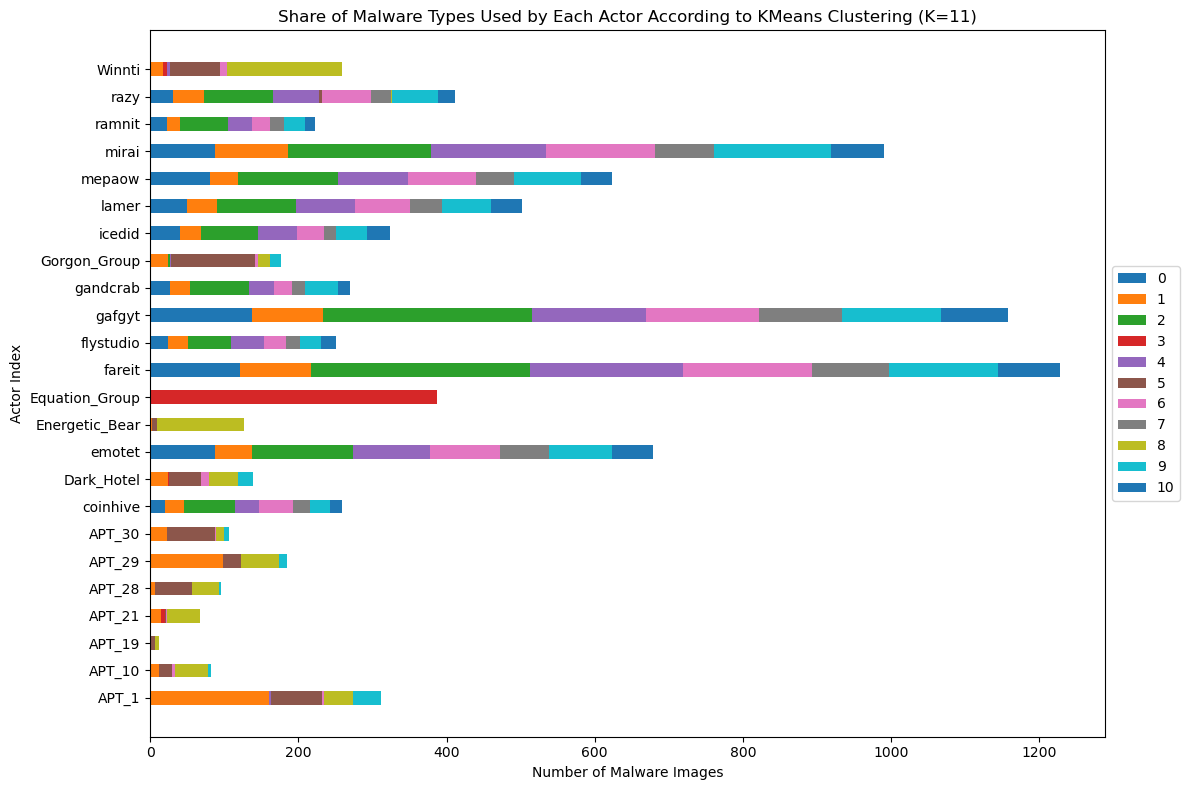

In [147]:
left = [0] * 24
height = 0.5

plt.figure(figsize=(12, 8))
for cluster in range(11):
    plt.barh(np.unique(kmeans_cluster_counts[['group']]), width=kmeans_cluster_counts.loc[kmeans_cluster_counts["cluster"]==cluster]["count"], height=height, left=left)
    left = [x + y for x, y in zip(kmeans_cluster_counts.loc[kmeans_cluster_counts["cluster"]==cluster]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Actor Index")
plt.yticks(range(24), group_index_reference['APT Name'])
plt.legend(np.unique(kmeans_cluster_counts['cluster']), loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used by Each Actor According to KMeans Clustering (K=11)")
plt.tight_layout()
plt.savefig('results/kmenas_cluster_dists.png')

In [178]:
agg_test_model = AgglomerativeClustering(n_clusters = 11, metric="euclidean")
agg_test_preds = agg_test_model.fit_predict(apt_pca)
agg_test_results = pd.DataFrame({'group': apt_df['group'], 'cluster': list(agg_test_preds)})
agg_cluster_counts = agg_test_results.groupby(["group"]).value_counts().reset_index().rename(columns={0: "count"})

In [179]:
# Get Ready to Plot
for group in range(24):
    subset = agg_cluster_counts[agg_cluster_counts['group']==group]
    for cluster in range(11):
        if (cluster in np.unique(subset[['cluster']])) == False:
            agg_cluster_counts = pd.concat([agg_cluster_counts, pd.DataFrame({"group": [group], "cluster": [cluster], "count": [0]})], ignore_index=True)
            
agg_cluster_counts = agg_cluster_counts.sort_values(["group", "cluster"])
agg_cluster_counts

group  cluster  count
2        0        0     63
1        0        1     69
4        0        2      1
144      0        3      0
145      0        4      0
..     ...      ...    ...
261     23        6      0
140     23        7     66
262     23        8      0
143     23        9      5
263     23       10      0

[264 rows x 3 columns]

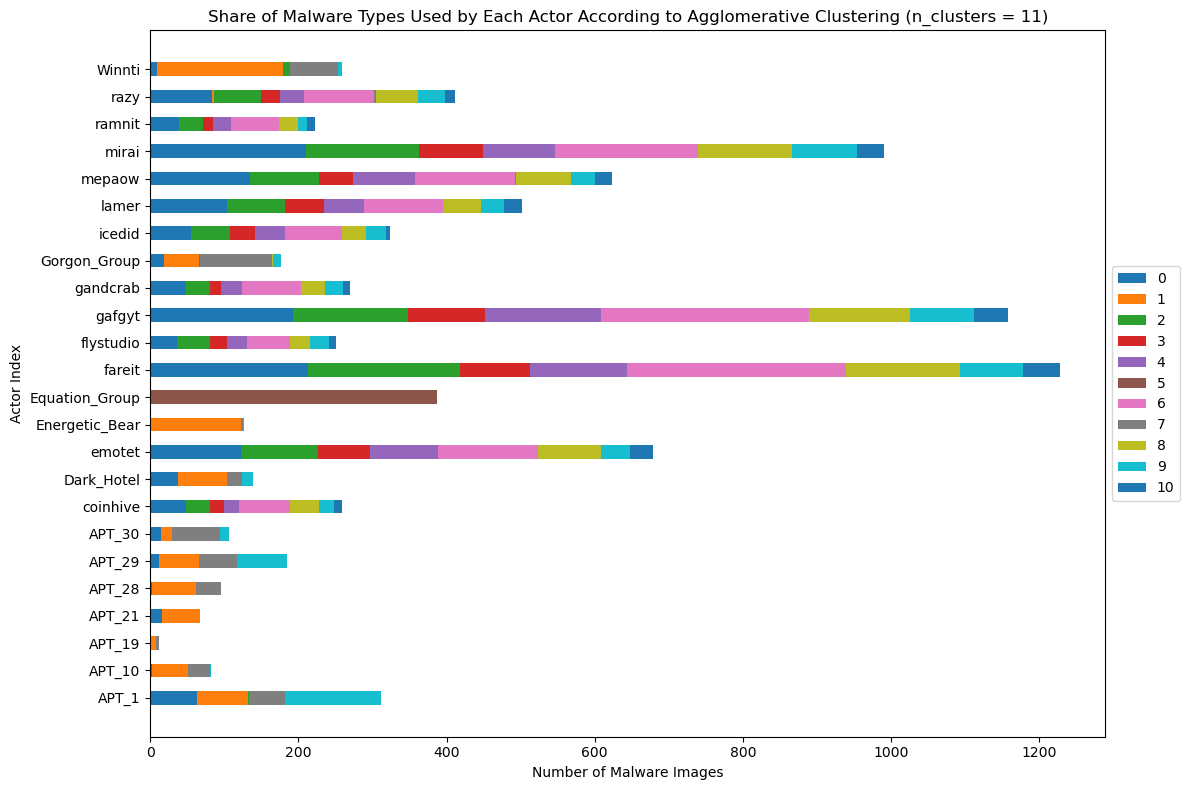

In [180]:
left = [0] * 24
height = 0.5

plt.figure(figsize=(12, 8))
for cluster in range(11):
    plt.barh(np.unique(agg_cluster_counts[['group']]), width=agg_cluster_counts.loc[agg_cluster_counts["cluster"]==cluster]["count"], height=height, left=left)
    left = [x + y for x, y in zip(agg_cluster_counts.loc[agg_cluster_counts["cluster"]==cluster]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Actor Index")
plt.yticks(range(24), group_index_reference['APT Name'])
plt.legend(np.unique(agg_cluster_counts['cluster']), loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used by Each Actor According to Agglomerative Clustering (n_clusters = 11)")
plt.tight_layout()
plt.savefig('results/agg_cluster_dists.png')

# Temporal Analysis

In [151]:
# Read in temporal data with year labels
year_data = test_generator.flow_from_directory(directory="Advanced_Persistent_Threat_Classified_Dataset/Years",
                                               color_mode="grayscale", target_size=(224,224), class_mode="categorical",
                                               classes=['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', 
                                                        '2019', '2020', '2021', '2022', '2023'])

Found 17441 images belonging to 13 classes.


In [152]:
# Feature extraction and conversion to a dataframe
i = 0
year_features = []
year_labels = []
while i < len(year_data):
    # save true batch labels
    idxs = []
    for labels in year_data[i][1]:
        for j in range(0, 13):
            if labels[j]==1:
                idxs.append(j)
                continue
    year_labels.append(idxs)
    # extract features
    batch = year_data[i][0]
    year_features.append(feature_extraction(batch, vgg16_model))
    i += 1
    
years_df = pd.concat([pd.DataFrame([arr[0].tolist() for arr in year_features[i]]) for i in range(len(year_features))],
                      ignore_index=True)
years_df['Year'] = [lst[i] for lst in year_labels for i in range(len(lst))]

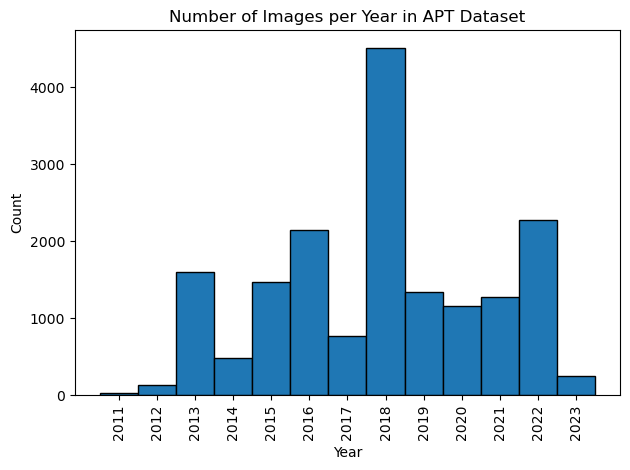

In [153]:
# Exploratory Analysis: number of images per year
plt.hist(x=years_df['Year'], bins=np.arange(0, 14), edgecolor = 'black')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(np.arange(0.5, 13.5, 1.0), ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])
plt.tick_params(axis='x', rotation=90)
plt.title('Number of Images per Year in APT Dataset')
plt.tight_layout()
plt.savefig("results/years_dist.png")

In [154]:
# PCA to reduce dimensionality of the years data
years_pca = PCA(n_components=4).fit_transform(years_df.drop('Year', axis=1))

In [155]:
year_preds = pd.DataFrame({"KNN Preds": knn_model.predict(years_pca),
                          "RF Preds": rf_model.predict(years_pca),
                          "SVM Preds": svm_classifier.predict(years_pca),
                          "XGB Preds": xgb_model.predict(years_pca),
                          "KNN OS Preds": open_set_pred(knn_model, years_pca, 0.75),
                          "RF OS Preds": open_set_pred(rf_model, years_pca, 0.75),
                          "SVM OS Preds": open_set_pred(svm_classifier, years_pca, 0.75),
                          "XGB OS Preds": open_set_pred(xgb_model, years_pca, 0.75)})

In [156]:
year_preds['Agg Preds'] = stats.mode(year_preds[["KNN Preds", "RF Preds", "SVM Preds", "XGB Preds"]], axis=1, keepdims=True)[0]
year_preds['Agg OS Preds'] = stats.mode(year_preds[["KNN OS Preds", "RF OS Preds", "SVM OS Preds", "XGB OS Preds"]], axis=1, keepdims=True)[0]
year_preds['Year'] = years_df['Year']
year_preds = pd.merge(year_preds, class_index_reference, left_on='Agg Preds', right_on='True Family Index', how='left')
year_preds['Agg OS Family'] = ["unknown" if year_preds["Agg OS Preds"].loc[i] == "unknown" else class_index_reference['True Family Name'].loc[year_preds["Agg OS Preds"].loc[i]] for i in range(len(year_preds))]
year_preds

/var/folders/rg/snrjx98x13g1mvj217brwj9m0000gn/T/ipykernel_39188/641309365.py:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  year_preds['Agg OS Preds'] = stats.mode(year_preds[["KNN OS Preds", "RF OS Preds", "SVM OS Preds", "XGB OS Preds"]], axis=1, keepdims=True)[0]


KNN Preds  RF Preds  SVM Preds  XGB Preds KNN OS Preds RF OS Preds  \
0              2         2         16          2            2           2   
1              6        21          6         21      unknown     unknown   
2             17        17         17         17      unknown     unknown   
3              6         6          6          6            6     unknown   
4              3         3          3          3            3           3   
...          ...       ...        ...        ...          ...         ...   
17436          2         2          2          2            2     unknown   
17437          3         3          3          3            3     unknown   
17438         23        23         23         23           23     unknown   
17439          6        22          6          6      unknown     unknown   
17440          2         3         16         21      unknown     unknown   

      SVM OS Preds XGB OS Preds  Agg Preds Agg OS Preds  Year  \
0               16            2          2            2     7   
1          unknown      unknown          6      unknown     9   
2               17           17         17      unknown     2   
3          unknown      unknown          6      unknown    11   
4                3            3          3            3     8   
...            ...          ...        ...          ...   ...   
17436      unknown      unknown          2      unknown    11   
17437            3            3          3            3     7   
17438           23      unknown         23           23     7   
17439      unknown      unknown          6      unknown     5   
17440      unknown      unknown          2      unknown    12   

       True Family Index True Family Name  Agg OS Family  
0                      2        Allaple.A  Obfuscator.AD  
1                      6          C2LOP.P        unknown  
2                     17    Obfuscator.AD        unknown  
3                      6          C2LOP.P        unknown  
4                      3        Allaple.L      Allaple.A  
...                  ...              ...            ...  
17436                  2        Allaple.A        unknown  
17437                  3        Allaple.L      Allaple.A  
17438                 23       Wintrim.BX    C2LOP.gen!g  
17439                  6          C2LOP.P        unknown  
17440                  2        Allaple.A        unknown  

[17441 rows x 14 columns]

In [157]:
# proportion of observations for which 3 models yield the same thing
ctr_2 = 0
for i in range(len(year_preds)):
    if (((year_preds['KNN Preds'].iloc[i] == year_preds['RF Preds'].iloc[i]) & (year_preds['RF Preds'].iloc[i] == year_preds['SVM Preds'].iloc[i])) |
        ((year_preds['KNN Preds'].iloc[i] == year_preds['RF Preds'].iloc[i]) & (year_preds['RF Preds'].iloc[i] == year_preds['XGB Preds'].iloc[i])) |
        ((year_preds['KNN Preds'].iloc[i] == year_preds['SVM Preds'].iloc[i]) & (year_preds['SVM Preds'].iloc[i] == year_preds['XGB Preds'].iloc[i])) |
        ((year_preds['RF Preds'].iloc[i] == year_preds['SVM Preds'].iloc[i]) & (year_preds['SVM Preds'].iloc[i] == year_preds['XGB Preds'].iloc[i]))):
        ctr_2 += 1
        
ctr_2 / len(year_preds)

0.6357433633392581

In [158]:
# calculate the proportion of observations for which all 4 models yielded the same prediction
ctr = 0
for i in range(len(year_preds)):
    if ((year_preds['KNN Preds'].iloc[i] == year_preds['RF Preds'].iloc[i]) & 
        (year_preds['RF Preds'].iloc[i] == year_preds['SVM Preds'].iloc[i]) & 
        (year_preds['SVM Preds'].iloc[i] == year_preds['XGB Preds'].iloc[i])):
        ctr += 1

# proportion of rows in which the identified families are all the same
ctr / len(year_preds)

0.2976320165128146

In [159]:
# Calculate the percent unknown
len(year_preds[year_preds['Agg OS Preds'] == "unknown"]) / 17441

0.5940599736253656

In [160]:
percents_annual_os = pd.DataFrame({'Year': [], 'Family': [], 'Percent': []})
for year in range(0, 13):
    subset = year_preds[['Year', 'Agg OS Family']].loc[year_preds['Year'] == year].groupby('Agg OS Family').value_counts().reset_index().rename(columns={0: "count"})
    for i in range(len(subset)):
        percents_annual_os = pd.concat([percents_annual_os, pd.DataFrame({'Year': [year], 'Family': [subset['Agg OS Family'].iloc[i]], 'Percent': [subset['count'].iloc[i] / sum(subset['count'])]})])
        
percents_annual_os = percents_annual_os.sort_values(by=["Year", "Percent"], ascending = False)

In [161]:
for year in np.unique(percents_annual_os['Year']):
    df = percents_annual_os[percents_annual_os['Percent'] != 0].sort_values(by=["Year", "Percent"], ascending=False)
    print(df[df["Year"] == year])
    print("-----------------------------------------")

   Year         Family  Percent
0   0.0        unknown  0.68750
0   0.0    Malex.gen!J  0.09375
0   0.0    C2LOP.gen!g  0.06250
0   0.0        Yuner.A  0.06250
0   0.0      Agent.FYI  0.03125
0   0.0  Obfuscator.AD  0.03125
0   0.0       Rbot!gen  0.03125
-----------------------------------------
   Year         Family   Percent
0   1.0        unknown  0.679688
0   1.0  Obfuscator.AD  0.195312
0   1.0     Lolyda.AA2  0.070312
0   1.0      Allaple.A  0.023438
0   1.0      Agent.FYI  0.015625
0   1.0    Malex.gen!J  0.007812
0   1.0  Swizzor.gen!E  0.007812
-----------------------------------------
   Year         Family   Percent
0   2.0        unknown  0.660000
0   2.0  Obfuscator.AD  0.095000
0   2.0    Malex.gen!J  0.050000
0   2.0      Allaple.A  0.044375
0   2.0      Agent.FYI  0.035000
0   2.0        Yuner.A  0.028750
0   2.0    C2LOP.gen!g  0.027500
0   2.0     Lolyda.AA2  0.016250
0   2.0        C2LOP.P  0.011875
0   2.0     Lolyda.AA3  0.010625
0   2.0     Skintrim.N  0.009375


In [162]:
top_families_os = pd.DataFrame({'Year': [], 'Agg Family': [], 'Percent': []})
for year in range(0, 13):
    subset = percents_annual_os[percents_annual_os["Year"] == year]
    top_families_os = pd.concat([top_families_os, pd.DataFrame({'Year': [year] * len(subset), 'Agg Family': subset['Family'].iloc[range(len(subset))], 'Percent': subset['Percent'].iloc[range(len(subset))]})])
    
top_families_os

Year     Agg Family   Percent
0    0.0        unknown  0.687500
0    0.0    Malex.gen!J  0.093750
0    0.0    C2LOP.gen!g  0.062500
0    0.0        Yuner.A  0.062500
0    0.0      Agent.FYI  0.031250
..   ...            ...       ...
0   12.0    C2LOP.gen!g  0.023438
0   12.0     Lolyda.AA2  0.019531
0   12.0    Malex.gen!J  0.019531
0   12.0        C2LOP.P  0.003906
0   12.0  Swizzor.gen!E  0.003906

[174 rows x 3 columns]

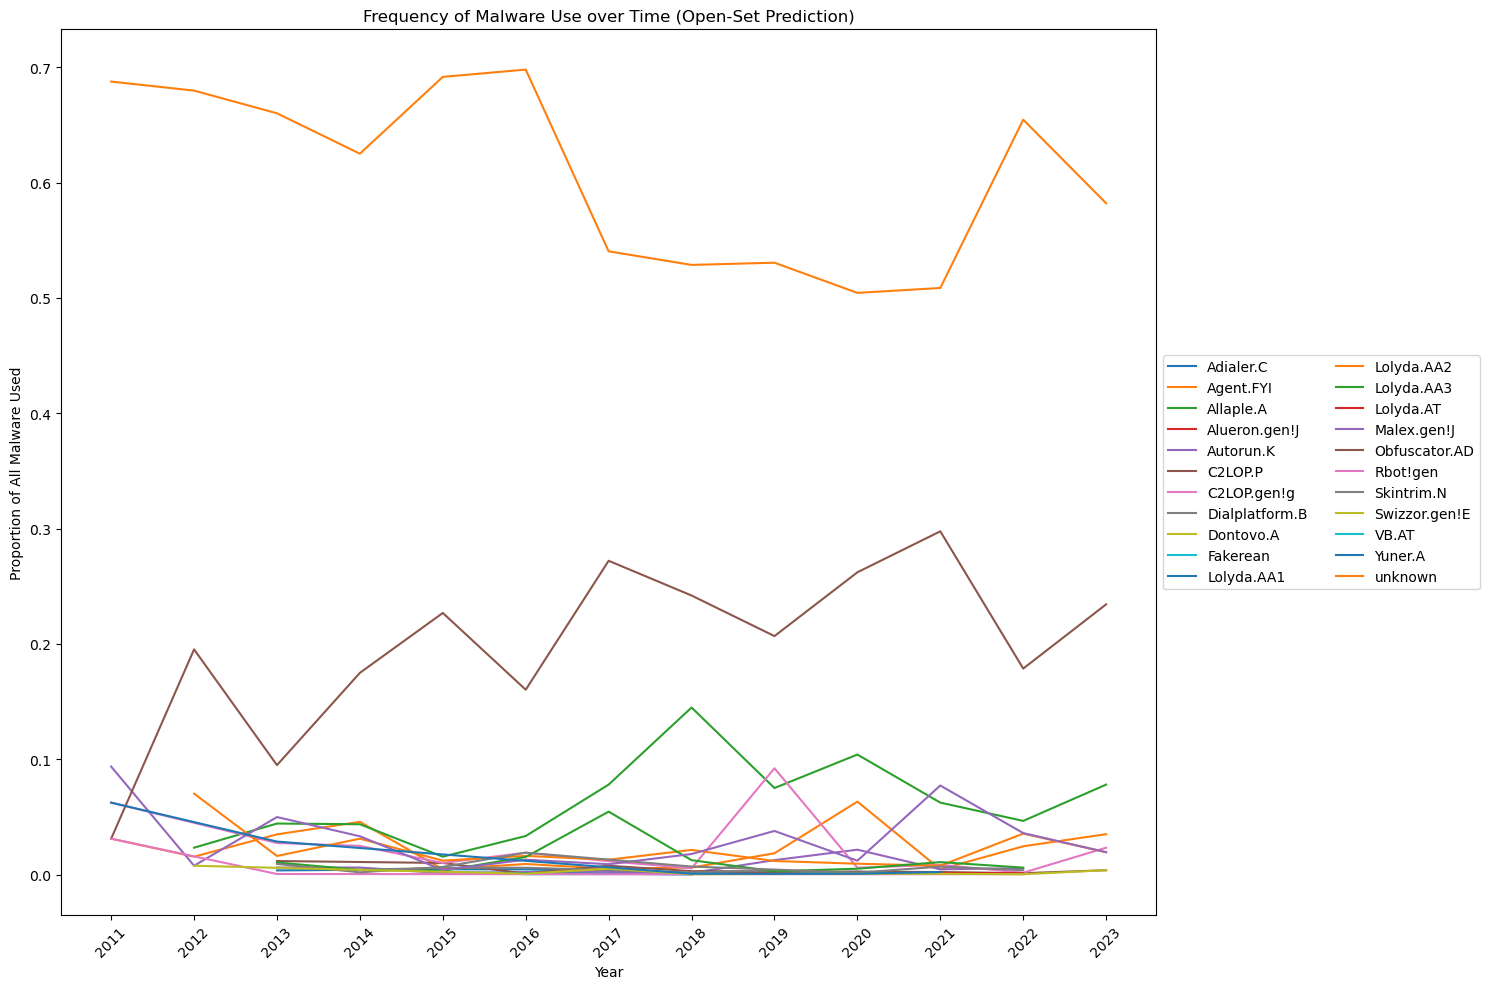

In [163]:
plt.figure(figsize=(15,10))
for family in np.unique(top_families_os['Agg Family']):
    data = top_families_os[top_families_os['Agg Family']==family]
    plt.plot("Year", "Percent", data = data, label = family)

plt.legend(loc='center left', bbox_to_anchor = (1, 0.5), ncols=2)
plt.xlabel("Year")
plt.ylabel("Proportion of All Malware Used")
plt.title("Frequency of Malware Use over Time (Open-Set Prediction)")
plt.tick_params(axis='x', rotation=45)
plt.xticks(range(13), range(2011, 2024))
plt.tight_layout()
plt.savefig("results/agg_family_timeline_open_set.png")

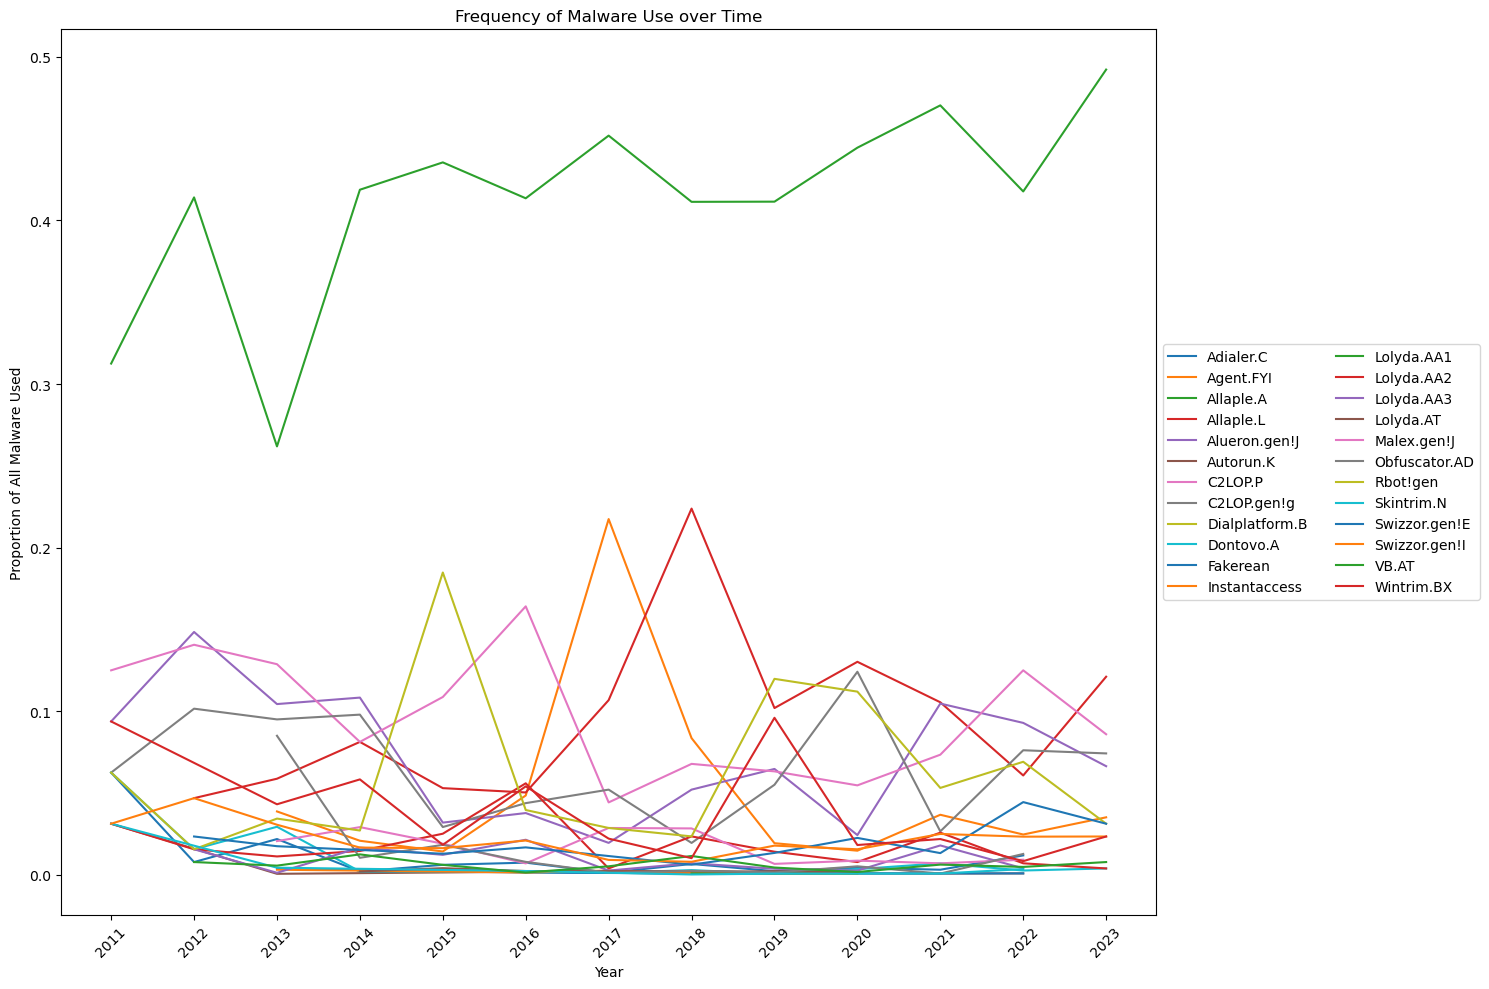

In [164]:
percents_annual = pd.DataFrame({'Year': [], 'Family': [], 'Percent': []})
for year in range(0, 13):
    subset = year_preds[['Year', 'True Family Name']].loc[year_preds['Year'] == year].groupby('True Family Name').value_counts().reset_index().rename(columns={0: "count"})
    for i in range(len(subset)):
        percents_annual = pd.concat([percents_annual, pd.DataFrame({'Year': [year], 'Family': [subset['True Family Name'].iloc[i]], 'Percent': [subset['count'].iloc[i] / sum(subset['count'])]})])
        
percents_annual = percents_annual.sort_values(by=["Year", "Percent"], ascending = False)
percents_annual

top_families = pd.DataFrame({'Year': [], 'Agg Family': [], 'Percent': []})
for year in range(0, 13):
    subset = percents_annual[percents_annual["Year"] == year]
    top_families = pd.concat([top_families, pd.DataFrame({'Year': [year] * len(subset), 'Agg Family': subset['Family'].iloc[range(len(subset))], 'Percent': subset['Percent'].iloc[range(len(subset))]})])
    
top_families
plt.figure(figsize=(15,10))
for family in np.unique(top_families['Agg Family']):
    data = top_families[top_families['Agg Family']==family]
    plt.plot("Year", "Percent", data = data, label = family)

plt.legend(loc='center left', bbox_to_anchor = (1, 0.5), ncols=2)
plt.xlabel("Year")
plt.ylabel("Proportion of All Malware Used")
plt.title("Frequency of Malware Use over Time")
plt.xticks(range(13), range(2011, 2024))
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("results/agg_family_timeline.png")

In [165]:
for year in np.unique(percents_annual['Year']):
    df = percents_annual[percents_annual['Percent'] != 0].sort_values(by=["Year", "Percent"], ascending=False)
    print(df[df["Year"] == year])
    print("-----------------------------------------")

   Year         Family  Percent
0   0.0      Allaple.A  0.31250
0   0.0        C2LOP.P  0.12500
0   0.0  Alueron.gen!J  0.09375
0   0.0     Wintrim.BX  0.09375
0   0.0      Adialer.C  0.06250
0   0.0    C2LOP.gen!g  0.06250
0   0.0      Dontovo.A  0.06250
0   0.0       Rbot!gen  0.06250
0   0.0      Autorun.K  0.03125
0   0.0     Lolyda.AA2  0.03125
0   0.0     Skintrim.N  0.03125
0   0.0  Swizzor.gen!I  0.03125
-----------------------------------------
   Year         Family   Percent
0   1.0      Allaple.A  0.414062
0   1.0  Alueron.gen!J  0.148438
0   1.0        C2LOP.P  0.140625
0   1.0    C2LOP.gen!g  0.101562
0   1.0      Allaple.L  0.046875
0   1.0  Swizzor.gen!I  0.046875
0   1.0  Swizzor.gen!E  0.023438
0   1.0      Dontovo.A  0.015625
0   1.0     Lolyda.AA2  0.015625
0   1.0     Lolyda.AA3  0.015625
0   1.0       Rbot!gen  0.015625
0   1.0      Adialer.C  0.007812
0   1.0          VB.AT  0.007812
-----------------------------------------
   Year         Family   Percent
0   2

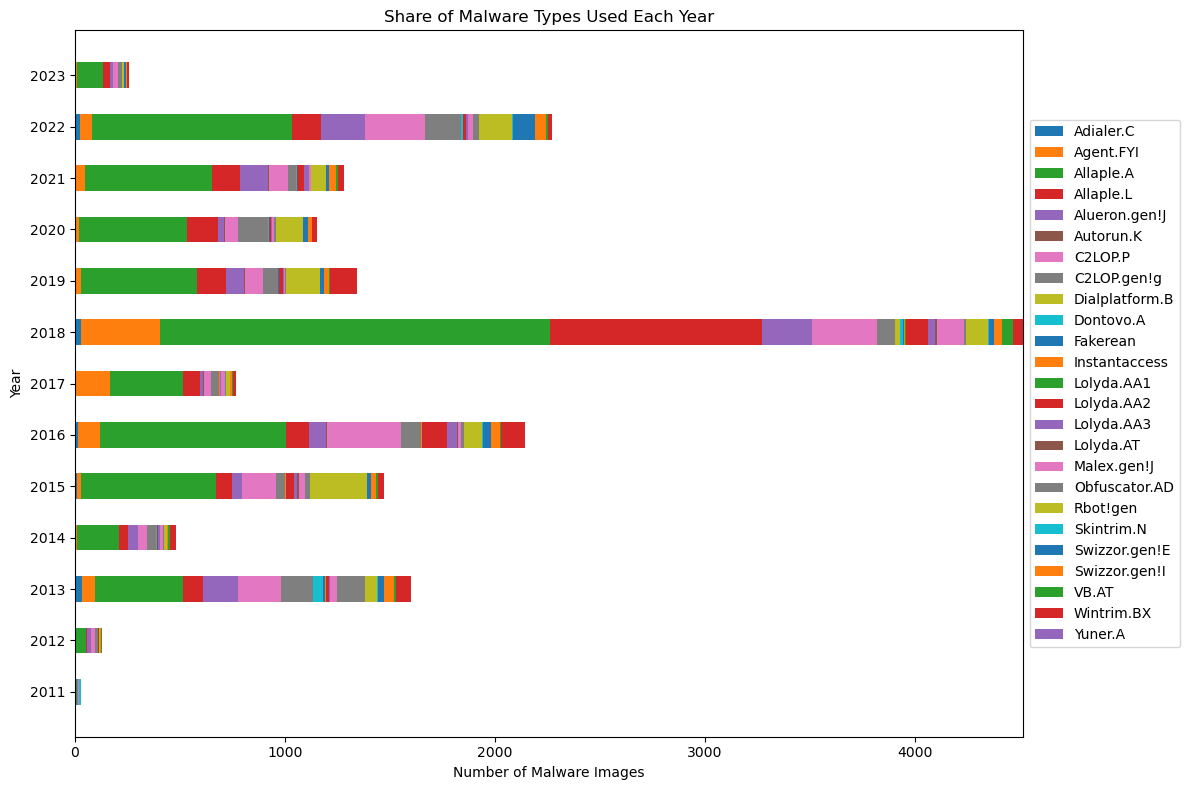

In [166]:
counts_by_year = year_preds[["Year", "True Family Name"]].groupby(["Year"]).value_counts().reset_index().rename(columns={0: "count"})
counts_by_year

# get DF ready for plotting
for year in np.unique(years_df.Year):
    subset = year_preds[year_preds['Year']==year]
    for family in all_families:
        if (family in np.unique(subset[['True Family Name']])) == False:
            counts_by_year = pd.concat([counts_by_year, pd.DataFrame({"Year": [year], "True Family Name": [family], "count": [0]})], ignore_index=True)
            
counts_by_year = counts_by_year.sort_values(["Year", "True Family Name"])

# Share of Malware Types Used Each Year
left = [0] * 13
height = 0.5

plt.figure(figsize=(12, 8))
for family in all_families:
    plt.barh(np.unique(years_df[['Year']]), width=counts_by_year.loc[counts_by_year["True Family Name"]==family]["count"], height=height, left=left)
    left = [x + y for x, y in zip(counts_by_year.loc[counts_by_year["True Family Name"]==family]["count"], left)]

plt.xlabel("Number of Malware Images")
plt.ylabel("Year")
plt.yticks(range(13), range(2011,2024))
plt.legend(all_families, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used Each Year")
plt.tight_layout()
plt.savefig("results/temp_agg_family_dists.png")

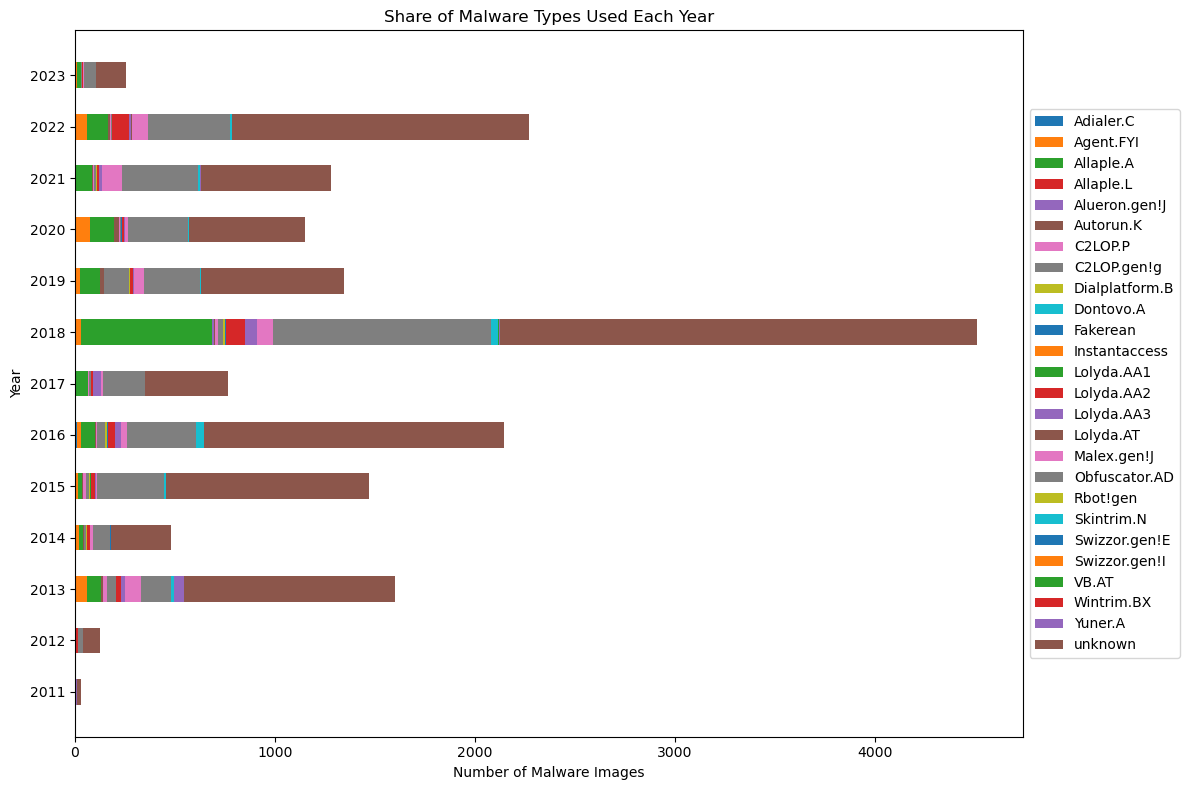

In [167]:
all_families = all_families + ["unknown"]
from cycler import cycler
colors = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

counts_by_year_os = year_preds[["Year", "Agg OS Family"]].groupby(["Year"]).value_counts().reset_index().rename(columns={0: "count"})
counts_by_year_os

# get DF ready for plotting
for year in np.unique(years_df.Year):
    subset = year_preds[year_preds['Year']==year]
    for family in all_families:
        if (family in np.unique(subset[['Agg OS Family']])) == False:
            counts_by_year_os = pd.concat([counts_by_year_os, pd.DataFrame({"Year": [year], "Agg OS Family": [family], "count": [0]})], ignore_index=True)
            
counts_by_year_os = counts_by_year_os.sort_values(["Year", "Agg OS Family"])

# Share of Malware Types Used Each Year
left = [0] * 13
height = 0.5
i = 0
# next_color = pd.DataFrame(colors)['color'].iloc[i]

plt.figure(figsize=(12, 8))
for family in all_families:
    plt.barh(np.unique(years_df[['Year']]), width=counts_by_year_os.loc[counts_by_year_os["Agg OS Family"]==family]["count"], height=height, left=left)
    left = [x + y for x, y in zip(counts_by_year_os.loc[counts_by_year_os["Agg OS Family"]==family]["count"], left)]
    if (list(counts_by_year_os.loc[counts_by_year_os["Agg OS Family"]==family]["count"]) != [0]*13):
        i += 1
        # next_color = pd.DataFrame(colors)['color'].iloc[i % 10]

plt.xlabel("Number of Malware Images")
plt.ylabel("Year")
plt.yticks(range(13), range(2011,2024))
plt.legend(all_families, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Share of Malware Types Used Each Year")
plt.tight_layout()
plt.savefig("results/temp_os_family_dists.png")

## Plot Results by Each Classifier

### KNN

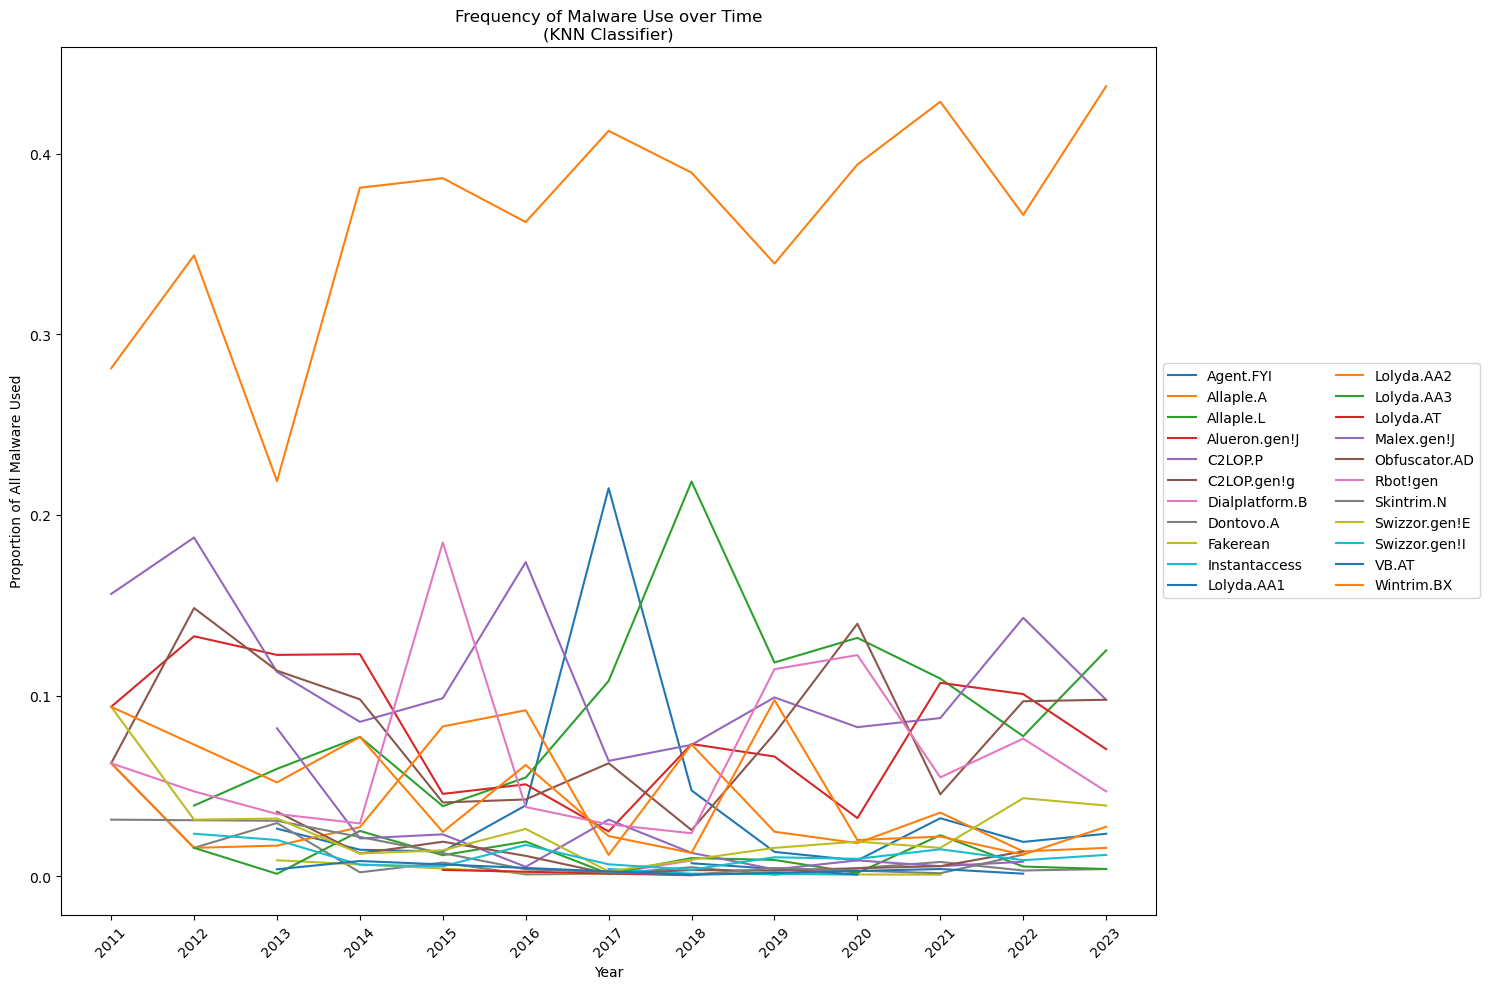

In [168]:
percents_annual_knn = pd.DataFrame({'Year': [], 'Family': [], 'Percent': []})
for year in range(0, 13):
    subset = year_preds[['Year', 'KNN Preds']].loc[year_preds['Year'] == year].groupby('KNN Preds').value_counts().reset_index().rename(columns={0: "count"})
    subset = pd.merge(subset, class_index_reference, right_on="True Family Index", left_on="KNN Preds", how="left")
    for i in range(len(subset)):
        percents_annual_knn = pd.concat([percents_annual_knn, pd.DataFrame({'Year': [year], 'Family': [subset['True Family Name'].iloc[i]], 'Percent': [subset['count'].iloc[i] / sum(subset['count'])]})])
        
percents_annual_knn = percents_annual_knn.sort_values(by=["Year", "Percent"], ascending = False)
percents_annual_knn

top_families_knn = pd.DataFrame({'Year': [], 'KNN Family': [], 'Percent': []})
for year in range(0, 13):
    subset = percents_annual_knn[percents_annual_knn["Year"] == year]
    top_families_knn = pd.concat([top_families_knn, pd.DataFrame({'Year': [year] * len(subset), 'KNN Family': subset['Family'].iloc[range(len(subset))], 'Percent': subset['Percent'].iloc[range(len(subset))]})])
    
top_families_knn
plt.figure(figsize=(15,10))
for family in np.unique(top_families_knn['KNN Family']):
    data = top_families_knn[top_families_knn['KNN Family']==family]
    plt.plot("Year", "Percent", data = data, label = family)

plt.legend(loc='center left', bbox_to_anchor = (1, 0.5), ncols=2)
plt.xlabel("Year")
plt.ylabel("Proportion of All Malware Used")
plt.title("Frequency of Malware Use over Time\n(KNN Classifier)")
plt.xticks(range(13), range(2011, 2024))
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("results/knn_family_timeline.png")

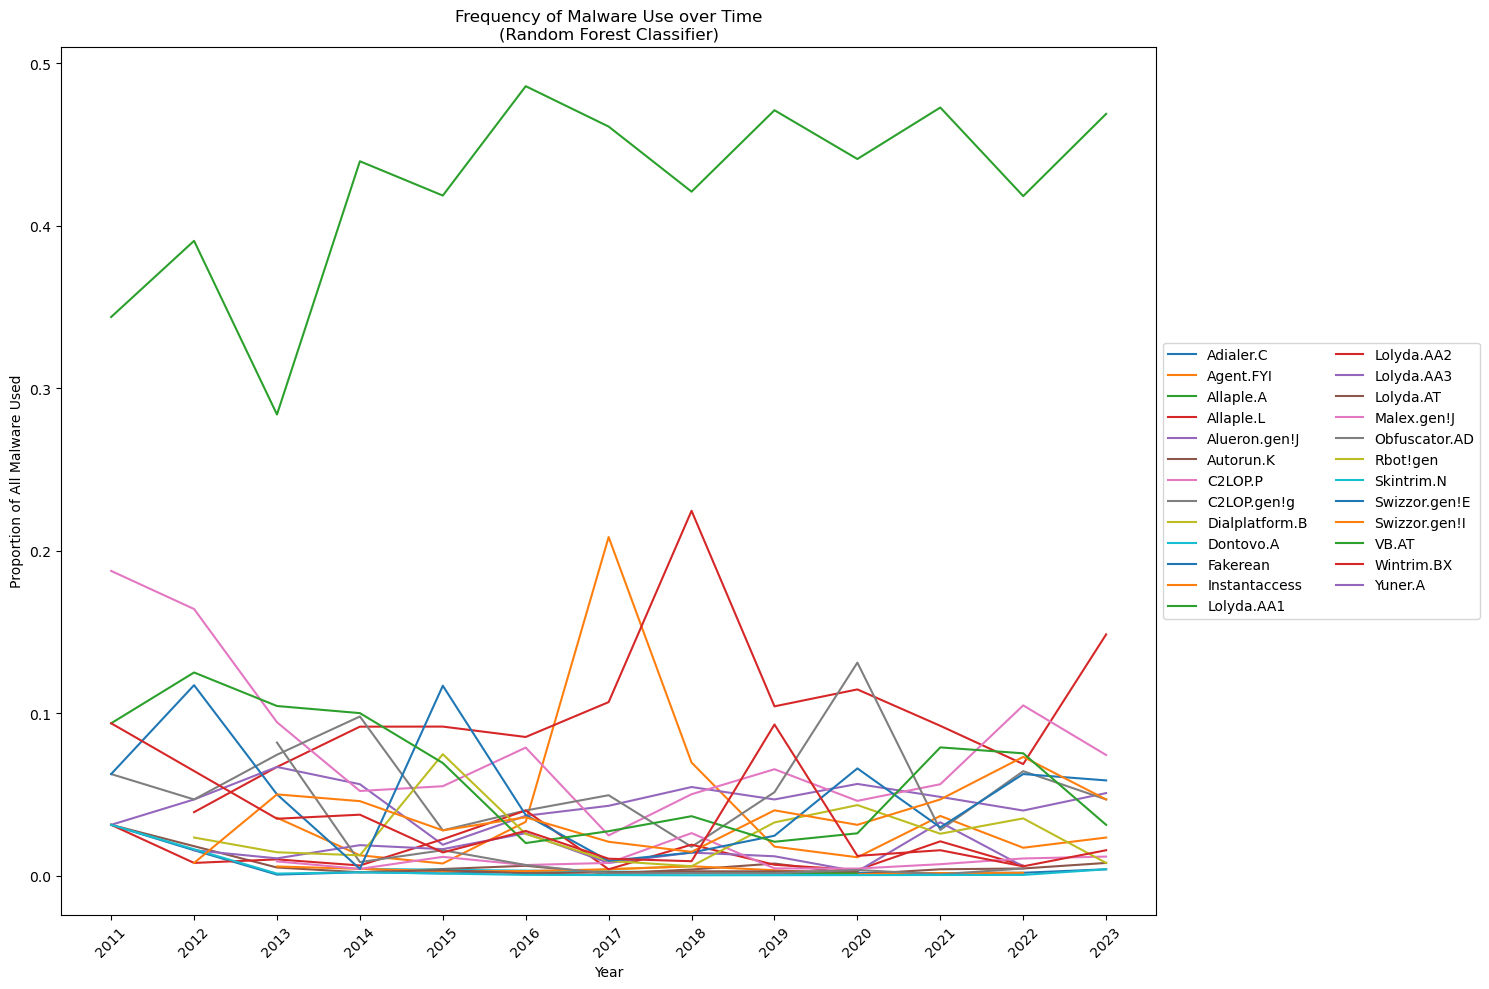

In [169]:
percents_annual_rf = pd.DataFrame({'Year': [], 'Family': [], 'Percent': []})
for year in range(0, 13):
    subset = year_preds[['Year', 'RF Preds']].loc[year_preds['Year'] == year].groupby('RF Preds').value_counts().reset_index().rename(columns={0: "count"})
    subset = pd.merge(subset, class_index_reference, right_on="True Family Index", left_on="RF Preds", how="left")
    for i in range(len(subset)):
        percents_annual_rf = pd.concat([percents_annual_rf, pd.DataFrame({'Year': [year], 'Family': [subset['True Family Name'].iloc[i]], 'Percent': [subset['count'].iloc[i] / sum(subset['count'])]})])
        
percents_annual_rf = percents_annual_rf.sort_values(by=["Year", "Percent"], ascending = False)
percents_annual_rf

top_families_rf = pd.DataFrame({'Year': [], 'RF Family': [], 'Percent': []})
for year in range(0, 13):
    subset = percents_annual_rf[percents_annual_rf["Year"] == year]
    top_families_rf = pd.concat([top_families_rf, pd.DataFrame({'Year': [year] * len(subset), 'RF Family': subset['Family'].iloc[range(len(subset))], 'Percent': subset['Percent'].iloc[range(len(subset))]})])
    
top_families_rf
plt.figure(figsize=(15,10))
for family in np.unique(top_families_rf['RF Family']):
    data = top_families_rf[top_families_rf['RF Family']==family]
    plt.plot("Year", "Percent", data = data, label = family)

plt.legend(loc='center left', bbox_to_anchor = (1, 0.5), ncols=2)
plt.xlabel("Year")
plt.ylabel("Proportion of All Malware Used")
plt.title("Frequency of Malware Use over Time\n(Random Forest Classifier)")
plt.xticks(range(13), range(2011, 2024))
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("results/rf_family_timeline.png")

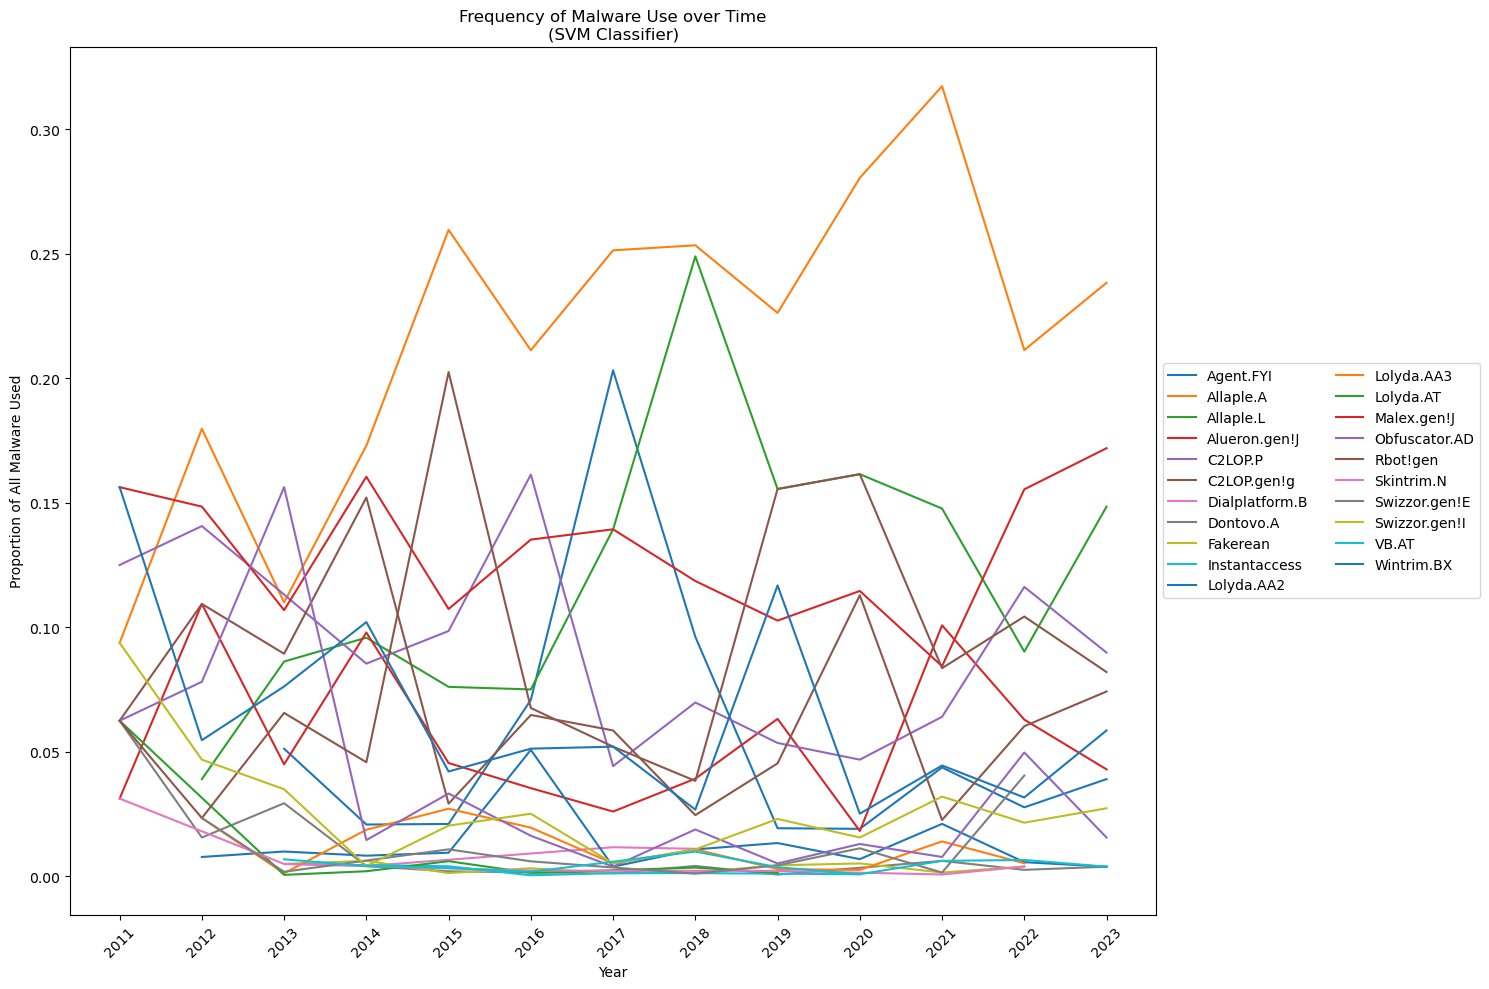

In [170]:
percents_annual_svm = pd.DataFrame({'Year': [], 'Family': [], 'Percent': []})
for year in range(0, 13):
    subset = year_preds[['Year', 'SVM Preds']].loc[year_preds['Year'] == year].groupby('SVM Preds').value_counts().reset_index().rename(columns={0: "count"})
    subset = pd.merge(subset, class_index_reference, right_on="True Family Index", left_on="SVM Preds", how="left")
    for i in range(len(subset)):
        percents_annual_svm = pd.concat([percents_annual_svm, pd.DataFrame({'Year': [year], 'Family': [subset['True Family Name'].iloc[i]], 'Percent': [subset['count'].iloc[i] / sum(subset['count'])]})])
        
percents_annual_svm = percents_annual_svm.sort_values(by=["Year", "Percent"], ascending = False)
percents_annual_svm

top_families_svm = pd.DataFrame({'Year': [], 'SVM Family': [], 'Percent': []})
for year in range(0, 13):
    subset = percents_annual_svm[percents_annual_svm["Year"] == year]
    top_families_svm = pd.concat([top_families_svm, pd.DataFrame({'Year': [year] * len(subset), 'SVM Family': subset['Family'].iloc[range(len(subset))], 'Percent': subset['Percent'].iloc[range(len(subset))]})])
    
top_families_svm
plt.figure(figsize=(15,10))
for family in np.unique(top_families_svm['SVM Family']):
    data = top_families_svm[top_families_svm['SVM Family']==family]
    plt.plot("Year", "Percent", data = data, label = family)

plt.legend(loc='center left', bbox_to_anchor = (1, 0.5), ncols=2)
plt.xlabel("Year")
plt.ylabel("Proportion of All Malware Used")
plt.title("Frequency of Malware Use over Time\n(SVM Classifier)")
plt.xticks(range(13), range(2011, 2024))
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("results/svm_family_timeline.png")

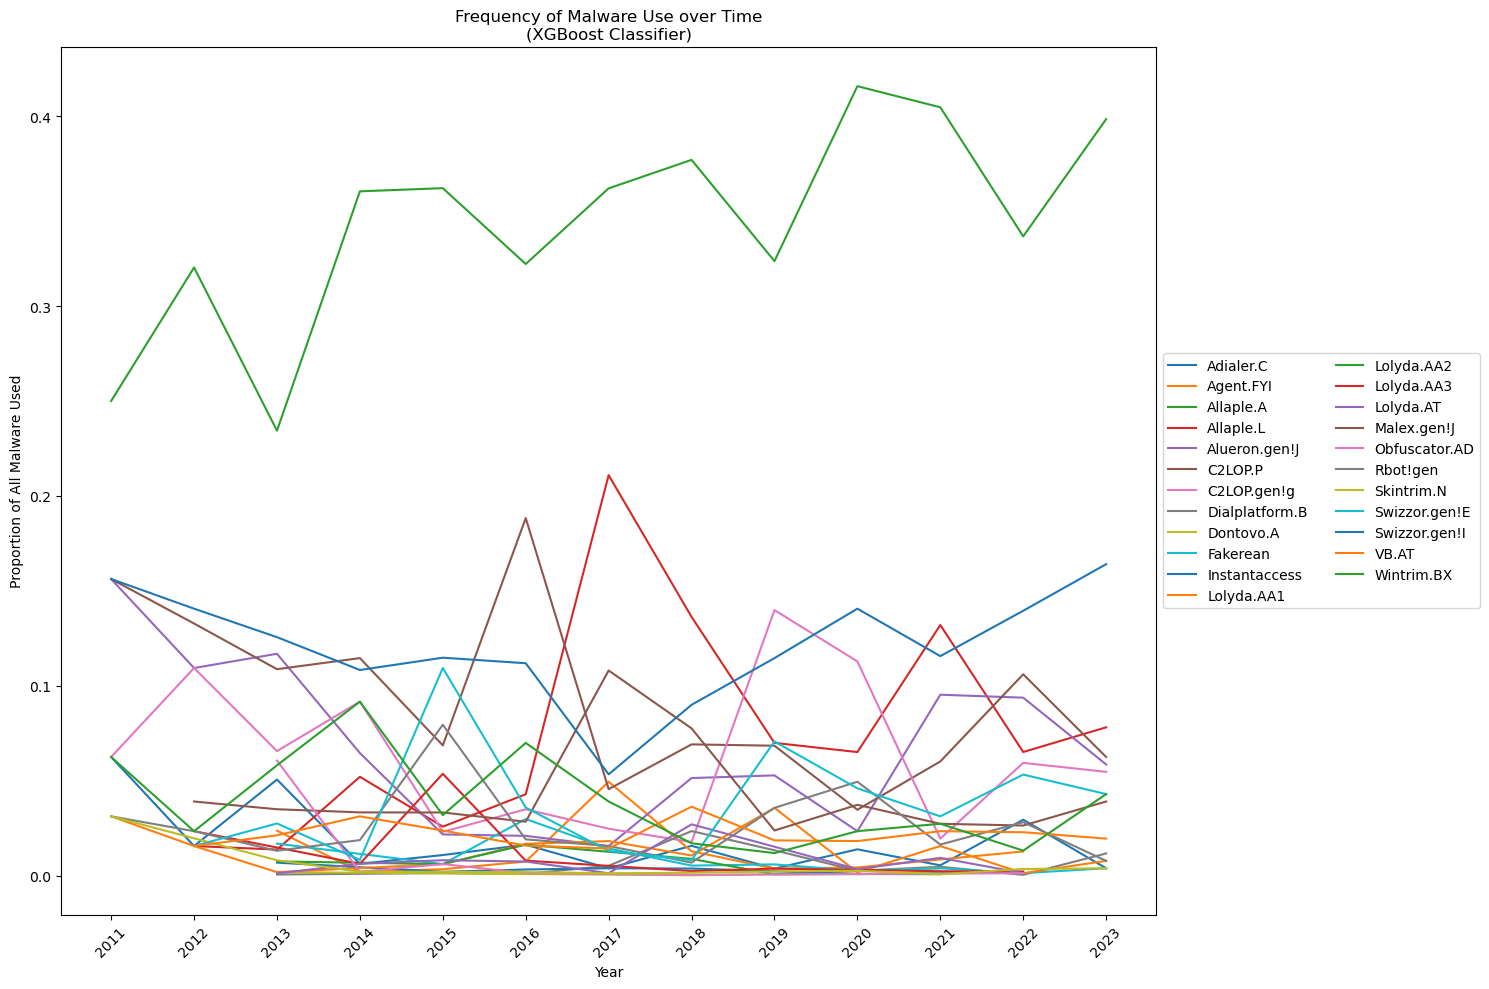

In [171]:
percents_annual_xgb = pd.DataFrame({'Year': [], 'Family': [], 'Percent': []})
for year in range(0, 13):
    subset = year_preds[['Year', 'XGB Preds']].loc[year_preds['Year'] == year].groupby('XGB Preds').value_counts().reset_index().rename(columns={0: "count"})
    subset = pd.merge(subset, class_index_reference, right_on="True Family Index", left_on="XGB Preds", how="left")
    for i in range(len(subset)):
        percents_annual_xgb = pd.concat([percents_annual_xgb, pd.DataFrame({'Year': [year], 'Family': [subset['True Family Name'].iloc[i]], 'Percent': [subset['count'].iloc[i] / sum(subset['count'])]})])
        
percents_annual_xgb = percents_annual_xgb.sort_values(by=["Year", "Percent"], ascending = False)
percents_annual_xgb

top_families_xgb = pd.DataFrame({'Year': [], 'XGB Family': [], 'Percent': []})
for year in range(0, 13):
    subset = percents_annual_xgb[percents_annual_xgb["Year"] == year]
    top_families_xgb = pd.concat([top_families_xgb, pd.DataFrame({'Year': [year] * len(subset), 'XGB Family': subset['Family'].iloc[range(len(subset))], 'Percent': subset['Percent'].iloc[range(len(subset))]})])
    
top_families_xgb
plt.figure(figsize=(15,10))
for family in np.unique(top_families_xgb['XGB Family']):
    data = top_families_xgb[top_families_xgb['XGB Family']==family]
    plt.plot("Year", "Percent", data = data, label = family)

plt.legend(loc='center left', bbox_to_anchor = (1, 0.5), ncols=2)
plt.xlabel("Year")
plt.ylabel("Proportion of All Malware Used")
plt.title("Frequency of Malware Use over Time\n(XGBoost Classifier)")
plt.xticks(range(13), range(2011, 2024))
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("results/xgb_family_timeline.png")

# Experiment: Super Learning

In [172]:
from sklearn.linear_model import LogisticRegression, LinearRegression
ensemble = SuperLearner(scorer=metrics.accuracy_score)
ensemble.add([KNeighborsClassifier(n_neighbors=7), RandomForestClassifier(n_estimators=15, max_features='sqrt', max_depth=15),
              svm.SVC(kernel='linear', class_weight = 'balanced', probability = True, C = 1), xgb.XGBClassifier(max_depth=18, n_estimators=15)])

ensemble.add_meta(LogisticRegression(max_iter=10000))

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...b859d80>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function accuracy_score at 0x31b859d80>, shuffle=False,
       verbose=False)

In [173]:
ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_val)
metrics.accuracy_score(preds, y_val)

/Users/catherinestanton/micromamba/envs/cs109b/lib/python3.10/site-packages/mlens/parallel/_base_functions.py:311: ParameterChangeWarning: Parameter value ('multi:softprob') has changed since model was fitted ('binary:logistic').
  warnings.warn(


0.6274193548387097